In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, f1_score, mean_squared_error
import pandas as pd

In [2]:
def makey_rings5(Y_train):
    res = []
    for i in range(len(Y_train)):
        if Y_train[i][0]==0:
            res.append([1,0,0,0,0])
        if Y_train[i][0]==1:
            res.append([0,1,0,0,0])
        if Y_train[i][0]==2:
            res.append([0,0,1,0,0])
        if Y_train[i][0]==3:
            res.append([0,0,0,1,0])
        if Y_train[i][0]==4:
            res.append([0,0,0,0,1])
    res = np.array(res)
    return res

In [3]:
def makey_rings3(Y_train):
    res = []
    for i in range(len(Y_train)):
        if Y_train[i][0]==0:
            res.append([1,0,0])
        if Y_train[i][0]==1:
            res.append([0,1,0])
        if Y_train[i][0]==2:
            res.append([0,0,1])
    res = np.array(res)
    return res

In [4]:
def makeyxor3(Y_train):
    res = []
    for i in range(len(Y_train)):
        if Y_train[i][0]==1:
            res.append([0,1])
        if Y_train[i][0]==0:
            res.append([1,0])
    res = np.array(res)
    return res

In [5]:
def grad_L2_weights(layer):
    return 2*np.sum(layer.weights)

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def linear(x):
    return x
def softmax(x):
    expx = np.exp(x - np.max(x)).flatten()
    return expx / expx.sum(axis=0, keepdims=True)
def ReLu(x):
    return np.maximum(0,x)
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [7]:
def uniform(size, prev_size):
    return np.random.uniform(size=size*prev_size)
def He(size, prev_size):
    return np.random.normal(scale=np.sqrt(2/prev_size),size=size*prev_size)
def Xavier(size, prev_size):
    return np.random.uniform(low=-1, high=1,size=size*prev_size)*np.sqrt(6)/(size+prev_size)

In [8]:
def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))
def linear_grad(x):
    return np.ones_like(x)
def softmax_grad(x):
    s = x.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)
def ReLu_grad(x):
    return np.where(x <= 0, 0.01, 1)
def tanh_grad(x):
    return 1-tanh(x)**2

In [9]:
def MSE(y_true, y_pred):
    diff = y_pred.flatten() - y_true
    mse = np.sum(diff**2) / diff.size
    return mse
def CE(y_true, y_pred):
    ce = -np.mean(y_true * np.log(y_pred + 1e-8))
    return ce

In [10]:
def MSE_grad(y_true, y_pred):
    mse_grad = (2/y_true.size) * (y_pred.T - y_true)
    return mse_grad
def CE_grad(y_true, y_pred):
    return y_pred - y_true

In [11]:
functions = {"sigmoid":sigmoid, "linear":linear, "softmax":softmax, "relu":ReLu, "tanh":tanh}
weights_methods_dict = {"uniform":uniform, "He":He, "Xavier":Xavier}
functions_grads = {"sigmoid":sigmoid_grad, "linear":linear_grad, "softmax":softmax_grad, "relu":ReLu_grad, "tanh":tanh_grad}
loss_dict = {"MSE":MSE, "CE":CE}
loss_grad_dict = {"MSE":MSE_grad, "CE":CE_grad}

In [12]:
class Layer:
    def __init__(self,size,prev_size,act_func="linear",weights_method="uniform"):
        self.size = size
        self.prev_size = prev_size
        self.value_before = None
        self.value_after = None
        self.biases = None
        self.weights = None
        self.act_func = functions[act_func]
        self.weights_method = weights_methods_dict[weights_method]
        self.grad = functions_grads[act_func]
        self._make_weights()
        self._make_biases()
                
    def _make_weights(self):
        W = self.weights_method(self.prev_size, self.size)
        W.resize(self.size, self.prev_size)
        self.weights = W
    
    def _make_biases(self):
        B = self.weights_method(self.size, 1)
        B = np.reshape(B, (self.size, 1))
        self.biases = B    
    
    def feedforward(self, inputs):
        self.value_before = np.dot(self.weights,inputs) + self.biases
        self.value_after = self.act_func(self.value_before)
        return self.value_after
    
    def layer_grad(self):
        return self.grad(self.value_before)

In [49]:
class NeuralNetwork:
    def __init__(self,input_size,layers_size,act_functions,weights_methods):
        self.layers = []
        self.input_size = input_size
        self._make_layers(layers_size,act_functions, weights_methods)
        self.optimizer_dict = {"SGD":self.SGD, "GD":self.GD, "BGD":self.BGD, "Momentum":self.momentum, "RMSProp":self.RMSProp}
        self.optimizer = None
        self.loss = None
        self.loss_grad = None
        self.lr = None
        self.losses = []
        self.vallosses = []
        
    def _make_layers(self,layers_size, act_functions, weights_methods):
        layers_size.insert(0,self.input_size)
        for i in range(1,len(layers_size)):
            self.layers.append(Layer(layers_size[i], layers_size[i-1],act_functions[i-1],weights_methods[i-1]))
    
    def backpropagation(self, X, Y):
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        reg = 0
        if self.with_regularization:
            reg = grad_L2_weights(self.layers[-1])
        error_o = self.loss_grad(Y.T, self.layers[-1].value_after.reshape(-1,1)) + self.lmbda * reg
        for i in reversed(range(len(self.layers) - 1)):
            reg = 0
            if self.with_regularization:
                reg = grad_L2_weights(self.layers[i])
            error_i = np.multiply(self.layers[i+1].weights.T.dot(error_o), self.layers[i].layer_grad()) + self.lmbda * reg
            delta_w[i+1] = error_o.dot(self.layers[i].value_after.T)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)
            error_o = error_i
        delta_w[0] = error_o.dot(X)
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)
        return delta_w, delta_b
        
    def update_params(self, delta_w, delta_b, lr):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.weights = layer.weights - lr * delta_w[i]
            layer.biases = layer.biases - lr * delta_b[i]
            
    def SGD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat, np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                self.update_params(dw, db, self.lr)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat.flatten(), Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(Y, y_hat)}")
            if i % 100 == 0 and self.x_val is not None:
                yhat = self.predict(self.x_val)
                loss = self.loss(yhat,self.y_val)
                self.vallosses.append(loss)
                print(f"Validation loss: {loss}")
                if self.target is not None and loss < self.target and self.early_stopping:
                    break
                
    def GD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            dw_final = [0 for _ in range(len(self.layers))]
            db_final = [0 for _ in range(len(self.layers))]
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat,np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                dw_final = [dw_final[i] + self.lr * dw[i] for i in range(len(self.layers))]
                db_final = [db_final[i] + self.lr * db[i] for i in range(len(self.layers))]
            self.update_params(dw_final, db_final, 1)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat.flatten(), Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")
            if i % 100 == 0 and self.x_val is not None:
                yhat = self.predict(self.x_val)
                loss = self.loss(yhat,self.y_val)
                self.vallosses.append(loss)
                print(f"Validation loss: {loss}")
                if self.target is not None and loss < self.target and self.early_stopping:
                    break
    
    def BGD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            y_hat = np.array([])
            np.random.seed(1337)
            np.random.shuffle(X)
            np.random.seed(1337)
            np.random.shuffle(Y)
            batches_x = np.array_split(X, batch_size)
            batches_y = np.array_split(Y, batch_size)
            for batch_x, batch_y in zip(batches_x, batches_y):
                dw_final = [0 for _ in range(len(self.layers))]
                db_final = [0 for _ in range(len(self.layers))]
                for x, y in zip(batch_x, batch_y):
                    x = x.reshape(1,-1)
                    y = y.reshape(1,-1)
                    y_hat = np.append(y_hat,np.array(self.predict_one(x)))
                    dw, db = self.backpropagation(x,y)
                    dw_final = [dw_final[i] + self.lr * dw[i] for i in range(len(self.layers))]
                    db_final = [db_final[i] + self.lr * db[i] for i in range(len(self.layers))]
                self.update_params(dw_final, db_final, 1) 
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat, Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}") 
            if i % 100 == 0 and self.x_val is not None:
                yhat = self.predict(self.x_val)
                loss = self.loss(yhat,self.y_val)
                self.vallosses.append(loss)
                print(f"Validation loss: {loss}")
                if self.target is not None and loss < self.target and self.early_stopping:
                    break
    
    def momentum(self, X, Y, epochs, batch_size, l, beta):
        momentum_dw = [0 for _ in range(len(self.layers))]
        momentum_db = [0 for _ in range(len(self.layers))]
        for i in range(epochs):
            dw_final = [0 for _ in range(len(self.layers))]
            db_final = [0 for _ in range(len(self.layers))]
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat,np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                dw_final = [dw_final[i] + dw[i] for i in range(len(self.layers))]
                db_final = [db_final[i] + db[i] for i in range(len(self.layers))]
            momentum_dw = [dw_final[i] + momentum_dw[i] * l for i in range(len(self.layers))]
            momentum_db = [db_final[i] + momentum_db[i] * l for i in range(len(self.layers))]
            self.update_params(momentum_dw, momentum_db, self.lr)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat.flatten(), Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")
            if i % 100 == 0 and self.x_val is not None:
                yhat = self.predict(self.x_val)
                loss = self.loss(yhat,self.y_val)
                self.vallosses.append(loss)
                print(f"Validation loss: {loss}")
                if self.target is not None and loss < self.target and self.early_stopping:
                    break
                
    def RMSProp(self, X, Y, epochs, batch_size, l, beta):
        exp_g_dw = [0 for _ in range(len(self.layers))]
        exp_g_db = [0 for _ in range(len(self.layers))]
        for i in range(epochs):
            g_dw_final = [0 for _ in range(len(self.layers))]
            g_db_final = [0 for _ in range(len(self.layers))]
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat, np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                g_dw_final = [g_dw_final[i] + dw[i] for i in range(len(self.layers))]
                g_db_final = [g_db_final[i] + db[i] for i in range(len(self.layers))]
            exp_g_dw = [exp_g_dw[i] * beta + (1-beta) * g_dw_final[i]**2 for i in range(len(self.layers))]
            exp_g_db = [exp_g_db[i] * beta + (1-beta) * g_db_final[i]**2 for i in range(len(self.layers))]
            g_dw_final = [g_dw_final[i]/(np.sqrt(exp_g_dw[i])+1e-8) for i in range(len(self.layers))]
            g_db_final = [g_db_final[i]/(np.sqrt(exp_g_db[i])+1e-8) for i in range(len(self.layers))]
            self.update_params(g_dw_final, g_db_final, self.lr)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat, Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")  
            if i % 100 == 0 and self.x_val is not None:
                yhat = self.predict(self.x_val)
                loss = self.loss(yhat,self.y_val)
                self.vallosses.append(loss)
                print(f"Validation loss: {loss}")
                if self.target is not None and loss < self.target and self.early_stopping:
                    break
            
    def fit(self, X, Y,target=None,val=None,epochs=1000, batch_size=32, l=0.9, beta=0.9):
        self.x_val = val[0] if val is not None else None
        self.y_val = val[1] if val is not None else None
        self.target = target
        self.optimizer(X, Y, epochs, batch_size, l, beta)
            
    def predict_one(self, X):    
        a = X.T
        for layer in self.layers:
            a = layer.feedforward(a)
        return a
    
    def predict(self,X):
        ans = []
        for item in X:
            ans.append(nn.predict_one(item.reshape(1,-1)))
        return np.array(ans)
    
    def compile(self,loss,optimizer,lr,lmbda=0.01,with_regularization=False,early_stopping=False):
        self.optimizer = self.optimizer_dict[optimizer]
        self.loss = loss_dict[loss]
        self.loss_grad = loss_grad_dict[loss]
        self.lr = lr 
        self.with_regularization = with_regularization
        self.early_stopping = early_stopping
        self.lmbda = lmbda

# multimodal-sparse

In [2]:
train_df = pd.read_csv("data/multimodal-sparse-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/multimodal-sparse-test.csv",index_col=0).reset_index()

In [27]:
X_train = np.reshape(train_df["x"].values,(len(train_df),1))
Y_train = np.reshape(train_df["y"].values,(len(train_df),1))

In [28]:
X_test = np.reshape(test_df["x"].values,(len(test_df),1))
Y_test = np.reshape(test_df["y"].values,(len(test_df),1))

## Default

In [29]:
nn = NeuralNetwork(1,[100,1],["sigmoid","linear"],["uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.001,with_regularization=False,early_stopping=False)

In [30]:
nn.fit(X_train.copy(), Y_train.copy(),val=(X_test.copy(),Y_test.copy()), epochs = 5000, batch_size = 10)

Epoch 1/5000 - loss: 5787.382212593674
Validation loss: 5276.7153865821865
Epoch 2/5000 - loss: 5473.791009701932
Epoch 3/5000 - loss: 5232.710311563623
Epoch 4/5000 - loss: 5359.374934866222
Epoch 5/5000 - loss: 5187.015083145588
Epoch 6/5000 - loss: 4916.211420038419
Epoch 7/5000 - loss: 4653.136658051713
Epoch 8/5000 - loss: 4271.711087426109
Epoch 9/5000 - loss: 4448.00360649276
Epoch 10/5000 - loss: 4062.580878991315
Epoch 11/5000 - loss: 4034.044555378076
Epoch 12/5000 - loss: 4025.6549580364967
Epoch 13/5000 - loss: 4003.4850274932187
Epoch 14/5000 - loss: 3826.664875235126
Epoch 15/5000 - loss: 3784.3947578556304
Epoch 16/5000 - loss: 3830.774955716738
Epoch 17/5000 - loss: 3678.062761026721
Epoch 18/5000 - loss: 3662.2574369143463
Epoch 19/5000 - loss: 3472.6788963146464
Epoch 20/5000 - loss: 3468.388471295303
Epoch 21/5000 - loss: 3420.8829077406017
Epoch 22/5000 - loss: 3386.3109392166443
Epoch 23/5000 - loss: 3267.587629560844
Epoch 24/5000 - loss: 3132.817382896673
Epoch 2

Epoch 213/5000 - loss: 1003.7077271586828
Epoch 214/5000 - loss: 1015.1141154495705
Epoch 215/5000 - loss: 1010.2096955377335
Epoch 216/5000 - loss: 1017.2686771039309
Epoch 217/5000 - loss: 1008.6216984834366
Epoch 218/5000 - loss: 1033.3494662131477
Epoch 219/5000 - loss: 1032.7998094358584
Epoch 220/5000 - loss: 1009.5477599083782
Epoch 221/5000 - loss: 1004.3221901104159
Epoch 222/5000 - loss: 1038.3726457617781
Epoch 223/5000 - loss: 976.0626034898654
Epoch 224/5000 - loss: 988.9244933812952
Epoch 225/5000 - loss: 1007.2735921023886
Epoch 226/5000 - loss: 1006.6126553600901
Epoch 227/5000 - loss: 988.4764085002791
Epoch 228/5000 - loss: 1017.0875545309106
Epoch 229/5000 - loss: 984.836988456165
Epoch 230/5000 - loss: 1010.5658489950356
Epoch 231/5000 - loss: 976.6739851949508
Epoch 232/5000 - loss: 1008.3268903910139
Epoch 233/5000 - loss: 982.9500053139
Epoch 234/5000 - loss: 992.813413359245
Epoch 235/5000 - loss: 984.1645100669909
Epoch 236/5000 - loss: 1003.4413899627878
Epoch

Epoch 415/5000 - loss: 291.97659669558453
Epoch 416/5000 - loss: 343.48602438512063
Epoch 417/5000 - loss: 322.6081796822999
Epoch 418/5000 - loss: 282.5687819053713
Epoch 419/5000 - loss: 312.39570767875773
Epoch 420/5000 - loss: 292.5679806986157
Epoch 421/5000 - loss: 319.99311989093167
Epoch 422/5000 - loss: 287.643630023275
Epoch 423/5000 - loss: 295.5506835248465
Epoch 424/5000 - loss: 306.04448881390937
Epoch 425/5000 - loss: 302.7400904293384
Epoch 426/5000 - loss: 285.04827810902134
Epoch 427/5000 - loss: 316.1768863369416
Epoch 428/5000 - loss: 292.85725132857397
Epoch 429/5000 - loss: 288.3619104077667
Epoch 430/5000 - loss: 297.8200883235077
Epoch 431/5000 - loss: 295.842185037562
Epoch 432/5000 - loss: 296.6775018769969
Epoch 433/5000 - loss: 291.2706272416434
Epoch 434/5000 - loss: 304.9485832710633
Epoch 435/5000 - loss: 282.5133999799108
Epoch 436/5000 - loss: 282.28135285448644
Epoch 437/5000 - loss: 298.2526650347923
Epoch 438/5000 - loss: 320.3592942545165
Epoch 439/

Epoch 618/5000 - loss: 242.52654962647517
Epoch 619/5000 - loss: 277.0225229560487
Epoch 620/5000 - loss: 245.33100793456697
Epoch 621/5000 - loss: 258.7919264249212
Epoch 622/5000 - loss: 251.29498493067072
Epoch 623/5000 - loss: 268.08814777878547
Epoch 624/5000 - loss: 257.21451517597893
Epoch 625/5000 - loss: 243.26672120912207
Epoch 626/5000 - loss: 267.6786251707662
Epoch 627/5000 - loss: 235.7880035314419
Epoch 628/5000 - loss: 246.04724621208715
Epoch 629/5000 - loss: 269.6984517550979
Epoch 630/5000 - loss: 260.4850936060475
Epoch 631/5000 - loss: 237.74767091525808
Epoch 632/5000 - loss: 282.28302835584464
Epoch 633/5000 - loss: 252.00453490289019
Epoch 634/5000 - loss: 227.95768631783818
Epoch 635/5000 - loss: 267.8748625987345
Epoch 636/5000 - loss: 238.70259959492705
Epoch 637/5000 - loss: 271.99693585044156
Epoch 638/5000 - loss: 228.1914108494187
Epoch 639/5000 - loss: 252.9689616828226
Epoch 640/5000 - loss: 256.9353170246169
Epoch 641/5000 - loss: 253.07874564365838
Ep

Epoch 821/5000 - loss: 252.8835197598715
Epoch 822/5000 - loss: 229.13264063989178
Epoch 823/5000 - loss: 225.0301986649697
Epoch 824/5000 - loss: 246.30309218251915
Epoch 825/5000 - loss: 224.11946826009267
Epoch 826/5000 - loss: 254.29910717033982
Epoch 827/5000 - loss: 214.35176421858654
Epoch 828/5000 - loss: 251.36011787154433
Epoch 829/5000 - loss: 225.15734266813644
Epoch 830/5000 - loss: 248.25312204915812
Epoch 831/5000 - loss: 237.88855459077612
Epoch 832/5000 - loss: 242.05230826989023
Epoch 833/5000 - loss: 255.47192942968394
Epoch 834/5000 - loss: 211.49255827185192
Epoch 835/5000 - loss: 231.75204269932905
Epoch 836/5000 - loss: 223.79392840832014
Epoch 837/5000 - loss: 247.92603687382152
Epoch 838/5000 - loss: 242.46721535246834
Epoch 839/5000 - loss: 258.74686192694537
Epoch 840/5000 - loss: 223.73038700398516
Epoch 841/5000 - loss: 219.90677418733702
Epoch 842/5000 - loss: 246.5695882521706
Epoch 843/5000 - loss: 226.36712371642662
Epoch 844/5000 - loss: 237.5437104322

Epoch 1023/5000 - loss: 208.73233441750122
Epoch 1024/5000 - loss: 232.94094059330615
Epoch 1025/5000 - loss: 217.0096774415042
Epoch 1026/5000 - loss: 206.52179080681404
Epoch 1027/5000 - loss: 234.08776450019755
Epoch 1028/5000 - loss: 241.26812079863262
Epoch 1029/5000 - loss: 232.13933176913025
Epoch 1030/5000 - loss: 204.20434680868334
Epoch 1031/5000 - loss: 230.2265782450092
Epoch 1032/5000 - loss: 197.27822259420245
Epoch 1033/5000 - loss: 202.75702236938278
Epoch 1034/5000 - loss: 243.61862573396462
Epoch 1035/5000 - loss: 232.64353172203693
Epoch 1036/5000 - loss: 197.07544248791015
Epoch 1037/5000 - loss: 240.15898346423188
Epoch 1038/5000 - loss: 187.80867476764607
Epoch 1039/5000 - loss: 191.43828691489378
Epoch 1040/5000 - loss: 235.90703590210256
Epoch 1041/5000 - loss: 204.6502210754548
Epoch 1042/5000 - loss: 225.73561376597232
Epoch 1043/5000 - loss: 185.9100451147521
Epoch 1044/5000 - loss: 224.30587208911976
Epoch 1045/5000 - loss: 194.46614544007483
Epoch 1046/5000

Epoch 1227/5000 - loss: 192.41321659675015
Epoch 1228/5000 - loss: 175.22394014882366
Epoch 1229/5000 - loss: 205.12118798479074
Epoch 1230/5000 - loss: 184.826573490033
Epoch 1231/5000 - loss: 200.60192850657742
Epoch 1232/5000 - loss: 170.61541307698758
Epoch 1233/5000 - loss: 183.88949900838605
Epoch 1234/5000 - loss: 187.78991761269967
Epoch 1235/5000 - loss: 188.42657809293743
Epoch 1236/5000 - loss: 191.83547509150048
Epoch 1237/5000 - loss: 207.60255917297968
Epoch 1238/5000 - loss: 224.16400855130013
Epoch 1239/5000 - loss: 177.83775918040536
Epoch 1240/5000 - loss: 185.93419234349852
Epoch 1241/5000 - loss: 187.28849636637656
Epoch 1242/5000 - loss: 176.49472647394907
Epoch 1243/5000 - loss: 208.60724531575744
Epoch 1244/5000 - loss: 205.25924422958232
Epoch 1245/5000 - loss: 177.19325161183215
Epoch 1246/5000 - loss: 170.79128359972486
Epoch 1247/5000 - loss: 218.19387638034883
Epoch 1248/5000 - loss: 199.32837791622035
Epoch 1249/5000 - loss: 193.91754978293102
Epoch 1250/50

Epoch 1430/5000 - loss: 150.82948359234803
Epoch 1431/5000 - loss: 140.94973999254339
Epoch 1432/5000 - loss: 158.0539587535918
Epoch 1433/5000 - loss: 154.2376869265589
Epoch 1434/5000 - loss: 171.03485413458924
Epoch 1435/5000 - loss: 152.87394890842197
Epoch 1436/5000 - loss: 161.70477759002972
Epoch 1437/5000 - loss: 120.39080801559854
Epoch 1438/5000 - loss: 152.6500973685877
Epoch 1439/5000 - loss: 164.4421420089687
Epoch 1440/5000 - loss: 151.6163568092242
Epoch 1441/5000 - loss: 144.8411429322111
Epoch 1442/5000 - loss: 164.38344392925617
Epoch 1443/5000 - loss: 130.8510346278701
Epoch 1444/5000 - loss: 130.38790489993033
Epoch 1445/5000 - loss: 170.20966346101048
Epoch 1446/5000 - loss: 145.0639267383752
Epoch 1447/5000 - loss: 170.71899403934975
Epoch 1448/5000 - loss: 138.1043215755805
Epoch 1449/5000 - loss: 144.37607652487904
Epoch 1450/5000 - loss: 145.7468830200224
Epoch 1451/5000 - loss: 147.05463144964324
Epoch 1452/5000 - loss: 157.7548676557686
Epoch 1453/5000 - loss

Epoch 1634/5000 - loss: 126.22329861680096
Epoch 1635/5000 - loss: 100.05715751375841
Epoch 1636/5000 - loss: 125.53713961870861
Epoch 1637/5000 - loss: 108.331724061718
Epoch 1638/5000 - loss: 110.81713264622371
Epoch 1639/5000 - loss: 109.65551266815294
Epoch 1640/5000 - loss: 120.18128004539074
Epoch 1641/5000 - loss: 105.66238171155373
Epoch 1642/5000 - loss: 105.4482313869274
Epoch 1643/5000 - loss: 124.53944984360551
Epoch 1644/5000 - loss: 105.66173359290933
Epoch 1645/5000 - loss: 108.66798564095652
Epoch 1646/5000 - loss: 105.3602561958033
Epoch 1647/5000 - loss: 108.83040734061794
Epoch 1648/5000 - loss: 119.21616676004665
Epoch 1649/5000 - loss: 120.5379080691863
Epoch 1650/5000 - loss: 106.41817298285855
Epoch 1651/5000 - loss: 106.77523307007066
Epoch 1652/5000 - loss: 121.55442280619357
Epoch 1653/5000 - loss: 93.51305698503633
Epoch 1654/5000 - loss: 111.43134838929704
Epoch 1655/5000 - loss: 107.89325106426433
Epoch 1656/5000 - loss: 98.31580576575345
Epoch 1657/5000 - 

Epoch 1838/5000 - loss: 79.89306763641815
Epoch 1839/5000 - loss: 85.27331559121968
Epoch 1840/5000 - loss: 65.79797406169749
Epoch 1841/5000 - loss: 86.18012708643995
Epoch 1842/5000 - loss: 62.83447691395272
Epoch 1843/5000 - loss: 76.4907490575475
Epoch 1844/5000 - loss: 79.41575944389893
Epoch 1845/5000 - loss: 78.16204631825627
Epoch 1846/5000 - loss: 70.58275097051845
Epoch 1847/5000 - loss: 85.5929290709458
Epoch 1848/5000 - loss: 66.67066132356032
Epoch 1849/5000 - loss: 63.89275391351107
Epoch 1850/5000 - loss: 84.08131963954375
Epoch 1851/5000 - loss: 64.40215036052746
Epoch 1852/5000 - loss: 82.21397112194067
Epoch 1853/5000 - loss: 63.33210142224774
Epoch 1854/5000 - loss: 64.03384274547035
Epoch 1855/5000 - loss: 67.71656762673153
Epoch 1856/5000 - loss: 75.29049372136437
Epoch 1857/5000 - loss: 72.95030956048193
Epoch 1858/5000 - loss: 69.51945462910179
Epoch 1859/5000 - loss: 74.49414322790378
Epoch 1860/5000 - loss: 76.018065209325
Epoch 1861/5000 - loss: 79.72721024467

Epoch 2038/5000 - loss: 47.80382481977361
Epoch 2039/5000 - loss: 52.874061906505005
Epoch 2040/5000 - loss: 45.79484887449853
Epoch 2041/5000 - loss: 49.10949660808341
Epoch 2042/5000 - loss: 39.73764155648923
Epoch 2043/5000 - loss: 44.82967628415016
Epoch 2044/5000 - loss: 45.421967024161134
Epoch 2045/5000 - loss: 49.83760150962899
Epoch 2046/5000 - loss: 48.06599091275682
Epoch 2047/5000 - loss: 49.5768810173897
Epoch 2048/5000 - loss: 52.06835075436603
Epoch 2049/5000 - loss: 43.18521445762324
Epoch 2050/5000 - loss: 42.46196324869802
Epoch 2051/5000 - loss: 48.741287372231156
Epoch 2052/5000 - loss: 43.799548807306536
Epoch 2053/5000 - loss: 48.553144337498196
Epoch 2054/5000 - loss: 51.609112377347195
Epoch 2055/5000 - loss: 42.84146808509361
Epoch 2056/5000 - loss: 40.48921331559175
Epoch 2057/5000 - loss: 57.06505433588957
Epoch 2058/5000 - loss: 43.69494862083563
Epoch 2059/5000 - loss: 51.4753695692465
Epoch 2060/5000 - loss: 48.694253734733344
Epoch 2061/5000 - loss: 46.98

Epoch 2236/5000 - loss: 28.718505011895964
Epoch 2237/5000 - loss: 33.93971947443888
Epoch 2238/5000 - loss: 35.06576377009569
Epoch 2239/5000 - loss: 34.45395883083903
Epoch 2240/5000 - loss: 31.028088389676554
Epoch 2241/5000 - loss: 26.013324164818385
Epoch 2242/5000 - loss: 30.305052243675345
Epoch 2243/5000 - loss: 31.95393013077471
Epoch 2244/5000 - loss: 35.91523324457133
Epoch 2245/5000 - loss: 31.48462139115324
Epoch 2246/5000 - loss: 32.426536943089275
Epoch 2247/5000 - loss: 27.146370447901422
Epoch 2248/5000 - loss: 33.18068153686263
Epoch 2249/5000 - loss: 31.56270827470301
Epoch 2250/5000 - loss: 31.169192218713032
Epoch 2251/5000 - loss: 28.88401797690983
Epoch 2252/5000 - loss: 37.69956125098897
Epoch 2253/5000 - loss: 27.86157426487233
Epoch 2254/5000 - loss: 28.463995403088223
Epoch 2255/5000 - loss: 35.241794495257466
Epoch 2256/5000 - loss: 28.80317113383948
Epoch 2257/5000 - loss: 34.01881631579049
Epoch 2258/5000 - loss: 27.17877947240201
Epoch 2259/5000 - loss: 3

Epoch 2470/5000 - loss: 21.18029840527827
Epoch 2471/5000 - loss: 23.93750112242623
Epoch 2472/5000 - loss: 20.535891660090204
Epoch 2473/5000 - loss: 24.485610585246725
Epoch 2474/5000 - loss: 19.358134375662594
Epoch 2475/5000 - loss: 23.15373952567081
Epoch 2476/5000 - loss: 21.423175736371128
Epoch 2477/5000 - loss: 24.689005666117822
Epoch 2478/5000 - loss: 24.23906238527321
Epoch 2479/5000 - loss: 20.082518351959646
Epoch 2480/5000 - loss: 21.565118196700176
Epoch 2481/5000 - loss: 20.568607552525947
Epoch 2482/5000 - loss: 19.948810347014508
Epoch 2483/5000 - loss: 24.171755814262553
Epoch 2484/5000 - loss: 21.76358297549769
Epoch 2485/5000 - loss: 20.326614142810808
Epoch 2486/5000 - loss: 21.667169961001967
Epoch 2487/5000 - loss: 21.718126558617435
Epoch 2488/5000 - loss: 21.30073746155462
Epoch 2489/5000 - loss: 23.580535638800576
Epoch 2490/5000 - loss: 22.269100303697527
Epoch 2491/5000 - loss: 22.20545606074299
Epoch 2492/5000 - loss: 21.62007654968516
Epoch 2493/5000 - l

Epoch 2661/5000 - loss: 17.506527319801023
Epoch 2662/5000 - loss: 17.40678088351792
Epoch 2663/5000 - loss: 16.37870338029087
Epoch 2664/5000 - loss: 16.941332246335975
Epoch 2665/5000 - loss: 18.30454942201743
Epoch 2666/5000 - loss: 16.776931989829485
Epoch 2667/5000 - loss: 17.465369614029658
Epoch 2668/5000 - loss: 15.480970361627902
Epoch 2669/5000 - loss: 16.369496196080377
Epoch 2670/5000 - loss: 19.58420882469061
Epoch 2671/5000 - loss: 16.381953325830825
Epoch 2672/5000 - loss: 17.016618774956584
Epoch 2673/5000 - loss: 15.242310357161307
Epoch 2674/5000 - loss: 15.612279339105736
Epoch 2675/5000 - loss: 17.123072664813044
Epoch 2676/5000 - loss: 17.70091307971955
Epoch 2677/5000 - loss: 17.231222120248404
Epoch 2678/5000 - loss: 18.26024475204008
Epoch 2679/5000 - loss: 16.92663307263991
Epoch 2680/5000 - loss: 17.152960209094296
Epoch 2681/5000 - loss: 14.832322095394762
Epoch 2682/5000 - loss: 16.853291313028148
Epoch 2683/5000 - loss: 14.910072326148173
Epoch 2684/5000 - 

Epoch 2891/5000 - loss: 13.123013110185695
Epoch 2892/5000 - loss: 14.296386013741966
Epoch 2893/5000 - loss: 14.675697858879051
Epoch 2894/5000 - loss: 14.178512052927891
Epoch 2895/5000 - loss: 14.349405623421859
Epoch 2896/5000 - loss: 13.614566900472294
Epoch 2897/5000 - loss: 12.534301643551373
Epoch 2898/5000 - loss: 12.582697982318265
Epoch 2899/5000 - loss: 13.41726618573436
Epoch 2900/5000 - loss: 18.064381065945128
Epoch 2901/5000 - loss: 13.069470751271481
Validation loss: 198.03631232042716
Epoch 2902/5000 - loss: 14.342525477140171
Epoch 2903/5000 - loss: 15.909158496047652
Epoch 2904/5000 - loss: 13.328220652282251
Epoch 2905/5000 - loss: 16.255698343979176
Epoch 2906/5000 - loss: 11.496167835314033
Epoch 2907/5000 - loss: 14.347180168251544
Epoch 2908/5000 - loss: 15.66030640055493
Epoch 2909/5000 - loss: 14.52800442745357
Epoch 2910/5000 - loss: 16.0677615989437
Epoch 2911/5000 - loss: 11.612815645819547
Epoch 2912/5000 - loss: 13.338039624195947
Epoch 2913/5000 - loss:

Epoch 3084/5000 - loss: 10.501590410232575
Epoch 3085/5000 - loss: 11.314380249039022
Epoch 3086/5000 - loss: 12.015605403760635
Epoch 3087/5000 - loss: 12.13067740415699
Epoch 3088/5000 - loss: 13.097372015586718
Epoch 3089/5000 - loss: 12.78479137247407
Epoch 3090/5000 - loss: 10.371428869765287
Epoch 3091/5000 - loss: 11.595990542946577
Epoch 3092/5000 - loss: 12.801007327993819
Epoch 3093/5000 - loss: 12.493287481733969
Epoch 3094/5000 - loss: 11.969635839145129
Epoch 3095/5000 - loss: 11.53222111124975
Epoch 3096/5000 - loss: 11.138156672449913
Epoch 3097/5000 - loss: 12.00249262768188
Epoch 3098/5000 - loss: 12.620820245011814
Epoch 3099/5000 - loss: 11.791698736145623
Epoch 3100/5000 - loss: 10.317684500958004
Epoch 3101/5000 - loss: 10.811671489966994
Validation loss: 196.4982264018742
Epoch 3102/5000 - loss: 14.120368664524099
Epoch 3103/5000 - loss: 13.103886775594452
Epoch 3104/5000 - loss: 10.94002232849588
Epoch 3105/5000 - loss: 10.516303975967359
Epoch 3106/5000 - loss: 

Epoch 3280/5000 - loss: 9.258959664698912
Epoch 3281/5000 - loss: 11.839366471733133
Epoch 3282/5000 - loss: 10.52815833011355
Epoch 3283/5000 - loss: 10.262276737463361
Epoch 3284/5000 - loss: 8.136073886799608
Epoch 3285/5000 - loss: 11.147570671708745
Epoch 3286/5000 - loss: 12.363677376403698
Epoch 3287/5000 - loss: 11.793620138654768
Epoch 3288/5000 - loss: 13.89471689992059
Epoch 3289/5000 - loss: 11.267332139287525
Epoch 3290/5000 - loss: 9.215414508764301
Epoch 3291/5000 - loss: 11.459344785808877
Epoch 3292/5000 - loss: 9.214909803164549
Epoch 3293/5000 - loss: 8.966337245665514
Epoch 3294/5000 - loss: 12.277109988971882
Epoch 3295/5000 - loss: 10.669842069655127
Epoch 3296/5000 - loss: 10.781471395322901
Epoch 3297/5000 - loss: 9.202050250967693
Epoch 3298/5000 - loss: 10.363476499975404
Epoch 3299/5000 - loss: 10.571112928986805
Epoch 3300/5000 - loss: 10.2404269133518
Epoch 3301/5000 - loss: 11.111960760853563
Validation loss: 190.45409095637197
Epoch 3302/5000 - loss: 11.2

Epoch 3472/5000 - loss: 11.630104970945268
Epoch 3473/5000 - loss: 10.811288809671083
Epoch 3474/5000 - loss: 7.855404580549023
Epoch 3475/5000 - loss: 9.151750825796846
Epoch 3476/5000 - loss: 11.47260312393329
Epoch 3477/5000 - loss: 10.841397093264678
Epoch 3478/5000 - loss: 8.1874587162619
Epoch 3479/5000 - loss: 9.996643958144256
Epoch 3480/5000 - loss: 10.629042572550867
Epoch 3481/5000 - loss: 8.701231674742454
Epoch 3482/5000 - loss: 9.509854898292243
Epoch 3483/5000 - loss: 11.393930576887296
Epoch 3484/5000 - loss: 9.006321288020562
Epoch 3485/5000 - loss: 9.588132931816437
Epoch 3486/5000 - loss: 12.262121682710385
Epoch 3487/5000 - loss: 9.809366665259287
Epoch 3488/5000 - loss: 10.58228747167079
Epoch 3489/5000 - loss: 11.091667635437386
Epoch 3490/5000 - loss: 7.510967590408997
Epoch 3491/5000 - loss: 10.579496653661863
Epoch 3492/5000 - loss: 11.193488290362748
Epoch 3493/5000 - loss: 10.041926094115396
Epoch 3494/5000 - loss: 8.865605013368532
Epoch 3495/5000 - loss: 10

Epoch 3671/5000 - loss: 9.118244121284485
Epoch 3672/5000 - loss: 8.596685055083164
Epoch 3673/5000 - loss: 8.688039827642147
Epoch 3674/5000 - loss: 8.741419588984314
Epoch 3675/5000 - loss: 10.618428142980505
Epoch 3676/5000 - loss: 9.8305728349654
Epoch 3677/5000 - loss: 11.396555609688912
Epoch 3678/5000 - loss: 8.383879831151196
Epoch 3679/5000 - loss: 8.770615872022187
Epoch 3680/5000 - loss: 7.679292898973065
Epoch 3681/5000 - loss: 9.828852823903482
Epoch 3682/5000 - loss: 8.673368264952334
Epoch 3683/5000 - loss: 8.345396895684534
Epoch 3684/5000 - loss: 8.314264571151124
Epoch 3685/5000 - loss: 9.351901908124196
Epoch 3686/5000 - loss: 10.152198170143555
Epoch 3687/5000 - loss: 9.900523349021942
Epoch 3688/5000 - loss: 11.22388775326383
Epoch 3689/5000 - loss: 10.335201600606698
Epoch 3690/5000 - loss: 7.627346317633853
Epoch 3691/5000 - loss: 8.771803280334064
Epoch 3692/5000 - loss: 10.954843364423358
Epoch 3693/5000 - loss: 9.720596678641789
Epoch 3694/5000 - loss: 7.94276

Epoch 3866/5000 - loss: 9.530147234187297
Epoch 3867/5000 - loss: 10.238112276094418
Epoch 3868/5000 - loss: 10.318214460177241
Epoch 3869/5000 - loss: 12.029944220611581
Epoch 3870/5000 - loss: 11.441942767444898
Epoch 3871/5000 - loss: 9.67213945956159
Epoch 3872/5000 - loss: 10.299317981934246
Epoch 3873/5000 - loss: 8.609614145482562
Epoch 3874/5000 - loss: 6.81082792765064
Epoch 3875/5000 - loss: 9.545795378273613
Epoch 3876/5000 - loss: 9.874927237242396
Epoch 3877/5000 - loss: 9.548841146428193
Epoch 3878/5000 - loss: 8.36201167103169
Epoch 3879/5000 - loss: 8.739516245665365
Epoch 3880/5000 - loss: 12.387437457801159
Epoch 3881/5000 - loss: 9.452772743299612
Epoch 3882/5000 - loss: 9.252814851270452
Epoch 3883/5000 - loss: 8.577387938555693
Epoch 3884/5000 - loss: 8.504419048897642
Epoch 3885/5000 - loss: 9.104829468081686
Epoch 3886/5000 - loss: 10.549734276294151
Epoch 3887/5000 - loss: 9.620664276741
Epoch 3888/5000 - loss: 8.14366767333793
Epoch 3889/5000 - loss: 8.60579098

Epoch 4063/5000 - loss: 8.707471974223598
Epoch 4064/5000 - loss: 9.430072976813275
Epoch 4065/5000 - loss: 8.535801052710967
Epoch 4066/5000 - loss: 8.174408180757041
Epoch 4067/5000 - loss: 8.467076352467547
Epoch 4068/5000 - loss: 9.136517559639282
Epoch 4069/5000 - loss: 8.525580831025076
Epoch 4070/5000 - loss: 9.335673864692353
Epoch 4071/5000 - loss: 10.118382342438881
Epoch 4072/5000 - loss: 7.378667854205071
Epoch 4073/5000 - loss: 7.124730196206211
Epoch 4074/5000 - loss: 8.264239245851957
Epoch 4075/5000 - loss: 9.911032296981556
Epoch 4076/5000 - loss: 8.411489645172727
Epoch 4077/5000 - loss: 10.19691467632666
Epoch 4078/5000 - loss: 9.737776989880368
Epoch 4079/5000 - loss: 8.078955246325002
Epoch 4080/5000 - loss: 8.932298766325918
Epoch 4081/5000 - loss: 7.496206329212782
Epoch 4082/5000 - loss: 8.948455815344085
Epoch 4083/5000 - loss: 9.88171564945789
Epoch 4084/5000 - loss: 10.088223594433822
Epoch 4085/5000 - loss: 11.232920995582747
Epoch 4086/5000 - loss: 10.81736

Epoch 4262/5000 - loss: 12.706626393730332
Epoch 4263/5000 - loss: 8.445332177711482
Epoch 4264/5000 - loss: 8.170465213927795
Epoch 4265/5000 - loss: 10.383419678144122
Epoch 4266/5000 - loss: 7.601981657969205
Epoch 4267/5000 - loss: 8.804523476923984
Epoch 4268/5000 - loss: 8.759802469073799
Epoch 4269/5000 - loss: 11.093292568296494
Epoch 4270/5000 - loss: 8.426606768012093
Epoch 4271/5000 - loss: 9.582440421005183
Epoch 4272/5000 - loss: 9.974173321922603
Epoch 4273/5000 - loss: 9.602077840462059
Epoch 4274/5000 - loss: 7.048628767102113
Epoch 4275/5000 - loss: 9.262542751863409
Epoch 4276/5000 - loss: 9.109727807378396
Epoch 4277/5000 - loss: 9.038368037036614
Epoch 4278/5000 - loss: 7.2442626275125095
Epoch 4279/5000 - loss: 6.787564281110536
Epoch 4280/5000 - loss: 8.414108615406699
Epoch 4281/5000 - loss: 8.471173539065543
Epoch 4282/5000 - loss: 8.116707886955933
Epoch 4283/5000 - loss: 8.667024621129945
Epoch 4284/5000 - loss: 8.217509179857666
Epoch 4285/5000 - loss: 8.1619

Epoch 4457/5000 - loss: 7.7621866389034055
Epoch 4458/5000 - loss: 6.783752075995745
Epoch 4459/5000 - loss: 7.848173174750253
Epoch 4460/5000 - loss: 10.328369349987854
Epoch 4461/5000 - loss: 8.714484877581883
Epoch 4462/5000 - loss: 8.833730508262231
Epoch 4463/5000 - loss: 7.632110212362572
Epoch 4464/5000 - loss: 7.862338992622989
Epoch 4465/5000 - loss: 8.367651270100634
Epoch 4466/5000 - loss: 7.425350908553957
Epoch 4467/5000 - loss: 8.729676802393026
Epoch 4468/5000 - loss: 9.489757900399857
Epoch 4469/5000 - loss: 8.815655834427144
Epoch 4470/5000 - loss: 9.062335820426501
Epoch 4471/5000 - loss: 7.747883605131236
Epoch 4472/5000 - loss: 8.25091339908425
Epoch 4473/5000 - loss: 8.465689075944232
Epoch 4474/5000 - loss: 8.589263273701462
Epoch 4475/5000 - loss: 7.665174140739244
Epoch 4476/5000 - loss: 10.843544261025087
Epoch 4477/5000 - loss: 7.760569702485998
Epoch 4478/5000 - loss: 12.02314541785527
Epoch 4479/5000 - loss: 8.502280842646375
Epoch 4480/5000 - loss: 7.841992

Epoch 4657/5000 - loss: 7.454166829527833
Epoch 4658/5000 - loss: 7.187622459435433
Epoch 4659/5000 - loss: 8.382440647695176
Epoch 4660/5000 - loss: 9.79047896832664
Epoch 4661/5000 - loss: 7.106986211450421
Epoch 4662/5000 - loss: 7.922354988080987
Epoch 4663/5000 - loss: 8.482744035967936
Epoch 4664/5000 - loss: 9.03958434341518
Epoch 4665/5000 - loss: 10.257207938604443
Epoch 4666/5000 - loss: 7.049945242852506
Epoch 4667/5000 - loss: 8.417771982902329
Epoch 4668/5000 - loss: 8.798378832580239
Epoch 4669/5000 - loss: 10.200091467432339
Epoch 4670/5000 - loss: 8.541823768223711
Epoch 4671/5000 - loss: 7.691102417958122
Epoch 4672/5000 - loss: 8.225360495525639
Epoch 4673/5000 - loss: 7.564403926530474
Epoch 4674/5000 - loss: 7.7671962543761595
Epoch 4675/5000 - loss: 7.903317982505163
Epoch 4676/5000 - loss: 10.035739052549067
Epoch 4677/5000 - loss: 8.680031803463496
Epoch 4678/5000 - loss: 8.612815332856943
Epoch 4679/5000 - loss: 7.297825035857683
Epoch 4680/5000 - loss: 7.353043

Epoch 4854/5000 - loss: 9.135733331383355
Epoch 4855/5000 - loss: 7.887665830176206
Epoch 4856/5000 - loss: 8.47306609258342
Epoch 4857/5000 - loss: 8.148152434668166
Epoch 4858/5000 - loss: 7.509760224325339
Epoch 4859/5000 - loss: 8.671577920769021
Epoch 4860/5000 - loss: 8.841100966969513
Epoch 4861/5000 - loss: 8.05693274937137
Epoch 4862/5000 - loss: 8.353158447835414
Epoch 4863/5000 - loss: 8.07901102445029
Epoch 4864/5000 - loss: 7.661830595107261
Epoch 4865/5000 - loss: 9.515566454543691
Epoch 4866/5000 - loss: 7.969599355185984
Epoch 4867/5000 - loss: 9.370345646304655
Epoch 4868/5000 - loss: 8.5297985880611
Epoch 4869/5000 - loss: 9.764518056794383
Epoch 4870/5000 - loss: 8.099946702214075
Epoch 4871/5000 - loss: 7.376199715176544
Epoch 4872/5000 - loss: 8.101758532335392
Epoch 4873/5000 - loss: 8.15611580128922
Epoch 4874/5000 - loss: 6.979146875057258
Epoch 4875/5000 - loss: 7.957685340964254
Epoch 4876/5000 - loss: 9.634273942904324
Epoch 4877/5000 - loss: 6.91955695368735

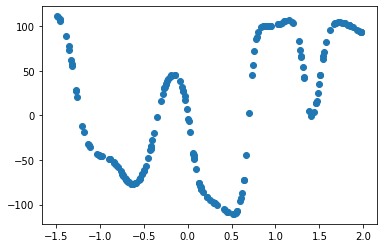

In [31]:
trainlossesDefault = nn.losses
vallossesDefault = nn.vallosses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [32]:
MSE(y_pred.flatten(), Y_test)

165.82456736542156

## With weight regularization and early-stopping

In [33]:
nn = NeuralNetwork(1,[100,1],["sigmoid","linear"],["uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.001,lmbda=0.001,with_regularization=True,early_stopping=True)

In [34]:
nn.fit(X_train.copy(), Y_train.copy(),val=(X_test.copy(),Y_test.copy()),target=70,epochs = 50000, batch_size = 10)

Epoch 1/50000 - loss: 5786.808797607714
Validation loss: 5274.404930099139
Epoch 2/50000 - loss: 5470.96668240321
Epoch 3/50000 - loss: 5229.649458765487
Epoch 4/50000 - loss: 5347.4952198378505
Epoch 5/50000 - loss: 5174.0523579060955
Epoch 6/50000 - loss: 4900.109480030109
Epoch 7/50000 - loss: 4636.705395734345
Epoch 8/50000 - loss: 4267.007574444274
Epoch 9/50000 - loss: 4433.100595384904
Epoch 10/50000 - loss: 4060.419340430168
Epoch 11/50000 - loss: 4031.9422345611615
Epoch 12/50000 - loss: 4015.818760572224
Epoch 13/50000 - loss: 3995.474106049249
Epoch 14/50000 - loss: 3825.3992182938746
Epoch 15/50000 - loss: 3788.821458545973
Epoch 16/50000 - loss: 3828.0153261612577
Epoch 17/50000 - loss: 3683.5498757208966
Epoch 18/50000 - loss: 3668.7724206677412
Epoch 19/50000 - loss: 3499.426322909043
Epoch 20/50000 - loss: 3493.5063895802255
Epoch 21/50000 - loss: 3438.024181139123
Epoch 22/50000 - loss: 3408.028699103842
Epoch 23/50000 - loss: 3291.3815544802383
Epoch 24/50000 - loss: 

Epoch 215/50000 - loss: 979.4864947748141
Epoch 216/50000 - loss: 983.5427016639708
Epoch 217/50000 - loss: 978.3454753687881
Epoch 218/50000 - loss: 989.6927779140849
Epoch 219/50000 - loss: 991.2834247125736
Epoch 220/50000 - loss: 982.1968871082784
Epoch 221/50000 - loss: 973.2911604544508
Epoch 222/50000 - loss: 989.9144375757096
Epoch 223/50000 - loss: 964.4120849441975
Epoch 224/50000 - loss: 958.6921833345507
Epoch 225/50000 - loss: 974.9402325937803
Epoch 226/50000 - loss: 975.9644274069866
Epoch 227/50000 - loss: 963.6294512335305
Epoch 228/50000 - loss: 979.8930798339445
Epoch 229/50000 - loss: 963.1716995565199
Epoch 230/50000 - loss: 985.256140606691
Epoch 231/50000 - loss: 960.9412582459399
Epoch 232/50000 - loss: 972.2630785417508
Epoch 233/50000 - loss: 963.6985174411627
Epoch 234/50000 - loss: 969.0044161476013
Epoch 235/50000 - loss: 959.8866571859993
Epoch 236/50000 - loss: 973.1799087943748
Epoch 237/50000 - loss: 966.8590462899747
Epoch 238/50000 - loss: 961.1901806

Epoch 431/50000 - loss: 858.2870590908315
Epoch 432/50000 - loss: 855.4523830411069
Epoch 433/50000 - loss: 867.5741117540416
Epoch 434/50000 - loss: 875.5832156307264
Epoch 435/50000 - loss: 858.9371626370454
Epoch 436/50000 - loss: 851.9466141340447
Epoch 437/50000 - loss: 864.6651014072934
Epoch 438/50000 - loss: 861.8665541087648
Epoch 439/50000 - loss: 857.9625645206922
Epoch 440/50000 - loss: 865.644791478451
Epoch 441/50000 - loss: 859.4399317703137
Epoch 442/50000 - loss: 856.1377690521946
Epoch 443/50000 - loss: 853.0798090562791
Epoch 444/50000 - loss: 864.5648649239007
Epoch 445/50000 - loss: 842.3379179096613
Epoch 446/50000 - loss: 860.7138275348391
Epoch 447/50000 - loss: 849.7017272155648
Epoch 448/50000 - loss: 867.5487195415305
Epoch 449/50000 - loss: 839.9359899091784
Epoch 450/50000 - loss: 844.0388097889212
Epoch 451/50000 - loss: 851.5701379533344
Epoch 452/50000 - loss: 861.146651539834
Epoch 453/50000 - loss: 857.7871016819203
Epoch 454/50000 - loss: 849.48458079

Epoch 649/50000 - loss: 760.6173836761703
Epoch 650/50000 - loss: 747.0497110565444
Epoch 651/50000 - loss: 754.0605544688912
Epoch 652/50000 - loss: 746.4679385102136
Epoch 653/50000 - loss: 761.7884456899117
Epoch 654/50000 - loss: 762.8706713664843
Epoch 655/50000 - loss: 753.1234054279372
Epoch 656/50000 - loss: 758.9899134375567
Epoch 657/50000 - loss: 752.8540489460067
Epoch 658/50000 - loss: 748.3091084620962
Epoch 659/50000 - loss: 757.652730145365
Epoch 660/50000 - loss: 761.6951704895476
Epoch 661/50000 - loss: 745.3859945429965
Epoch 662/50000 - loss: 755.2475299621223
Epoch 663/50000 - loss: 752.2639661455671
Epoch 664/50000 - loss: 759.2536623388281
Epoch 665/50000 - loss: 744.1807925488677
Epoch 666/50000 - loss: 742.8232595071207
Epoch 667/50000 - loss: 741.4320968924062
Epoch 668/50000 - loss: 760.2415580180926
Epoch 669/50000 - loss: 749.8298178632833
Epoch 670/50000 - loss: 748.8991631464044
Epoch 671/50000 - loss: 750.4358141933106
Epoch 672/50000 - loss: 738.6296820

Epoch 864/50000 - loss: 684.6121330691724
Epoch 865/50000 - loss: 681.1533939258774
Epoch 866/50000 - loss: 681.1130444806602
Epoch 867/50000 - loss: 678.5133684348159
Epoch 868/50000 - loss: 675.1046670798349
Epoch 869/50000 - loss: 680.4548305610306
Epoch 870/50000 - loss: 685.4617054405971
Epoch 871/50000 - loss: 671.7084634897556
Epoch 872/50000 - loss: 673.1428070216738
Epoch 873/50000 - loss: 674.6685984619039
Epoch 874/50000 - loss: 675.0140151698745
Epoch 875/50000 - loss: 681.5382929495279
Epoch 876/50000 - loss: 674.7129693106675
Epoch 877/50000 - loss: 659.2962310245055
Epoch 878/50000 - loss: 656.9200899753862
Epoch 879/50000 - loss: 646.9054380400324
Epoch 880/50000 - loss: 659.4921802714689
Epoch 881/50000 - loss: 649.4784457001685
Epoch 882/50000 - loss: 639.1047050744111
Epoch 883/50000 - loss: 633.1871715546422
Epoch 884/50000 - loss: 629.8062190954467
Epoch 885/50000 - loss: 620.7102625206172
Epoch 886/50000 - loss: 619.0802405836719
Epoch 887/50000 - loss: 615.346733

Epoch 1065/50000 - loss: 190.39529295657755
Epoch 1066/50000 - loss: 185.18716891797766
Epoch 1067/50000 - loss: 186.18252152526574
Epoch 1068/50000 - loss: 184.05793776243792
Epoch 1069/50000 - loss: 182.9676742137573
Epoch 1070/50000 - loss: 180.92291097841243
Epoch 1071/50000 - loss: 179.15089252799538
Epoch 1072/50000 - loss: 181.04895966819038
Epoch 1073/50000 - loss: 180.54421565357734
Epoch 1074/50000 - loss: 177.26662393106784
Epoch 1075/50000 - loss: 177.17543938451132
Epoch 1076/50000 - loss: 173.44485012220204
Epoch 1077/50000 - loss: 173.4132630548147
Epoch 1078/50000 - loss: 176.10208367224894
Epoch 1079/50000 - loss: 171.6993371037296
Epoch 1080/50000 - loss: 171.58179083847506
Epoch 1081/50000 - loss: 169.49972852924105
Epoch 1082/50000 - loss: 169.1336117964061
Epoch 1083/50000 - loss: 168.4146728907765
Epoch 1084/50000 - loss: 165.67611285652646
Epoch 1085/50000 - loss: 165.60369251223554
Epoch 1086/50000 - loss: 163.79233653418913
Epoch 1087/50000 - loss: 163.20181805

Epoch 1263/50000 - loss: 65.63786300454413
Epoch 1264/50000 - loss: 64.1890595767917
Epoch 1265/50000 - loss: 62.984175584577805
Epoch 1266/50000 - loss: 62.92971107275579
Epoch 1267/50000 - loss: 63.06478620542269
Epoch 1268/50000 - loss: 62.02591671574652
Epoch 1269/50000 - loss: 63.01311899751039
Epoch 1270/50000 - loss: 63.44111317181607
Epoch 1271/50000 - loss: 61.2779495013733
Epoch 1272/50000 - loss: 61.26663556477812
Epoch 1273/50000 - loss: 61.511087502815585
Epoch 1274/50000 - loss: 61.03747434705544
Epoch 1275/50000 - loss: 62.444723310294265
Epoch 1276/50000 - loss: 60.86934931825469
Epoch 1277/50000 - loss: 62.08914904424728
Epoch 1278/50000 - loss: 61.10929251802638
Epoch 1279/50000 - loss: 59.868521750276116
Epoch 1280/50000 - loss: 60.56846904402539
Epoch 1281/50000 - loss: 61.295466930770566
Epoch 1282/50000 - loss: 59.46620677362629
Epoch 1283/50000 - loss: 59.71032547129937
Epoch 1284/50000 - loss: 59.166153500194774
Epoch 1285/50000 - loss: 59.45524872452565
Epoch 1

Epoch 1460/50000 - loss: 34.912051253396534
Epoch 1461/50000 - loss: 35.28380412603026
Epoch 1462/50000 - loss: 34.414809511172294
Epoch 1463/50000 - loss: 34.9829191738534
Epoch 1464/50000 - loss: 35.16090909171681
Epoch 1465/50000 - loss: 34.907841259907784
Epoch 1466/50000 - loss: 34.433479875579636
Epoch 1467/50000 - loss: 35.06789548283143
Epoch 1468/50000 - loss: 34.14734898082895
Epoch 1469/50000 - loss: 34.6288729443462
Epoch 1470/50000 - loss: 34.43726524036979
Epoch 1471/50000 - loss: 33.77447411920658
Epoch 1472/50000 - loss: 34.38827258705203
Epoch 1473/50000 - loss: 34.26049830715311
Epoch 1474/50000 - loss: 33.83475213346384
Epoch 1475/50000 - loss: 34.55148555190808
Epoch 1476/50000 - loss: 33.580580059676585
Epoch 1477/50000 - loss: 33.496381376987
Epoch 1478/50000 - loss: 34.10437911735471
Epoch 1479/50000 - loss: 34.904019800903804
Epoch 1480/50000 - loss: 33.88550268788423
Epoch 1481/50000 - loss: 33.43318056561336
Epoch 1482/50000 - loss: 33.60409065926046
Epoch 148

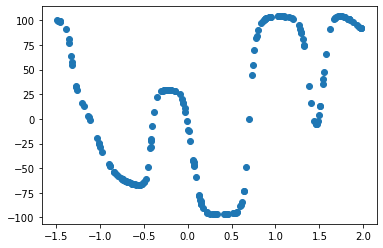

In [35]:
trainlossesBoth = nn.losses
vallossesBoth = nn.vallosses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [36]:
MSE(y_pred.flatten(), Y_test)

68.38428457907997

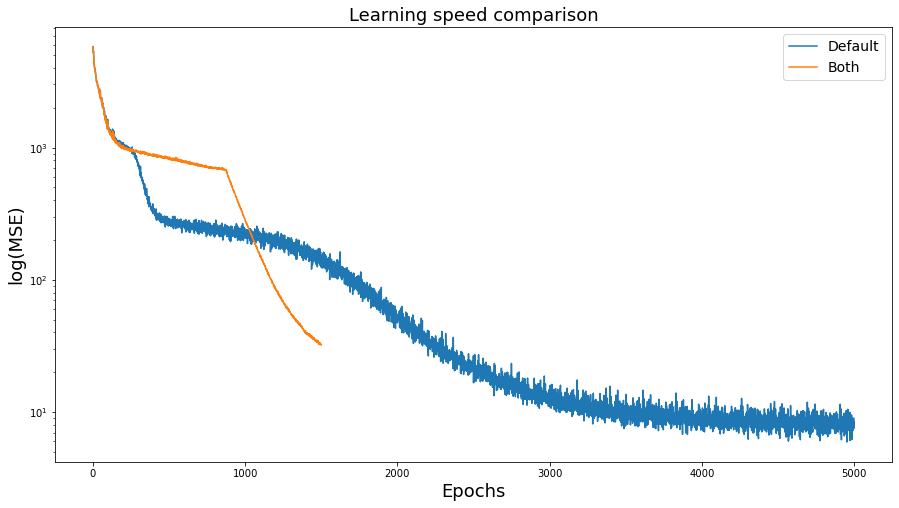

In [37]:
plt.figure(figsize=(15,8))
plt.plot(trainlossesDefault,label="Default")
plt.plot(trainlossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

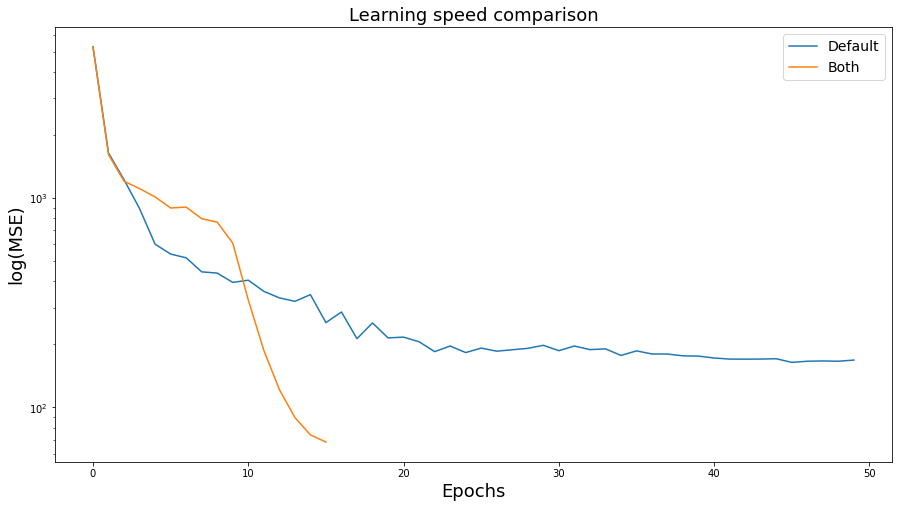

In [38]:
plt.figure(figsize=(15,8))
plt.plot(vallossesDefault,label="Default")
plt.plot(vallossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

# rings5-sparse

In [3]:
train_df = pd.read_csv("data/rings5-sparse-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/rings5-sparse-test.csv",index_col=0).reset_index()

In [437]:
X_train = np.reshape(train_df[["x","y"]].values,(len(train_df),2))
Y_train = np.reshape(train_df["c"].values,(len(train_df),1))

In [438]:
X_test = np.reshape(test_df[["x","y"]].values,(len(test_df),2))
Y_test = np.reshape(test_df["c"].values,(len(test_df),1))

In [439]:
y_train = makey_rings5(Y_train)
y_test = makey_rings5(Y_test)

In [440]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Default

In [443]:
nn = NeuralNetwork(2,[20,20,5],["sigmoid","sigmoid","softmax"],["uniform","uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.01,with_regularization=False,early_stopping=False)

In [444]:
nn.fit(X_train_std.copy(), y_train.copy(),val=(X_test_std.copy(),y_test.copy()), epochs = 2000, batch_size = 32)

Epoch 1/2000 - loss: 2.9816963772090763
Validation loss: 2.895846672502295
Epoch 2/2000 - loss: 2.9624565853603144
Epoch 3/2000 - loss: 2.9629576745579116
Epoch 4/2000 - loss: 2.9687346745950984
Epoch 5/2000 - loss: 2.9389950941997367
Epoch 6/2000 - loss: 2.931688972043716
Epoch 7/2000 - loss: 2.9617674649633408
Epoch 8/2000 - loss: 2.9291563595010457
Epoch 9/2000 - loss: 2.963007655692312
Epoch 10/2000 - loss: 2.951328555226293
Epoch 11/2000 - loss: 2.971680804570046
Epoch 12/2000 - loss: 2.969989739914171
Epoch 13/2000 - loss: 2.9695386608947674
Epoch 14/2000 - loss: 2.9531580917862588
Epoch 15/2000 - loss: 2.9564837468231597
Epoch 16/2000 - loss: 2.9498494613998654
Epoch 17/2000 - loss: 2.955666826958333
Epoch 18/2000 - loss: 2.9408839384784096
Epoch 19/2000 - loss: 2.966336513049168
Epoch 20/2000 - loss: 2.9667142962977797
Epoch 21/2000 - loss: 2.948247232209519
Epoch 22/2000 - loss: 2.952248464511846
Epoch 23/2000 - loss: 2.9506374215519697
Epoch 24/2000 - loss: 2.957512948649536


Epoch 200/2000 - loss: 2.852072747300395
Epoch 201/2000 - loss: 2.8775028821608184
Validation loss: 2.80262454832248
Epoch 202/2000 - loss: 2.8933251407945053
Epoch 203/2000 - loss: 2.8982718561277325
Epoch 204/2000 - loss: 2.893567884227024
Epoch 205/2000 - loss: 2.8912759813120927
Epoch 206/2000 - loss: 2.8948991942194606
Epoch 207/2000 - loss: 2.8626611819822956
Epoch 208/2000 - loss: 2.868640646810142
Epoch 209/2000 - loss: 2.8756554379849066
Epoch 210/2000 - loss: 2.881259689959805
Epoch 211/2000 - loss: 2.8951964543103115
Epoch 212/2000 - loss: 2.8816994849928705
Epoch 213/2000 - loss: 2.903794636786865
Epoch 214/2000 - loss: 2.884307340911603
Epoch 215/2000 - loss: 2.891787646373918
Epoch 216/2000 - loss: 2.8424993084507317
Epoch 217/2000 - loss: 2.8898849594784504
Epoch 218/2000 - loss: 2.9002595119980428
Epoch 219/2000 - loss: 2.8702899277672773
Epoch 220/2000 - loss: 2.885241814596826
Epoch 221/2000 - loss: 2.880979935358169
Epoch 222/2000 - loss: 2.7913737836772805
Epoch 223

Epoch 398/2000 - loss: 2.38277816228322
Epoch 399/2000 - loss: 2.351395171140372
Epoch 400/2000 - loss: 2.3418728019899007
Epoch 401/2000 - loss: 2.338432869686828
Validation loss: 2.391778655433466
Epoch 402/2000 - loss: 2.370098695676297
Epoch 403/2000 - loss: 2.3556079995279253
Epoch 404/2000 - loss: 2.351227356616144
Epoch 405/2000 - loss: 2.373005241015537
Epoch 406/2000 - loss: 2.39114623159195
Epoch 407/2000 - loss: 2.3579169620625717
Epoch 408/2000 - loss: 2.3747495457223557
Epoch 409/2000 - loss: 2.3517852124604524
Epoch 410/2000 - loss: 2.3596085451207
Epoch 411/2000 - loss: 2.348608188970982
Epoch 412/2000 - loss: 2.3840078230846555
Epoch 413/2000 - loss: 2.3307229051459437
Epoch 414/2000 - loss: 2.3640780249372724
Epoch 415/2000 - loss: 2.215730742467983
Epoch 416/2000 - loss: 2.327037087230186
Epoch 417/2000 - loss: 2.3392766287615703
Epoch 418/2000 - loss: 2.332980901918416
Epoch 419/2000 - loss: 2.3588694814635236
Epoch 420/2000 - loss: 2.3571385233144477
Epoch 421/2000 

Epoch 601/2000 - loss: 2.2386921778035513
Validation loss: 2.3050016244111426
Epoch 602/2000 - loss: 2.23759156748421
Epoch 603/2000 - loss: 2.2248297817818514
Epoch 604/2000 - loss: 2.228780304320926
Epoch 605/2000 - loss: 2.2435024876673504
Epoch 606/2000 - loss: 2.201819700990842
Epoch 607/2000 - loss: 2.2520373187558818
Epoch 608/2000 - loss: 2.2064251389597067
Epoch 609/2000 - loss: 2.2721919307860055
Epoch 610/2000 - loss: 2.25016236491254
Epoch 611/2000 - loss: 2.2230873061849543
Epoch 612/2000 - loss: 2.2285679299690533
Epoch 613/2000 - loss: 2.2504690697099257
Epoch 614/2000 - loss: 2.2781141382396974
Epoch 615/2000 - loss: 2.2362077025576754
Epoch 616/2000 - loss: 2.237758801828936
Epoch 617/2000 - loss: 2.233947970227928
Epoch 618/2000 - loss: 2.2315831161632436
Epoch 619/2000 - loss: 2.247526958989001
Epoch 620/2000 - loss: 2.2140608160923976
Epoch 621/2000 - loss: 2.2307207519341237
Epoch 622/2000 - loss: 2.2306356986310556
Epoch 623/2000 - loss: 2.235378102703192
Epoch 62

Epoch 797/2000 - loss: 2.1275397012646255
Epoch 798/2000 - loss: 2.0926870682561356
Epoch 799/2000 - loss: 2.1057705673199547
Epoch 800/2000 - loss: 2.1091851181056485
Epoch 801/2000 - loss: 2.1325235362896304
Validation loss: 2.213999438954063
Epoch 802/2000 - loss: 2.101805983483384
Epoch 803/2000 - loss: 2.122818482259556
Epoch 804/2000 - loss: 2.142714201840516
Epoch 805/2000 - loss: 2.1138485928514656
Epoch 806/2000 - loss: 2.1086085770928436
Epoch 807/2000 - loss: 2.137849029222117
Epoch 808/2000 - loss: 2.135914963442964
Epoch 809/2000 - loss: 2.0768099119882253
Epoch 810/2000 - loss: 2.1171681456985154
Epoch 811/2000 - loss: 2.1098755648993266
Epoch 812/2000 - loss: 2.100190918501808
Epoch 813/2000 - loss: 2.1079347480256363
Epoch 814/2000 - loss: 2.1015663740907473
Epoch 815/2000 - loss: 2.1146982087103114
Epoch 816/2000 - loss: 2.0833901266110417
Epoch 817/2000 - loss: 2.095879371251455
Epoch 818/2000 - loss: 2.112590561936688
Epoch 819/2000 - loss: 2.1239014423104137
Epoch 8

Epoch 997/2000 - loss: 1.6625638708251391
Epoch 998/2000 - loss: 1.6700590003425764
Epoch 999/2000 - loss: 1.6268192500651848
Epoch 1000/2000 - loss: 1.6270358908252256
Epoch 1001/2000 - loss: 1.6543229224694305
Validation loss: 1.7670530912021305
Epoch 1002/2000 - loss: 1.650894724205449
Epoch 1003/2000 - loss: 1.6349323086990049
Epoch 1004/2000 - loss: 1.6241494779395835
Epoch 1005/2000 - loss: 1.6281487658511813
Epoch 1006/2000 - loss: 1.637939039867838
Epoch 1007/2000 - loss: 1.6546673605746467
Epoch 1008/2000 - loss: 1.640863293249274
Epoch 1009/2000 - loss: 1.6429217905351239
Epoch 1010/2000 - loss: 1.62616158070285
Epoch 1011/2000 - loss: 1.6350100592207641
Epoch 1012/2000 - loss: 1.6207392895488486
Epoch 1013/2000 - loss: 1.632567274830955
Epoch 1014/2000 - loss: 1.6377653096878084
Epoch 1015/2000 - loss: 1.6222821048297147
Epoch 1016/2000 - loss: 1.5888937795907718
Epoch 1017/2000 - loss: 1.5998945279663204
Epoch 1018/2000 - loss: 1.6199622781296894
Epoch 1019/2000 - loss: 1.5

Epoch 1189/2000 - loss: 1.1430273985163413
Epoch 1190/2000 - loss: 1.154554793129856
Epoch 1191/2000 - loss: 1.1473333524968412
Epoch 1192/2000 - loss: 1.1622043027866762
Epoch 1193/2000 - loss: 1.1284918346977797
Epoch 1194/2000 - loss: 1.1411961890311326
Epoch 1195/2000 - loss: 1.1508799535796888
Epoch 1196/2000 - loss: 1.1426773316035925
Epoch 1197/2000 - loss: 1.1234743315604383
Epoch 1198/2000 - loss: 1.1316165353151428
Epoch 1199/2000 - loss: 1.144912666315818
Epoch 1200/2000 - loss: 1.1188757383353656
Epoch 1201/2000 - loss: 1.1474522432465466
Validation loss: 1.4264518537570103
Epoch 1202/2000 - loss: 1.139982757854547
Epoch 1203/2000 - loss: 1.1182646494068422
Epoch 1204/2000 - loss: 1.1288185967081823
Epoch 1205/2000 - loss: 1.1232019663260375
Epoch 1206/2000 - loss: 1.1478380776754422
Epoch 1207/2000 - loss: 1.1210471434282183
Epoch 1208/2000 - loss: 1.1276884426212772
Epoch 1209/2000 - loss: 1.136006840660622
Epoch 1210/2000 - loss: 1.1273440814659084
Epoch 1211/2000 - loss

Epoch 1380/2000 - loss: 0.8716887849465504
Epoch 1381/2000 - loss: 0.8847010878085901
Epoch 1382/2000 - loss: 0.88345111307154
Epoch 1383/2000 - loss: 0.8642818502442499
Epoch 1384/2000 - loss: 0.8816261038897237
Epoch 1385/2000 - loss: 0.881262061375032
Epoch 1386/2000 - loss: 0.874381609688588
Epoch 1387/2000 - loss: 0.8748653828382135
Epoch 1388/2000 - loss: 0.8849786710219533
Epoch 1389/2000 - loss: 0.8805500870377636
Epoch 1390/2000 - loss: 0.8720206163279486
Epoch 1391/2000 - loss: 0.877025974474413
Epoch 1392/2000 - loss: 0.8776703975882703
Epoch 1393/2000 - loss: 0.8411213080658335
Epoch 1394/2000 - loss: 0.8661659342140322
Epoch 1395/2000 - loss: 0.8821825809623408
Epoch 1396/2000 - loss: 0.883707475004592
Epoch 1397/2000 - loss: 0.8555617750629005
Epoch 1398/2000 - loss: 0.8536245827601803
Epoch 1399/2000 - loss: 0.8549068665188453
Epoch 1400/2000 - loss: 0.8691746402066433
Epoch 1401/2000 - loss: 0.8594195636937703
Validation loss: 1.266245095820698
Epoch 1402/2000 - loss: 0

Epoch 1570/2000 - loss: 0.7012517970793979
Epoch 1571/2000 - loss: 0.693728212175528
Epoch 1572/2000 - loss: 0.7073874681559473
Epoch 1573/2000 - loss: 0.6878103196993186
Epoch 1574/2000 - loss: 0.7040451755357505
Epoch 1575/2000 - loss: 0.6931943834485707
Epoch 1576/2000 - loss: 0.6911728505232393
Epoch 1577/2000 - loss: 0.6804990723290891
Epoch 1578/2000 - loss: 0.7010834524202981
Epoch 1579/2000 - loss: 0.6886624881437501
Epoch 1580/2000 - loss: 0.6883196211820883
Epoch 1581/2000 - loss: 0.6938555688703596
Epoch 1582/2000 - loss: 0.6854941383049493
Epoch 1583/2000 - loss: 0.6915331420027848
Epoch 1584/2000 - loss: 0.6875200070648216
Epoch 1585/2000 - loss: 0.6920168826041319
Epoch 1586/2000 - loss: 0.6870302670591683
Epoch 1587/2000 - loss: 0.6742242064580203
Epoch 1588/2000 - loss: 0.6895457199343663
Epoch 1589/2000 - loss: 0.6639469169755271
Epoch 1590/2000 - loss: 0.6938791423214322
Epoch 1591/2000 - loss: 0.6974317252907768
Epoch 1592/2000 - loss: 0.6625293237229675
Epoch 1593/2

Epoch 1762/2000 - loss: 0.5841857963499527
Epoch 1763/2000 - loss: 0.569119641994741
Epoch 1764/2000 - loss: 0.5745687849129588
Epoch 1765/2000 - loss: 0.5624347049318738
Epoch 1766/2000 - loss: 0.5818565770983962
Epoch 1767/2000 - loss: 0.5717166609668349
Epoch 1768/2000 - loss: 0.5691324179131243
Epoch 1769/2000 - loss: 0.5795153840588436
Epoch 1770/2000 - loss: 0.5668697959289503
Epoch 1771/2000 - loss: 0.5698422616981584
Epoch 1772/2000 - loss: 0.5735351635267637
Epoch 1773/2000 - loss: 0.5749522077816334
Epoch 1774/2000 - loss: 0.5625866134998331
Epoch 1775/2000 - loss: 0.568578994204072
Epoch 1776/2000 - loss: 0.5689912267411763
Epoch 1777/2000 - loss: 0.574609806839471
Epoch 1778/2000 - loss: 0.5866145671259027
Epoch 1779/2000 - loss: 0.5716751308739684
Epoch 1780/2000 - loss: 0.574096854883129
Epoch 1781/2000 - loss: 0.5623395272232785
Epoch 1782/2000 - loss: 0.5648466911444422
Epoch 1783/2000 - loss: 0.5707299911071386
Epoch 1784/2000 - loss: 0.5633814825506399
Epoch 1785/2000

Epoch 1955/2000 - loss: 0.4996661692846722
Epoch 1956/2000 - loss: 0.49068831383124767
Epoch 1957/2000 - loss: 0.4943787465993437
Epoch 1958/2000 - loss: 0.49190236441148827
Epoch 1959/2000 - loss: 0.49138643792949155
Epoch 1960/2000 - loss: 0.4835835952413744
Epoch 1961/2000 - loss: 0.4895107945584455
Epoch 1962/2000 - loss: 0.48848206422511103
Epoch 1963/2000 - loss: 0.4923913041407793
Epoch 1964/2000 - loss: 0.4747195725028926
Epoch 1965/2000 - loss: 0.4805268323416248
Epoch 1966/2000 - loss: 0.4871374469777705
Epoch 1967/2000 - loss: 0.48959072072545146
Epoch 1968/2000 - loss: 0.4856912651394037
Epoch 1969/2000 - loss: 0.49183092769347986
Epoch 1970/2000 - loss: 0.49298776185039184
Epoch 1971/2000 - loss: 0.49960496575594243
Epoch 1972/2000 - loss: 0.488502148760367
Epoch 1973/2000 - loss: 0.48138741922145195
Epoch 1974/2000 - loss: 0.48264435204603434
Epoch 1975/2000 - loss: 0.49650730081611083
Epoch 1976/2000 - loss: 0.4966377692923819
Epoch 1977/2000 - loss: 0.48391559863915945


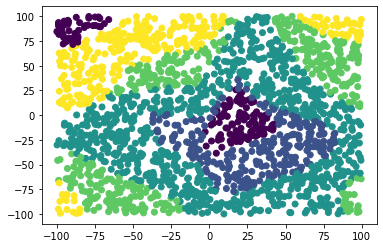

In [445]:
trainlossesDefault = nn.losses
vallossesDefault = nn.vallosses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

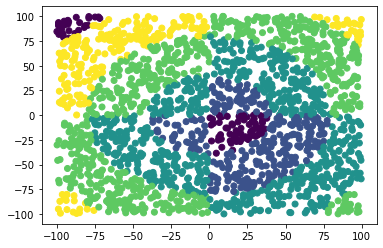

In [446]:
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

In [447]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.7784375074265576

## With weight regularization and early-stopping

In [456]:
nn = NeuralNetwork(2,[20,20,5],["sigmoid","sigmoid","softmax"],["uniform","uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.001,lmbda=0.0001,with_regularization=True,early_stopping=True)

In [457]:
nn.fit(X_train_std.copy(), y_train.copy(),val=(X_test_std.copy(),y_test.copy()),target=1.2, epochs = 20000, batch_size = 32)

Epoch 1/20000 - loss: 2.950766702974781
Validation loss: 3.069838181644984
Epoch 2/20000 - loss: 2.950524590839393
Epoch 3/20000 - loss: 2.951974039367775
Epoch 4/20000 - loss: 2.954117658771287
Epoch 5/20000 - loss: 2.952706061916625
Epoch 6/20000 - loss: 2.9506593430444
Epoch 7/20000 - loss: 2.954066795426418
Epoch 8/20000 - loss: 2.9517675459845294
Epoch 9/20000 - loss: 2.9534920725394924
Epoch 10/20000 - loss: 2.953252824037796
Epoch 11/20000 - loss: 2.953667288643955
Epoch 12/20000 - loss: 2.9540261265707404
Epoch 13/20000 - loss: 2.95467304059894
Epoch 14/20000 - loss: 2.952478748849491
Epoch 15/20000 - loss: 2.954230691503648
Epoch 16/20000 - loss: 2.9539068289035275
Epoch 17/20000 - loss: 2.953010520157184
Epoch 18/20000 - loss: 2.954124528471711
Epoch 19/20000 - loss: 2.9554232718654974
Epoch 20/20000 - loss: 2.9541844719706654
Epoch 21/20000 - loss: 2.954428345715164
Epoch 22/20000 - loss: 2.9542702142393154
Epoch 23/20000 - loss: 2.9550547120574864
Epoch 24/20000 - loss: 2.9

Epoch 197/20000 - loss: 2.9074253242497985
Epoch 198/20000 - loss: 2.907711183948097
Epoch 199/20000 - loss: 2.9069411091238098
Epoch 200/20000 - loss: 2.9061332294139812
Epoch 201/20000 - loss: 2.904488103468942
Validation loss: 2.911443662532537
Epoch 202/20000 - loss: 2.905070962357979
Epoch 203/20000 - loss: 2.9049377814249926
Epoch 204/20000 - loss: 2.903342434149871
Epoch 205/20000 - loss: 2.9028475674952627
Epoch 206/20000 - loss: 2.902892942718946
Epoch 207/20000 - loss: 2.901090165831273
Epoch 208/20000 - loss: 2.9018041222820914
Epoch 209/20000 - loss: 2.900802794022164
Epoch 210/20000 - loss: 2.9005736252449728
Epoch 211/20000 - loss: 2.8987751667260016
Epoch 212/20000 - loss: 2.8985784273226307
Epoch 213/20000 - loss: 2.898719297483521
Epoch 214/20000 - loss: 2.8970008363247284
Epoch 215/20000 - loss: 2.8967001159544936
Epoch 216/20000 - loss: 2.8952219570648885
Epoch 217/20000 - loss: 2.894639112664044
Epoch 218/20000 - loss: 2.8946768968023435
Epoch 219/20000 - loss: 2.89

Epoch 389/20000 - loss: 2.685294024624021
Epoch 390/20000 - loss: 2.6852138566815813
Epoch 391/20000 - loss: 2.684227066512864
Epoch 392/20000 - loss: 2.6822026940448813
Epoch 393/20000 - loss: 2.684092720148018
Epoch 394/20000 - loss: 2.6821457264944173
Epoch 395/20000 - loss: 2.6803359186161195
Epoch 396/20000 - loss: 2.6773222338468177
Epoch 397/20000 - loss: 2.678729960293279
Epoch 398/20000 - loss: 2.6767182604455613
Epoch 399/20000 - loss: 2.6790723797812954
Epoch 400/20000 - loss: 2.676422166141683
Epoch 401/20000 - loss: 2.672695028968861
Validation loss: 2.7252745605309747
Epoch 402/20000 - loss: 2.671864132116697
Epoch 403/20000 - loss: 2.6705044930279773
Epoch 404/20000 - loss: 2.6710675803381454
Epoch 405/20000 - loss: 2.6702851012334308
Epoch 406/20000 - loss: 2.670456654232097
Epoch 407/20000 - loss: 2.668924387383366
Epoch 408/20000 - loss: 2.6697796730434002
Epoch 409/20000 - loss: 2.6665569338050803
Epoch 410/20000 - loss: 2.666181324015642
Epoch 411/20000 - loss: 2.66

Epoch 771/20000 - loss: 2.5237310801177677
Epoch 772/20000 - loss: 2.524647167596709
Epoch 773/20000 - loss: 2.523540442147226
Epoch 774/20000 - loss: 2.521743004196443
Epoch 775/20000 - loss: 2.521242797239718
Epoch 776/20000 - loss: 2.5206839372631205
Epoch 777/20000 - loss: 2.5223717359937905
Epoch 778/20000 - loss: 2.521807947654213
Epoch 779/20000 - loss: 2.5204575020199265
Epoch 780/20000 - loss: 2.5214999751635965
Epoch 781/20000 - loss: 2.520840462617022
Epoch 782/20000 - loss: 2.5186781821409903
Epoch 783/20000 - loss: 2.5196093166479625
Epoch 784/20000 - loss: 2.5199037159632427
Epoch 785/20000 - loss: 2.520440779960624
Epoch 786/20000 - loss: 2.520129485568379
Epoch 787/20000 - loss: 2.5187054270671134
Epoch 788/20000 - loss: 2.516243936020992
Epoch 789/20000 - loss: 2.5160486722984925
Epoch 790/20000 - loss: 2.5179693847446565
Epoch 791/20000 - loss: 2.516024767236554
Epoch 792/20000 - loss: 2.5172280948842696
Epoch 793/20000 - loss: 2.5169917545858254
Epoch 794/20000 - los

Epoch 963/20000 - loss: 2.4532836232258326
Epoch 964/20000 - loss: 2.4522221773786796
Epoch 965/20000 - loss: 2.4516337073800343
Epoch 966/20000 - loss: 2.4515203838264146
Epoch 967/20000 - loss: 2.4517131235316203
Epoch 968/20000 - loss: 2.4510174455534353
Epoch 969/20000 - loss: 2.451388652064902
Epoch 970/20000 - loss: 2.4509363091806646
Epoch 971/20000 - loss: 2.4502196487664496
Epoch 972/20000 - loss: 2.450415287275575
Epoch 973/20000 - loss: 2.4493214848174447
Epoch 974/20000 - loss: 2.449681059967949
Epoch 975/20000 - loss: 2.4490056555369577
Epoch 976/20000 - loss: 2.4476852085314023
Epoch 977/20000 - loss: 2.446290750197103
Epoch 978/20000 - loss: 2.4468757139116817
Epoch 979/20000 - loss: 2.445725161082746
Epoch 980/20000 - loss: 2.4482630254645303
Epoch 981/20000 - loss: 2.447077330531023
Epoch 982/20000 - loss: 2.446075078073698
Epoch 983/20000 - loss: 2.4440031918467264
Epoch 984/20000 - loss: 2.4423837870147658
Epoch 985/20000 - loss: 2.4447749228207627
Epoch 986/20000 - 

Epoch 1154/20000 - loss: 2.361577690253838
Epoch 1155/20000 - loss: 2.362772736469593
Epoch 1156/20000 - loss: 2.360919825579372
Epoch 1157/20000 - loss: 2.3603664772778306
Epoch 1158/20000 - loss: 2.359727433147756
Epoch 1159/20000 - loss: 2.359798515757217
Epoch 1160/20000 - loss: 2.360184250195593
Epoch 1161/20000 - loss: 2.3583975025185087
Epoch 1162/20000 - loss: 2.362057398522944
Epoch 1163/20000 - loss: 2.3567228526786077
Epoch 1164/20000 - loss: 2.3563377397100798
Epoch 1165/20000 - loss: 2.3559066098720676
Epoch 1166/20000 - loss: 2.3557944049816255
Epoch 1167/20000 - loss: 2.3560391162512118
Epoch 1168/20000 - loss: 2.3545907011860354
Epoch 1169/20000 - loss: 2.354310565994707
Epoch 1170/20000 - loss: 2.352649755282808
Epoch 1171/20000 - loss: 2.353310805992792
Epoch 1172/20000 - loss: 2.3526576994803925
Epoch 1173/20000 - loss: 2.352252550431552
Epoch 1174/20000 - loss: 2.351405585049093
Epoch 1175/20000 - loss: 2.350578637759959
Epoch 1176/20000 - loss: 2.351768831037074
Ep

Epoch 1343/20000 - loss: 2.2613425361411563
Epoch 1344/20000 - loss: 2.26054424124592
Epoch 1345/20000 - loss: 2.260064819809931
Epoch 1346/20000 - loss: 2.2600071350867115
Epoch 1347/20000 - loss: 2.259294481172814
Epoch 1348/20000 - loss: 2.259083063790662
Epoch 1349/20000 - loss: 2.258017504914532
Epoch 1350/20000 - loss: 2.2569607980666015
Epoch 1351/20000 - loss: 2.2571988707785184
Epoch 1352/20000 - loss: 2.257205578871114
Epoch 1353/20000 - loss: 2.2565885427354817
Epoch 1354/20000 - loss: 2.2552655873723575
Epoch 1355/20000 - loss: 2.254610292200041
Epoch 1356/20000 - loss: 2.2548868359808076
Epoch 1357/20000 - loss: 2.253712630865804
Epoch 1358/20000 - loss: 2.2536770223503364
Epoch 1359/20000 - loss: 2.252839409689419
Epoch 1360/20000 - loss: 2.2530093868100316
Epoch 1361/20000 - loss: 2.2523148815831604
Epoch 1362/20000 - loss: 2.2510473373368325
Epoch 1363/20000 - loss: 2.249644626707183
Epoch 1364/20000 - loss: 2.2495134347349457
Epoch 1365/20000 - loss: 2.250849726769344


Epoch 1533/20000 - loss: 2.163699499978941
Epoch 1534/20000 - loss: 2.1634991650047715
Epoch 1535/20000 - loss: 2.1620229305971304
Epoch 1536/20000 - loss: 2.1617080281976033
Epoch 1537/20000 - loss: 2.161533573996553
Epoch 1538/20000 - loss: 2.16091210910228
Epoch 1539/20000 - loss: 2.1598051719530487
Epoch 1540/20000 - loss: 2.1599103305051637
Epoch 1541/20000 - loss: 2.159894376414497
Epoch 1542/20000 - loss: 2.1591097235687524
Epoch 1543/20000 - loss: 2.1583336793792185
Epoch 1544/20000 - loss: 2.1572078520281552
Epoch 1545/20000 - loss: 2.157586997508036
Epoch 1546/20000 - loss: 2.1562816487236716
Epoch 1547/20000 - loss: 2.155539077654792
Epoch 1548/20000 - loss: 2.1560883150982506
Epoch 1549/20000 - loss: 2.155239693022755
Epoch 1550/20000 - loss: 2.155141192851989
Epoch 1551/20000 - loss: 2.1544105779855363
Epoch 1552/20000 - loss: 2.154711866676316
Epoch 1553/20000 - loss: 2.153566297824847
Epoch 1554/20000 - loss: 2.1542452301615205
Epoch 1555/20000 - loss: 2.1528827814312486

Epoch 1722/20000 - loss: 2.0730025852718184
Epoch 1723/20000 - loss: 2.0725393229369686
Epoch 1724/20000 - loss: 2.0719322154597877
Epoch 1725/20000 - loss: 2.0715911618570977
Epoch 1726/20000 - loss: 2.0708615714359184
Epoch 1727/20000 - loss: 2.070730424078373
Epoch 1728/20000 - loss: 2.0707537058923156
Epoch 1729/20000 - loss: 2.0697164511574577
Epoch 1730/20000 - loss: 2.069037393102275
Epoch 1731/20000 - loss: 2.0696917336636
Epoch 1732/20000 - loss: 2.0693064981746976
Epoch 1733/20000 - loss: 2.068147720413118
Epoch 1734/20000 - loss: 2.068535393479621
Epoch 1735/20000 - loss: 2.0672283803809544
Epoch 1736/20000 - loss: 2.0667764362351546
Epoch 1737/20000 - loss: 2.0663600688165555
Epoch 1738/20000 - loss: 2.066374716830088
Epoch 1739/20000 - loss: 2.065544551189898
Epoch 1740/20000 - loss: 2.0654692964452908
Epoch 1741/20000 - loss: 2.0644625460915846
Epoch 1742/20000 - loss: 2.0636411104814645
Epoch 1743/20000 - loss: 2.065583969688066
Epoch 1744/20000 - loss: 2.062960305896294

Epoch 1910/20000 - loss: 1.99143033066714
Epoch 1911/20000 - loss: 1.9908839998743157
Epoch 1912/20000 - loss: 1.9897247228224384
Epoch 1913/20000 - loss: 1.990010153130046
Epoch 1914/20000 - loss: 1.9895386625642035
Epoch 1915/20000 - loss: 1.9887385345025446
Epoch 1916/20000 - loss: 1.9889503118508611
Epoch 1917/20000 - loss: 1.9881808626696131
Epoch 1918/20000 - loss: 1.9877716652881805
Epoch 1919/20000 - loss: 1.987317934540406
Epoch 1920/20000 - loss: 1.9877342055425862
Epoch 1921/20000 - loss: 1.987093571207729
Epoch 1922/20000 - loss: 1.9858410715665968
Epoch 1923/20000 - loss: 1.9861955278358183
Epoch 1924/20000 - loss: 1.9858854688307037
Epoch 1925/20000 - loss: 1.9846702457647252
Epoch 1926/20000 - loss: 1.9842023297956977
Epoch 1927/20000 - loss: 1.9839328455071077
Epoch 1928/20000 - loss: 1.984138582601973
Epoch 1929/20000 - loss: 1.9838654469015167
Epoch 1930/20000 - loss: 1.9827864936768835
Epoch 1931/20000 - loss: 1.982503374626372
Epoch 1932/20000 - loss: 1.982639631400

Epoch 2099/20000 - loss: 1.915036296165309
Epoch 2100/20000 - loss: 1.914378028218458
Epoch 2101/20000 - loss: 1.914245083677975
Validation loss: 2.0879206608932845
Epoch 2102/20000 - loss: 1.9133323129048225
Epoch 2103/20000 - loss: 1.913325881191874
Epoch 2104/20000 - loss: 1.9127690528271069
Epoch 2105/20000 - loss: 1.9133924933372972
Epoch 2106/20000 - loss: 1.9128158279223086
Epoch 2107/20000 - loss: 1.9119137405691962
Epoch 2108/20000 - loss: 1.911831983627133
Epoch 2109/20000 - loss: 1.912197710560708
Epoch 2110/20000 - loss: 1.9104763822656206
Epoch 2111/20000 - loss: 1.9100337365328357
Epoch 2112/20000 - loss: 1.9105840516182038
Epoch 2113/20000 - loss: 1.9098562725061552
Epoch 2114/20000 - loss: 1.909408996540593
Epoch 2115/20000 - loss: 1.909334579054431
Epoch 2116/20000 - loss: 1.9083016777659323
Epoch 2117/20000 - loss: 1.908354143995828
Epoch 2118/20000 - loss: 1.9075687518416073
Epoch 2119/20000 - loss: 1.9075293246674714
Epoch 2120/20000 - loss: 1.9074205730948763
Epoch

Epoch 2289/20000 - loss: 1.842886417059389
Epoch 2290/20000 - loss: 1.8423539426981876
Epoch 2291/20000 - loss: 1.842043582587481
Epoch 2292/20000 - loss: 1.8418683589374236
Epoch 2293/20000 - loss: 1.8408780532822375
Epoch 2294/20000 - loss: 1.8411685613468471
Epoch 2295/20000 - loss: 1.8411308527637713
Epoch 2296/20000 - loss: 1.8398921461724498
Epoch 2297/20000 - loss: 1.839984863727246
Epoch 2298/20000 - loss: 1.8399709755845925
Epoch 2299/20000 - loss: 1.8393353844231615
Epoch 2300/20000 - loss: 1.8385069446008315
Epoch 2301/20000 - loss: 1.8389131842202782
Validation loss: 2.0336139457656714
Epoch 2302/20000 - loss: 1.838211798531632
Epoch 2303/20000 - loss: 1.8365750095042201
Epoch 2304/20000 - loss: 1.8368692323285853
Epoch 2305/20000 - loss: 1.837017155823537
Epoch 2306/20000 - loss: 1.835860363389386
Epoch 2307/20000 - loss: 1.8362195181196206
Epoch 2308/20000 - loss: 1.8351676058151003
Epoch 2309/20000 - loss: 1.8350458627369002
Epoch 2310/20000 - loss: 1.8350290746392206
Ep

Epoch 2478/20000 - loss: 1.7732714194025099
Epoch 2479/20000 - loss: 1.7723894857010083
Epoch 2480/20000 - loss: 1.7719984916581244
Epoch 2481/20000 - loss: 1.7718388269655387
Epoch 2482/20000 - loss: 1.7706723025785644
Epoch 2483/20000 - loss: 1.7707095785648337
Epoch 2484/20000 - loss: 1.769769805117408
Epoch 2485/20000 - loss: 1.7688687811767982
Epoch 2486/20000 - loss: 1.769587171998595
Epoch 2487/20000 - loss: 1.7697326886760307
Epoch 2488/20000 - loss: 1.7685271210377336
Epoch 2489/20000 - loss: 1.7678189925354018
Epoch 2490/20000 - loss: 1.7688086316383018
Epoch 2491/20000 - loss: 1.767683669797306
Epoch 2492/20000 - loss: 1.7674057668323266
Epoch 2493/20000 - loss: 1.7669192586153477
Epoch 2494/20000 - loss: 1.766025665284468
Epoch 2495/20000 - loss: 1.766188641733861
Epoch 2496/20000 - loss: 1.765636368147723
Epoch 2497/20000 - loss: 1.765805644550983
Epoch 2498/20000 - loss: 1.7650226433605807
Epoch 2499/20000 - loss: 1.7647234918489003
Epoch 2500/20000 - loss: 1.764177145470

Epoch 2669/20000 - loss: 1.700264800050738
Epoch 2670/20000 - loss: 1.6997819751237857
Epoch 2671/20000 - loss: 1.6993575343243028
Epoch 2672/20000 - loss: 1.6992869123835408
Epoch 2673/20000 - loss: 1.6984031462824973
Epoch 2674/20000 - loss: 1.697923326557649
Epoch 2675/20000 - loss: 1.6981205896538185
Epoch 2676/20000 - loss: 1.697669944345298
Epoch 2677/20000 - loss: 1.6968190711579543
Epoch 2678/20000 - loss: 1.6958341680026399
Epoch 2679/20000 - loss: 1.6970069758883881
Epoch 2680/20000 - loss: 1.6958029429882016
Epoch 2681/20000 - loss: 1.6955838291511223
Epoch 2682/20000 - loss: 1.695873757729811
Epoch 2683/20000 - loss: 1.6947389784183542
Epoch 2684/20000 - loss: 1.6942955186447093
Epoch 2685/20000 - loss: 1.6935502026337035
Epoch 2686/20000 - loss: 1.6943993454679611
Epoch 2687/20000 - loss: 1.6941706466222053
Epoch 2688/20000 - loss: 1.6933583490596853
Epoch 2689/20000 - loss: 1.6924576989277953
Epoch 2690/20000 - loss: 1.6918416897277992
Epoch 2691/20000 - loss: 1.691824228

Epoch 2860/20000 - loss: 1.6242593236939131
Epoch 2861/20000 - loss: 1.6240221892703277
Epoch 2862/20000 - loss: 1.6234934411162762
Epoch 2863/20000 - loss: 1.622456502407542
Epoch 2864/20000 - loss: 1.622663751677966
Epoch 2865/20000 - loss: 1.6226186928869215
Epoch 2866/20000 - loss: 1.6225893026288825
Epoch 2867/20000 - loss: 1.6217033577454933
Epoch 2868/20000 - loss: 1.621145257411158
Epoch 2869/20000 - loss: 1.6211919459081054
Epoch 2870/20000 - loss: 1.620785834196568
Epoch 2871/20000 - loss: 1.6200044924617527
Epoch 2872/20000 - loss: 1.619671733583472
Epoch 2873/20000 - loss: 1.6190703635665036
Epoch 2874/20000 - loss: 1.6182844253796727
Epoch 2875/20000 - loss: 1.6180042765737221
Epoch 2876/20000 - loss: 1.6183669699455001
Epoch 2877/20000 - loss: 1.617558732737475
Epoch 2878/20000 - loss: 1.616859625290746
Epoch 2879/20000 - loss: 1.6172574061309961
Epoch 2880/20000 - loss: 1.616407242077666
Epoch 2881/20000 - loss: 1.6155205591832973
Epoch 2882/20000 - loss: 1.6151614661468

Epoch 3046/20000 - loss: 1.5470443349639371
Epoch 3047/20000 - loss: 1.546383171216553
Epoch 3048/20000 - loss: 1.5467208226552738
Epoch 3049/20000 - loss: 1.5456923923843056
Epoch 3050/20000 - loss: 1.5453118408893138
Epoch 3051/20000 - loss: 1.545461453626798
Epoch 3052/20000 - loss: 1.5445011276062925
Epoch 3053/20000 - loss: 1.5435852522224631
Epoch 3054/20000 - loss: 1.543883568244598
Epoch 3055/20000 - loss: 1.543293119404311
Epoch 3056/20000 - loss: 1.542783932753833
Epoch 3057/20000 - loss: 1.5429772174221292
Epoch 3058/20000 - loss: 1.5423980294307014
Epoch 3059/20000 - loss: 1.5418406187198959
Epoch 3060/20000 - loss: 1.5407554328698314
Epoch 3061/20000 - loss: 1.5404387486229172
Epoch 3062/20000 - loss: 1.539979190876646
Epoch 3063/20000 - loss: 1.540567201239001
Epoch 3064/20000 - loss: 1.539668155043399
Epoch 3065/20000 - loss: 1.5387119320095404
Epoch 3066/20000 - loss: 1.5382604291795965
Epoch 3067/20000 - loss: 1.5383448045909554
Epoch 3068/20000 - loss: 1.5377419915223

Epoch 3233/20000 - loss: 1.4698659926660127
Epoch 3234/20000 - loss: 1.4694687779474604
Epoch 3235/20000 - loss: 1.4691324117204199
Epoch 3236/20000 - loss: 1.468649686514779
Epoch 3237/20000 - loss: 1.4687556876545136
Epoch 3238/20000 - loss: 1.4682201514158222
Epoch 3239/20000 - loss: 1.4680228885176143
Epoch 3240/20000 - loss: 1.4675720197952855
Epoch 3241/20000 - loss: 1.466620971237662
Epoch 3242/20000 - loss: 1.4665681697600617
Epoch 3243/20000 - loss: 1.466178612018906
Epoch 3244/20000 - loss: 1.4655428959948227
Epoch 3245/20000 - loss: 1.46535003353353
Epoch 3246/20000 - loss: 1.4648847442009072
Epoch 3247/20000 - loss: 1.4645823913658877
Epoch 3248/20000 - loss: 1.4638491680826697
Epoch 3249/20000 - loss: 1.4642716178784931
Epoch 3250/20000 - loss: 1.463505085509396
Epoch 3251/20000 - loss: 1.4629429958544815
Epoch 3252/20000 - loss: 1.4621833971959122
Epoch 3253/20000 - loss: 1.462161299701016
Epoch 3254/20000 - loss: 1.4621922377847563
Epoch 3255/20000 - loss: 1.461421485173

Epoch 3421/20000 - loss: 1.3992232039887376
Epoch 3422/20000 - loss: 1.3989197044844657
Epoch 3423/20000 - loss: 1.3992663537805698
Epoch 3424/20000 - loss: 1.3987677516384434
Epoch 3425/20000 - loss: 1.3978404557017536
Epoch 3426/20000 - loss: 1.3983623679338786
Epoch 3427/20000 - loss: 1.3973892513395958
Epoch 3428/20000 - loss: 1.3969133517194023
Epoch 3429/20000 - loss: 1.3973117118942484
Epoch 3430/20000 - loss: 1.3970052406823827
Epoch 3431/20000 - loss: 1.3962771776456284
Epoch 3432/20000 - loss: 1.395799157572247
Epoch 3433/20000 - loss: 1.3956720251059251
Epoch 3434/20000 - loss: 1.394836718334988
Epoch 3435/20000 - loss: 1.3956404734452785
Epoch 3436/20000 - loss: 1.3950443491573314
Epoch 3437/20000 - loss: 1.3936909474949186
Epoch 3438/20000 - loss: 1.3940376304510904
Epoch 3439/20000 - loss: 1.3937571574766585
Epoch 3440/20000 - loss: 1.3932997656407864
Epoch 3441/20000 - loss: 1.3931522157544274
Epoch 3442/20000 - loss: 1.3923518292711314
Epoch 3443/20000 - loss: 1.3918978

Epoch 3795/20000 - loss: 1.2852792735056504
Epoch 3796/20000 - loss: 1.2848336058348195
Epoch 3797/20000 - loss: 1.2847759386475404
Epoch 3798/20000 - loss: 1.2841191906313423
Epoch 3799/20000 - loss: 1.2840543859943878
Epoch 3800/20000 - loss: 1.2837301844141242
Epoch 3801/20000 - loss: 1.2836098499835813
Validation loss: 1.5494837070247944
Epoch 3802/20000 - loss: 1.2828240217556734
Epoch 3803/20000 - loss: 1.2832484488112237
Epoch 3804/20000 - loss: 1.2830946944888606
Epoch 3805/20000 - loss: 1.2829123816809218
Epoch 3806/20000 - loss: 1.2820532438852157
Epoch 3807/20000 - loss: 1.2822377110618282
Epoch 3808/20000 - loss: 1.2816392033471058
Epoch 3809/20000 - loss: 1.2815185375659475
Epoch 3810/20000 - loss: 1.2814377915168607
Epoch 3811/20000 - loss: 1.2808789613050608
Epoch 3812/20000 - loss: 1.2799811797339264
Epoch 3813/20000 - loss: 1.280715917221853
Epoch 3814/20000 - loss: 1.280305927165937
Epoch 3815/20000 - loss: 1.2801020910583434
Epoch 3816/20000 - loss: 1.279777594016021

Epoch 3983/20000 - loss: 1.2371671065366647
Epoch 3984/20000 - loss: 1.2374049857353329
Epoch 3985/20000 - loss: 1.2370585662942322
Epoch 3986/20000 - loss: 1.2367966407731996
Epoch 3987/20000 - loss: 1.2369028378202351
Epoch 3988/20000 - loss: 1.2358160341766657
Epoch 3989/20000 - loss: 1.2361628375816684
Epoch 3990/20000 - loss: 1.2358898169871408
Epoch 3991/20000 - loss: 1.236054968651417
Epoch 3992/20000 - loss: 1.2354917533060554
Epoch 3993/20000 - loss: 1.2351569754392455
Epoch 3994/20000 - loss: 1.2349983182458861
Epoch 3995/20000 - loss: 1.2345372675373119
Epoch 3996/20000 - loss: 1.2349967289884485
Epoch 3997/20000 - loss: 1.2339467981823913
Epoch 3998/20000 - loss: 1.2337875345810994
Epoch 3999/20000 - loss: 1.2332665894011616
Epoch 4000/20000 - loss: 1.2331444642618794
Epoch 4001/20000 - loss: 1.2329969586895044
Validation loss: 1.506087030093405
Epoch 4002/20000 - loss: 1.232649414636256
Epoch 4003/20000 - loss: 1.2326927838438742
Epoch 4004/20000 - loss: 1.2326788006905003

Epoch 4174/20000 - loss: 1.1935846116855846
Epoch 4175/20000 - loss: 1.1938669857179631
Epoch 4176/20000 - loss: 1.1939810053881983
Epoch 4177/20000 - loss: 1.1933543180857522
Epoch 4178/20000 - loss: 1.192792161852422
Epoch 4179/20000 - loss: 1.1931323166054357
Epoch 4180/20000 - loss: 1.1926735852458739
Epoch 4181/20000 - loss: 1.1919557850457658
Epoch 4182/20000 - loss: 1.1923815391915271
Epoch 4183/20000 - loss: 1.1919288597143327
Epoch 4184/20000 - loss: 1.1913673866643253
Epoch 4185/20000 - loss: 1.1918482795589467
Epoch 4186/20000 - loss: 1.1912538971636442
Epoch 4187/20000 - loss: 1.1915622839113984
Epoch 4188/20000 - loss: 1.1915245707514193
Epoch 4189/20000 - loss: 1.1912873337851244
Epoch 4190/20000 - loss: 1.190108346658365
Epoch 4191/20000 - loss: 1.1904464260162357
Epoch 4192/20000 - loss: 1.1899966895768652
Epoch 4193/20000 - loss: 1.1896844590373064
Epoch 4194/20000 - loss: 1.189555023068011
Epoch 4195/20000 - loss: 1.189334676475874
Epoch 4196/20000 - loss: 1.189499085

Epoch 4361/20000 - loss: 1.1555933967838126
Epoch 4362/20000 - loss: 1.1549675807512991
Epoch 4363/20000 - loss: 1.155167117024424
Epoch 4364/20000 - loss: 1.1552213754897138
Epoch 4365/20000 - loss: 1.154382598022693
Epoch 4366/20000 - loss: 1.154724149905387
Epoch 4367/20000 - loss: 1.1545672028483065
Epoch 4368/20000 - loss: 1.1543177983700503
Epoch 4369/20000 - loss: 1.1537429712552467
Epoch 4370/20000 - loss: 1.153058864024632
Epoch 4371/20000 - loss: 1.1533317683432376
Epoch 4372/20000 - loss: 1.1534725779678765
Epoch 4373/20000 - loss: 1.1533333107524446
Epoch 4374/20000 - loss: 1.1533782047656318
Epoch 4375/20000 - loss: 1.1524861274137606
Epoch 4376/20000 - loss: 1.152227155876684
Epoch 4377/20000 - loss: 1.152484443923452
Epoch 4378/20000 - loss: 1.1517581724596784
Epoch 4379/20000 - loss: 1.1515699380445361
Epoch 4380/20000 - loss: 1.151615388925304
Epoch 4381/20000 - loss: 1.1512413406701292
Epoch 4382/20000 - loss: 1.1506106612675207
Epoch 4383/20000 - loss: 1.151005085371

Epoch 4550/20000 - loss: 1.120093743714711
Epoch 4551/20000 - loss: 1.1205914757440665
Epoch 4552/20000 - loss: 1.1199256807008333
Epoch 4553/20000 - loss: 1.1195073572410483
Epoch 4554/20000 - loss: 1.119145215603101
Epoch 4555/20000 - loss: 1.1188817601640069
Epoch 4556/20000 - loss: 1.1191929442918227
Epoch 4557/20000 - loss: 1.1192341591930366
Epoch 4558/20000 - loss: 1.118299861556123
Epoch 4559/20000 - loss: 1.1186604877266608
Epoch 4560/20000 - loss: 1.1180766782314178
Epoch 4561/20000 - loss: 1.1183051376009943
Epoch 4562/20000 - loss: 1.1181065631997695
Epoch 4563/20000 - loss: 1.1176051655039019
Epoch 4564/20000 - loss: 1.1174143034418067
Epoch 4565/20000 - loss: 1.1173762934461338
Epoch 4566/20000 - loss: 1.1166326589000832
Epoch 4567/20000 - loss: 1.1171439914672396
Epoch 4568/20000 - loss: 1.1171824779198922
Epoch 4569/20000 - loss: 1.1163690957503891
Epoch 4570/20000 - loss: 1.1162818116169355
Epoch 4571/20000 - loss: 1.116190872431117
Epoch 4572/20000 - loss: 1.115736933

Epoch 4737/20000 - loss: 1.0874534060396928
Epoch 4738/20000 - loss: 1.0875485557080538
Epoch 4739/20000 - loss: 1.0872579948648005
Epoch 4740/20000 - loss: 1.0870966566849265
Epoch 4741/20000 - loss: 1.0868754061912174
Epoch 4742/20000 - loss: 1.0865351643617887
Epoch 4743/20000 - loss: 1.08705366459555
Epoch 4744/20000 - loss: 1.0868628158860374
Epoch 4745/20000 - loss: 1.0865317993478703
Epoch 4746/20000 - loss: 1.0860216402374567
Epoch 4747/20000 - loss: 1.0857193515315717
Epoch 4748/20000 - loss: 1.085388991691621
Epoch 4749/20000 - loss: 1.0855707421941305
Epoch 4750/20000 - loss: 1.0850936347839477
Epoch 4751/20000 - loss: 1.0855163551168854
Epoch 4752/20000 - loss: 1.085439407914011
Epoch 4753/20000 - loss: 1.0848632524238104
Epoch 4754/20000 - loss: 1.0849650513137508
Epoch 4755/20000 - loss: 1.0844440911234456
Epoch 4756/20000 - loss: 1.0835630517140176
Epoch 4757/20000 - loss: 1.0844369020097753
Epoch 4758/20000 - loss: 1.08488731596211
Epoch 4759/20000 - loss: 1.08398488327

Epoch 4927/20000 - loss: 1.0567467687837633
Epoch 4928/20000 - loss: 1.0555766096148071
Epoch 4929/20000 - loss: 1.0572815525116206
Epoch 4930/20000 - loss: 1.0558383045324786
Epoch 4931/20000 - loss: 1.0555749281273488
Epoch 4932/20000 - loss: 1.0554697787801388
Epoch 4933/20000 - loss: 1.0552339868448
Epoch 4934/20000 - loss: 1.0552031312108272
Epoch 4935/20000 - loss: 1.0552669787652518
Epoch 4936/20000 - loss: 1.0551321701420502
Epoch 4937/20000 - loss: 1.0545997017657196
Epoch 4938/20000 - loss: 1.0548978893608965
Epoch 4939/20000 - loss: 1.0543378953070628
Epoch 4940/20000 - loss: 1.0541565323526634
Epoch 4941/20000 - loss: 1.054314010685634
Epoch 4942/20000 - loss: 1.0535138907419626
Epoch 4943/20000 - loss: 1.0539376369641253
Epoch 4944/20000 - loss: 1.0542760182973845
Epoch 4945/20000 - loss: 1.053553067664146
Epoch 4946/20000 - loss: 1.0526527676476727
Epoch 4947/20000 - loss: 1.053514812315885
Epoch 4948/20000 - loss: 1.0534276347108964
Epoch 4949/20000 - loss: 1.05262673336

Epoch 5116/20000 - loss: 1.0261517279701562
Epoch 5117/20000 - loss: 1.0257780002403265
Epoch 5118/20000 - loss: 1.0251557469814188
Epoch 5119/20000 - loss: 1.0255980222314707
Epoch 5120/20000 - loss: 1.0251803391169965
Epoch 5121/20000 - loss: 1.0250618314756865
Epoch 5122/20000 - loss: 1.0251388115408688
Epoch 5123/20000 - loss: 1.024766630442255
Epoch 5124/20000 - loss: 1.0250055147589308
Epoch 5125/20000 - loss: 1.0239898243925802
Epoch 5126/20000 - loss: 1.0240589913448213
Epoch 5127/20000 - loss: 1.0249476005432139
Epoch 5128/20000 - loss: 1.0238648452846666
Epoch 5129/20000 - loss: 1.0236215472479917
Epoch 5130/20000 - loss: 1.023467774322293
Epoch 5131/20000 - loss: 1.0237660073107666
Epoch 5132/20000 - loss: 1.0236328871380438
Epoch 5133/20000 - loss: 1.0236651423540746
Epoch 5134/20000 - loss: 1.0232422171578497
Epoch 5135/20000 - loss: 1.0227416316625273
Epoch 5136/20000 - loss: 1.022605423012304
Epoch 5137/20000 - loss: 1.0229014824694798
Epoch 5138/20000 - loss: 1.02255028

Epoch 5304/20000 - loss: 0.9960865288559471
Epoch 5305/20000 - loss: 0.9950358002467238
Epoch 5306/20000 - loss: 0.9946026896122662
Epoch 5307/20000 - loss: 0.9946901903781458
Epoch 5308/20000 - loss: 0.9950420339086986
Epoch 5309/20000 - loss: 0.9947882403785667
Epoch 5310/20000 - loss: 0.9939477961309474
Epoch 5311/20000 - loss: 0.9945363001900475
Epoch 5312/20000 - loss: 0.993696072116615
Epoch 5313/20000 - loss: 0.9944425285551426
Epoch 5314/20000 - loss: 0.9939718941695613
Epoch 5315/20000 - loss: 0.9939353434535556
Epoch 5316/20000 - loss: 0.9929524370777802
Epoch 5317/20000 - loss: 0.9932702874356719
Epoch 5318/20000 - loss: 0.992980986907227
Epoch 5319/20000 - loss: 0.9932112737858844
Epoch 5320/20000 - loss: 0.992494707452395
Epoch 5321/20000 - loss: 0.9925939541015035
Epoch 5322/20000 - loss: 0.9935073330398869
Epoch 5323/20000 - loss: 0.9921328567183256
Epoch 5324/20000 - loss: 0.9926631328856722
Epoch 5325/20000 - loss: 0.991953549251288
Epoch 5326/20000 - loss: 0.991685776

Epoch 5491/20000 - loss: 0.9648054640087049
Epoch 5492/20000 - loss: 0.9646678581726006
Epoch 5493/20000 - loss: 0.9643928014068283
Epoch 5494/20000 - loss: 0.9645805209932853
Epoch 5495/20000 - loss: 0.9638784031302323
Epoch 5496/20000 - loss: 0.9635739335353016
Epoch 5497/20000 - loss: 0.9633484654613751
Epoch 5498/20000 - loss: 0.9638212007642908
Epoch 5499/20000 - loss: 0.9641237737447972
Epoch 5500/20000 - loss: 0.9632661575733605
Epoch 5501/20000 - loss: 0.963287962703985
Validation loss: 1.2984491095984911
Epoch 5502/20000 - loss: 0.9629580511275856
Epoch 5503/20000 - loss: 0.9622227302440587
Epoch 5504/20000 - loss: 0.9629751314480244
Epoch 5505/20000 - loss: 0.9633406757775641
Epoch 5506/20000 - loss: 0.9625508181865376
Epoch 5507/20000 - loss: 0.9626167208469489
Epoch 5508/20000 - loss: 0.9628249997467337
Epoch 5509/20000 - loss: 0.9616876563431552
Epoch 5510/20000 - loss: 0.9624599427608842
Epoch 5511/20000 - loss: 0.9618058134789844
Epoch 5512/20000 - loss: 0.96165023853322

Epoch 5678/20000 - loss: 0.93488346457108
Epoch 5679/20000 - loss: 0.9355385105797204
Epoch 5680/20000 - loss: 0.9349846988000261
Epoch 5681/20000 - loss: 0.9346950948340825
Epoch 5682/20000 - loss: 0.9345991764932181
Epoch 5683/20000 - loss: 0.9348418840273616
Epoch 5684/20000 - loss: 0.934079111574783
Epoch 5685/20000 - loss: 0.9341804315442951
Epoch 5686/20000 - loss: 0.9335827170188445
Epoch 5687/20000 - loss: 0.9341576816617463
Epoch 5688/20000 - loss: 0.9343351119422871
Epoch 5689/20000 - loss: 0.9339589124827485
Epoch 5690/20000 - loss: 0.9336021835502781
Epoch 5691/20000 - loss: 0.9336589501519941
Epoch 5692/20000 - loss: 0.9330440204648799
Epoch 5693/20000 - loss: 0.9326692635292524
Epoch 5694/20000 - loss: 0.9333513448201456
Epoch 5695/20000 - loss: 0.9326485165849772
Epoch 5696/20000 - loss: 0.9327162477454374
Epoch 5697/20000 - loss: 0.9331610954947106
Epoch 5698/20000 - loss: 0.9321691185353759
Epoch 5699/20000 - loss: 0.9321071123168116
Epoch 5700/20000 - loss: 0.93247472

Epoch 5867/20000 - loss: 0.9078075624154514
Epoch 5868/20000 - loss: 0.9077374834546488
Epoch 5869/20000 - loss: 0.9074930766416237
Epoch 5870/20000 - loss: 0.9072704356732342
Epoch 5871/20000 - loss: 0.9073922078469397
Epoch 5872/20000 - loss: 0.9069328094756888
Epoch 5873/20000 - loss: 0.9067417440197539
Epoch 5874/20000 - loss: 0.9065009188173271
Epoch 5875/20000 - loss: 0.9062316476853503
Epoch 5876/20000 - loss: 0.9065211784306777
Epoch 5877/20000 - loss: 0.9063221411994398
Epoch 5878/20000 - loss: 0.9060761118979584
Epoch 5879/20000 - loss: 0.906474605423235
Epoch 5880/20000 - loss: 0.906013532279809
Epoch 5881/20000 - loss: 0.9058114483952536
Epoch 5882/20000 - loss: 0.9052936018304785
Epoch 5883/20000 - loss: 0.9058619844793625
Epoch 5884/20000 - loss: 0.9055700794330022
Epoch 5885/20000 - loss: 0.9053702202785593
Epoch 5886/20000 - loss: 0.9044608542657333
Epoch 5887/20000 - loss: 0.9047248518268193
Epoch 5888/20000 - loss: 0.9038751208792075
Epoch 5889/20000 - loss: 0.9047031

Epoch 6053/20000 - loss: 0.8824413776139105
Epoch 6054/20000 - loss: 0.8825813809401739
Epoch 6055/20000 - loss: 0.8829059165344708
Epoch 6056/20000 - loss: 0.8821190710978803
Epoch 6057/20000 - loss: 0.8821682282329805
Epoch 6058/20000 - loss: 0.8823331382197801
Epoch 6059/20000 - loss: 0.8825354363801537
Epoch 6060/20000 - loss: 0.8817979367853446
Epoch 6061/20000 - loss: 0.882203112701291
Epoch 6062/20000 - loss: 0.8819836243352653
Epoch 6063/20000 - loss: 0.8811642928908356
Epoch 6064/20000 - loss: 0.8812956814810575
Epoch 6065/20000 - loss: 0.8812196494982718
Epoch 6066/20000 - loss: 0.8816772921039321
Epoch 6067/20000 - loss: 0.8812148240846364
Epoch 6068/20000 - loss: 0.8812580933289015
Epoch 6069/20000 - loss: 0.8813477755526716
Epoch 6070/20000 - loss: 0.881177429217577
Epoch 6071/20000 - loss: 0.8812454140680058
Epoch 6072/20000 - loss: 0.8808277847699786
Epoch 6073/20000 - loss: 0.880439762098076
Epoch 6074/20000 - loss: 0.8796425319274589
Epoch 6075/20000 - loss: 0.88026875

Epoch 6243/20000 - loss: 0.8604541584794285
Epoch 6244/20000 - loss: 0.8594851559147706
Epoch 6245/20000 - loss: 0.8593483443289572
Epoch 6246/20000 - loss: 0.8592369743550234
Epoch 6247/20000 - loss: 0.8596581962751118
Epoch 6248/20000 - loss: 0.8597683877687656
Epoch 6249/20000 - loss: 0.8590507141900602
Epoch 6250/20000 - loss: 0.8585482399268688
Epoch 6251/20000 - loss: 0.8593089911618117
Epoch 6252/20000 - loss: 0.8593168483138319
Epoch 6253/20000 - loss: 0.8589106088808862
Epoch 6254/20000 - loss: 0.8590504225615347
Epoch 6255/20000 - loss: 0.8593728965846749
Epoch 6256/20000 - loss: 0.8573986055081794
Epoch 6257/20000 - loss: 0.858959435669443
Epoch 6258/20000 - loss: 0.8585317273804954
Epoch 6259/20000 - loss: 0.8580045642433431
Epoch 6260/20000 - loss: 0.8584776701722724
Epoch 6261/20000 - loss: 0.8586927003386879
Epoch 6262/20000 - loss: 0.8576471244400315
Epoch 6263/20000 - loss: 0.8573136779847723
Epoch 6264/20000 - loss: 0.8578553491208496
Epoch 6265/20000 - loss: 0.856666

Epoch 6429/20000 - loss: 0.8395286907215193
Epoch 6430/20000 - loss: 0.8392336426264989
Epoch 6431/20000 - loss: 0.8389456326458683
Epoch 6432/20000 - loss: 0.8394348690740113
Epoch 6433/20000 - loss: 0.8387963936899909
Epoch 6434/20000 - loss: 0.8382560670196144
Epoch 6435/20000 - loss: 0.8390665104437294
Epoch 6436/20000 - loss: 0.8390755963616175
Epoch 6437/20000 - loss: 0.838953280620641
Epoch 6438/20000 - loss: 0.8391946391789591
Epoch 6439/20000 - loss: 0.8385427628645713
Epoch 6440/20000 - loss: 0.8374668243920795
Epoch 6441/20000 - loss: 0.8383322852299032
Epoch 6442/20000 - loss: 0.8375995251665085
Epoch 6443/20000 - loss: 0.838276847483318
Epoch 6444/20000 - loss: 0.8383951002244863
Epoch 6445/20000 - loss: 0.8372476329275501
Epoch 6446/20000 - loss: 0.8371078533962584
Epoch 6447/20000 - loss: 0.8374933335927923
Epoch 6448/20000 - loss: 0.8372118583581032
Epoch 6449/20000 - loss: 0.8372209765043142
Epoch 6450/20000 - loss: 0.837344131860263
Epoch 6451/20000 - loss: 0.83679785

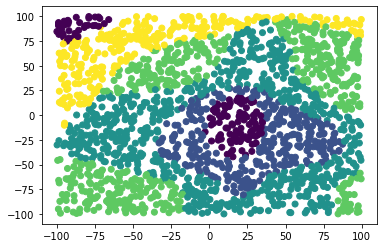

In [458]:
trainlossesBoth = nn.losses
vallossesBoth = nn.vallosses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

In [459]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.7583697500028728

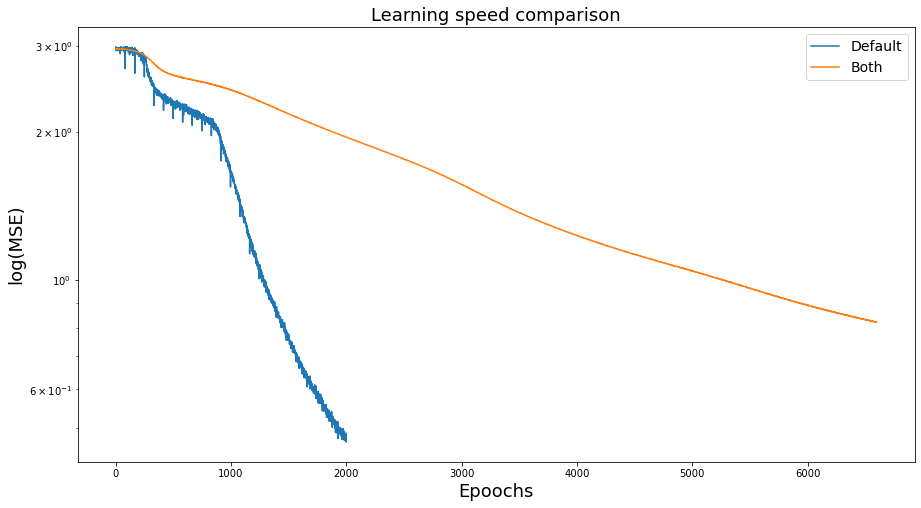

In [460]:
plt.figure(figsize=(15,8))
plt.plot(trainlossesDefault,label="Default")
plt.plot(trainlossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

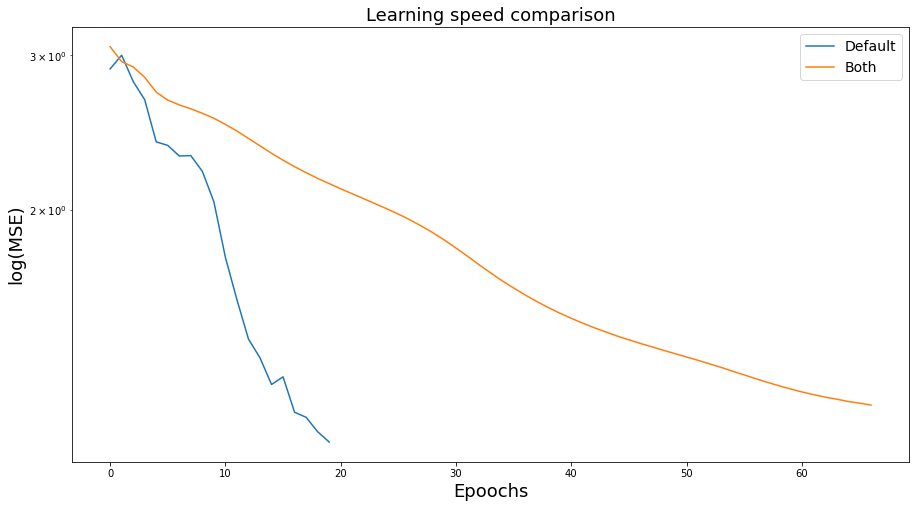

In [461]:
plt.figure(figsize=(15,8))
plt.plot(vallossesDefault,label="Default")
plt.plot(vallossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epoochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

# rings3-balance

In [4]:
train_df = pd.read_csv("data/rings3-balance-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/rings3-balance-test.csv",index_col=0).reset_index()

In [51]:
X_train = np.reshape(train_df[["x","y"]].values,(len(train_df),2))
Y_train = np.reshape(train_df["c"].values,(len(train_df),1))

In [52]:
X_test = np.reshape(test_df[["x","y"]].values,(len(test_df),2))
Y_test = np.reshape(test_df["c"].values,(len(test_df),1))

In [53]:
y_train = makey_rings3(Y_train)
y_test = makey_rings3(Y_test)

In [54]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Default

In [55]:
nn = NeuralNetwork(2,[40,3],["tanh","softmax"],["uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.001,with_regularization=False,early_stopping=False)

In [56]:
nn.fit(X_train_std.copy(), y_train.copy(),val=(X_test_std.copy(),y_test.copy()), epochs = 2000, batch_size = 128)

Epoch 1/2000 - loss: 2.974038140305708
Validation loss: 3.751976277438624
Epoch 2/2000 - loss: 2.5536683508151072
Epoch 3/2000 - loss: 2.4634432141670066
Epoch 4/2000 - loss: 2.414843152006881
Epoch 5/2000 - loss: 2.38131463555316
Epoch 6/2000 - loss: 2.3367646068437415
Epoch 7/2000 - loss: 2.302264872125805
Epoch 8/2000 - loss: 2.278472081243316
Epoch 9/2000 - loss: 2.2496697076064747
Epoch 10/2000 - loss: 2.22083216593145
Epoch 11/2000 - loss: 2.1870544453277914
Epoch 12/2000 - loss: 2.1641616223991176
Epoch 13/2000 - loss: 2.139945380114615
Epoch 14/2000 - loss: 2.1098095177942793
Epoch 15/2000 - loss: 2.0917977042770706
Epoch 16/2000 - loss: 2.0656086342168276
Epoch 17/2000 - loss: 2.0403091679070777
Epoch 18/2000 - loss: 2.017095322580971
Epoch 19/2000 - loss: 2.0014851215631837
Epoch 20/2000 - loss: 1.9863139887201662
Epoch 21/2000 - loss: 1.9579545685983637
Epoch 22/2000 - loss: 1.9442356810607222
Epoch 23/2000 - loss: 1.9291437900814579
Epoch 24/2000 - loss: 1.899277062476916
E

Epoch 198/2000 - loss: 0.6361765653329805
Epoch 199/2000 - loss: 0.6375038835578892
Epoch 200/2000 - loss: 0.629874503070992
Epoch 201/2000 - loss: 0.629314588888128
Validation loss: 2.199556928448452
Epoch 202/2000 - loss: 0.6336223423921953
Epoch 203/2000 - loss: 0.6319295251977661
Epoch 204/2000 - loss: 0.6276726210755502
Epoch 205/2000 - loss: 0.6289646979622129
Epoch 206/2000 - loss: 0.6250880148911071
Epoch 207/2000 - loss: 0.6235888827416611
Epoch 208/2000 - loss: 0.6248195536466413
Epoch 209/2000 - loss: 0.6227651848500461
Epoch 210/2000 - loss: 0.6223310060414984
Epoch 211/2000 - loss: 0.6196437279312063
Epoch 212/2000 - loss: 0.6254175135964757
Epoch 213/2000 - loss: 0.6162165217639872
Epoch 214/2000 - loss: 0.6167913227508611
Epoch 215/2000 - loss: 0.6156807400709761
Epoch 216/2000 - loss: 0.6225694815053846
Epoch 217/2000 - loss: 0.6138780116031424
Epoch 218/2000 - loss: 0.614890631443261
Epoch 219/2000 - loss: 0.615935379559069
Epoch 220/2000 - loss: 0.6126416619167073
Epo

Epoch 393/2000 - loss: 0.4836566883894563
Epoch 394/2000 - loss: 0.4866449624175681
Epoch 395/2000 - loss: 0.4869929823259193
Epoch 396/2000 - loss: 0.48517198404596074
Epoch 397/2000 - loss: 0.48124387438287863
Epoch 398/2000 - loss: 0.4834768513694307
Epoch 399/2000 - loss: 0.48131303315861734
Epoch 400/2000 - loss: 0.4839161242934701
Epoch 401/2000 - loss: 0.47853018079092685
Validation loss: 1.8568977487150844
Epoch 402/2000 - loss: 0.4790057099656036
Epoch 403/2000 - loss: 0.4837201864742077
Epoch 404/2000 - loss: 0.48182502393251225
Epoch 405/2000 - loss: 0.476984423353526
Epoch 406/2000 - loss: 0.47607851386725575
Epoch 407/2000 - loss: 0.47818739843807345
Epoch 408/2000 - loss: 0.47599341853306354
Epoch 409/2000 - loss: 0.4777623272026227
Epoch 410/2000 - loss: 0.470264926066471
Epoch 411/2000 - loss: 0.47914232658085054
Epoch 412/2000 - loss: 0.47118136050908876
Epoch 413/2000 - loss: 0.47722309371128807
Epoch 414/2000 - loss: 0.47016218664250353
Epoch 415/2000 - loss: 0.47515

Epoch 585/2000 - loss: 0.38953915834781644
Epoch 586/2000 - loss: 0.3912269262336929
Epoch 587/2000 - loss: 0.38972067581960235
Epoch 588/2000 - loss: 0.3897756599738566
Epoch 589/2000 - loss: 0.3861324128210697
Epoch 590/2000 - loss: 0.38823659572088604
Epoch 591/2000 - loss: 0.3884871764082084
Epoch 592/2000 - loss: 0.38821748782841675
Epoch 593/2000 - loss: 0.38908521846817307
Epoch 594/2000 - loss: 0.3893116573548672
Epoch 595/2000 - loss: 0.3841340136791462
Epoch 596/2000 - loss: 0.38744644250256144
Epoch 597/2000 - loss: 0.38454530270330667
Epoch 598/2000 - loss: 0.38190983536042616
Epoch 599/2000 - loss: 0.38531212862690845
Epoch 600/2000 - loss: 0.3869707859442637
Epoch 601/2000 - loss: 0.3826982084223808
Validation loss: 1.5741585448555118
Epoch 602/2000 - loss: 0.3832974041759986
Epoch 603/2000 - loss: 0.3845472643756079
Epoch 604/2000 - loss: 0.38472267980698455
Epoch 605/2000 - loss: 0.38123144752916305
Epoch 606/2000 - loss: 0.3835476920490962
Epoch 607/2000 - loss: 0.3807

Epoch 777/2000 - loss: 0.33087014627027506
Epoch 778/2000 - loss: 0.32948709669525944
Epoch 779/2000 - loss: 0.32853364224325005
Epoch 780/2000 - loss: 0.3297464785470164
Epoch 781/2000 - loss: 0.3286813263746887
Epoch 782/2000 - loss: 0.32859706067974953
Epoch 783/2000 - loss: 0.3277791555439882
Epoch 784/2000 - loss: 0.3250921067993342
Epoch 785/2000 - loss: 0.32580501210912366
Epoch 786/2000 - loss: 0.329164368184485
Epoch 787/2000 - loss: 0.32638348600642736
Epoch 788/2000 - loss: 0.3286040924293643
Epoch 789/2000 - loss: 0.32501722769367775
Epoch 790/2000 - loss: 0.3267798248070665
Epoch 791/2000 - loss: 0.3237831499601446
Epoch 792/2000 - loss: 0.3261640956625221
Epoch 793/2000 - loss: 0.32436965631054276
Epoch 794/2000 - loss: 0.3252665948770801
Epoch 795/2000 - loss: 0.32420669812889
Epoch 796/2000 - loss: 0.32364088407143343
Epoch 797/2000 - loss: 0.3254601646077983
Epoch 798/2000 - loss: 0.32380256023511667
Epoch 799/2000 - loss: 0.3233516894909896
Epoch 800/2000 - loss: 0.32

Epoch 969/2000 - loss: 0.289591114142638
Epoch 970/2000 - loss: 0.28871860396852767
Epoch 971/2000 - loss: 0.2892064518081456
Epoch 972/2000 - loss: 0.28701954066316737
Epoch 973/2000 - loss: 0.2904649894987938
Epoch 974/2000 - loss: 0.2890072134575978
Epoch 975/2000 - loss: 0.28757352539295294
Epoch 976/2000 - loss: 0.2867211260296217
Epoch 977/2000 - loss: 0.2891785297512622
Epoch 978/2000 - loss: 0.28705955817337986
Epoch 979/2000 - loss: 0.28854252671690334
Epoch 980/2000 - loss: 0.28901309345373566
Epoch 981/2000 - loss: 0.2865729380109263
Epoch 982/2000 - loss: 0.28778140077533143
Epoch 983/2000 - loss: 0.2862823082413922
Epoch 984/2000 - loss: 0.28619865462966965
Epoch 985/2000 - loss: 0.2870834149852682
Epoch 986/2000 - loss: 0.2864622889315899
Epoch 987/2000 - loss: 0.28279586289711567
Epoch 988/2000 - loss: 0.28741291753434106
Epoch 989/2000 - loss: 0.28714141314088365
Epoch 990/2000 - loss: 0.28718966620898906
Epoch 991/2000 - loss: 0.2854266344341052
Epoch 992/2000 - loss: 

Epoch 1159/2000 - loss: 0.2617569376111304
Epoch 1160/2000 - loss: 0.2612292644319455
Epoch 1161/2000 - loss: 0.26117533865015186
Epoch 1162/2000 - loss: 0.2611500046321841
Epoch 1163/2000 - loss: 0.2585633434790148
Epoch 1164/2000 - loss: 0.26273460678463806
Epoch 1165/2000 - loss: 0.2595270669709558
Epoch 1166/2000 - loss: 0.26112443182293754
Epoch 1167/2000 - loss: 0.2598278645026782
Epoch 1168/2000 - loss: 0.2612066845877562
Epoch 1169/2000 - loss: 0.25758101223092966
Epoch 1170/2000 - loss: 0.25994461154924525
Epoch 1171/2000 - loss: 0.2582280569087186
Epoch 1172/2000 - loss: 0.2611539131616799
Epoch 1173/2000 - loss: 0.25960008601651396
Epoch 1174/2000 - loss: 0.26139737823515263
Epoch 1175/2000 - loss: 0.25918909514903415
Epoch 1176/2000 - loss: 0.25974260713299563
Epoch 1177/2000 - loss: 0.25870121723826456
Epoch 1178/2000 - loss: 0.2608671046789795
Epoch 1179/2000 - loss: 0.2573631918103302
Epoch 1180/2000 - loss: 0.2586850404653064
Epoch 1181/2000 - loss: 0.2592185306149977
E

Epoch 1347/2000 - loss: 0.23754973271839305
Epoch 1348/2000 - loss: 0.24125286585250064
Epoch 1349/2000 - loss: 0.2392323350718014
Epoch 1350/2000 - loss: 0.23810174980921128
Epoch 1351/2000 - loss: 0.24064484183645582
Epoch 1352/2000 - loss: 0.24023907870271333
Epoch 1353/2000 - loss: 0.2425590823023506
Epoch 1354/2000 - loss: 0.23803263875938677
Epoch 1355/2000 - loss: 0.23863718169358888
Epoch 1356/2000 - loss: 0.2370069590896771
Epoch 1357/2000 - loss: 0.24058025345553263
Epoch 1358/2000 - loss: 0.23791782646467513
Epoch 1359/2000 - loss: 0.23931845418005238
Epoch 1360/2000 - loss: 0.23939378436278644
Epoch 1361/2000 - loss: 0.24054351099017857
Epoch 1362/2000 - loss: 0.23803792800709853
Epoch 1363/2000 - loss: 0.236791089121817
Epoch 1364/2000 - loss: 0.23885238623108224
Epoch 1365/2000 - loss: 0.23778075510582866
Epoch 1366/2000 - loss: 0.2376444008406568
Epoch 1367/2000 - loss: 0.2378083547657039
Epoch 1368/2000 - loss: 0.2383728223667352
Epoch 1369/2000 - loss: 0.23644139734209

Epoch 1534/2000 - loss: 0.22446799976719792
Epoch 1535/2000 - loss: 0.22328873994527967
Epoch 1536/2000 - loss: 0.22292748725448486
Epoch 1537/2000 - loss: 0.22307484054187618
Epoch 1538/2000 - loss: 0.2237131493537926
Epoch 1539/2000 - loss: 0.22233265280742143
Epoch 1540/2000 - loss: 0.22186842447710695
Epoch 1541/2000 - loss: 0.22389051600722124
Epoch 1542/2000 - loss: 0.22305476048337344
Epoch 1543/2000 - loss: 0.22094922891129928
Epoch 1544/2000 - loss: 0.22332627895474724
Epoch 1545/2000 - loss: 0.22166319874731216
Epoch 1546/2000 - loss: 0.22076452033798794
Epoch 1547/2000 - loss: 0.22227755812615518
Epoch 1548/2000 - loss: 0.22037337218949543
Epoch 1549/2000 - loss: 0.22275104140373866
Epoch 1550/2000 - loss: 0.223881113401883
Epoch 1551/2000 - loss: 0.2224891279545587
Epoch 1552/2000 - loss: 0.22106072247654068
Epoch 1553/2000 - loss: 0.22150741120345757
Epoch 1554/2000 - loss: 0.22162717138467666
Epoch 1555/2000 - loss: 0.22141739357932394
Epoch 1556/2000 - loss: 0.2216533679

Epoch 1721/2000 - loss: 0.21152659717055272
Epoch 1722/2000 - loss: 0.2087838295540502
Epoch 1723/2000 - loss: 0.2104030100996555
Epoch 1724/2000 - loss: 0.20993524433601687
Epoch 1725/2000 - loss: 0.2061271833924607
Epoch 1726/2000 - loss: 0.20984712640532638
Epoch 1727/2000 - loss: 0.2093871976218271
Epoch 1728/2000 - loss: 0.2095958761507512
Epoch 1729/2000 - loss: 0.2090565070079134
Epoch 1730/2000 - loss: 0.20980144683580088
Epoch 1731/2000 - loss: 0.207875825472016
Epoch 1732/2000 - loss: 0.20963916489040862
Epoch 1733/2000 - loss: 0.20915619031209481
Epoch 1734/2000 - loss: 0.20931606248036735
Epoch 1735/2000 - loss: 0.20750199330837152
Epoch 1736/2000 - loss: 0.20900390943496497
Epoch 1737/2000 - loss: 0.20939066153870467
Epoch 1738/2000 - loss: 0.20836976166609628
Epoch 1739/2000 - loss: 0.2069083903245997
Epoch 1740/2000 - loss: 0.2099407694449037
Epoch 1741/2000 - loss: 0.20809966032536725
Epoch 1742/2000 - loss: 0.20968485738035925
Epoch 1743/2000 - loss: 0.2059161541768513

Epoch 1908/2000 - loss: 0.19922125428872176
Epoch 1909/2000 - loss: 0.19650235971265065
Epoch 1910/2000 - loss: 0.19879427575219993
Epoch 1911/2000 - loss: 0.19900281366816241
Epoch 1912/2000 - loss: 0.19706850494432182
Epoch 1913/2000 - loss: 0.1971838480550107
Epoch 1914/2000 - loss: 0.1990382042073594
Epoch 1915/2000 - loss: 0.197589660992564
Epoch 1916/2000 - loss: 0.19655908243886308
Epoch 1917/2000 - loss: 0.19905066837634783
Epoch 1918/2000 - loss: 0.19584624059547384
Epoch 1919/2000 - loss: 0.19584781604027734
Epoch 1920/2000 - loss: 0.19877426623612854
Epoch 1921/2000 - loss: 0.19591241637016268
Epoch 1922/2000 - loss: 0.1977874110784038
Epoch 1923/2000 - loss: 0.19854185658447437
Epoch 1924/2000 - loss: 0.19853585613513233
Epoch 1925/2000 - loss: 0.19721865880125955
Epoch 1926/2000 - loss: 0.19663329667323054
Epoch 1927/2000 - loss: 0.19737079602378735
Epoch 1928/2000 - loss: 0.19518643465742244
Epoch 1929/2000 - loss: 0.19679607509131927
Epoch 1930/2000 - loss: 0.19649844030

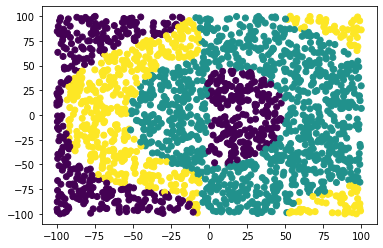

In [57]:
trainlossesDefault = nn.losses
vallossesDefault = nn.vallosses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

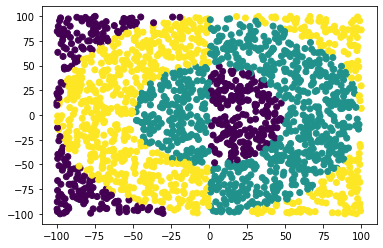

In [58]:
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

In [59]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.8492644655116051

## With weight regularization and early-stopping

In [60]:
nn = NeuralNetwork(2,[40,3],["tanh","softmax"],["uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.001,lmbda=0.00001,with_regularization=True,early_stopping=True)

In [61]:
nn.fit(X_train_std.copy(), y_train.copy(),val=(X_test_std.copy(),y_test.copy()),target=0.5, epochs = 2000, batch_size = 128)

Epoch 1/2000 - loss: 2.9743990816293637
Validation loss: 3.751425691009903
Epoch 2/2000 - loss: 2.554135601669086
Epoch 3/2000 - loss: 2.463773214930614
Epoch 4/2000 - loss: 2.4151631340421824
Epoch 5/2000 - loss: 2.381178929959464
Epoch 6/2000 - loss: 2.3360398176163666
Epoch 7/2000 - loss: 2.3011235328182305
Epoch 8/2000 - loss: 2.2766512801837866
Epoch 9/2000 - loss: 2.2467017327393317
Epoch 10/2000 - loss: 2.2172178169786485
Epoch 11/2000 - loss: 2.1829572979525054
Epoch 12/2000 - loss: 2.1593318020823102
Epoch 13/2000 - loss: 2.1345152286663667
Epoch 14/2000 - loss: 2.1034949032523635
Epoch 15/2000 - loss: 2.084990259329798
Epoch 16/2000 - loss: 2.0584157094615945
Epoch 17/2000 - loss: 2.032466666000615
Epoch 18/2000 - loss: 2.0094740877578827
Epoch 19/2000 - loss: 1.9930432666032154
Epoch 20/2000 - loss: 1.9776813678162266
Epoch 21/2000 - loss: 1.9492280003189917
Epoch 22/2000 - loss: 1.9348401672033473
Epoch 23/2000 - loss: 1.9194929532558298
Epoch 24/2000 - loss: 1.889000060899

Epoch 198/2000 - loss: 0.6434190159667659
Epoch 199/2000 - loss: 0.6454156969906246
Epoch 200/2000 - loss: 0.6386287991202412
Epoch 201/2000 - loss: 0.6372524104982115
Validation loss: 2.233952037686999
Epoch 202/2000 - loss: 0.6413201930327884
Epoch 203/2000 - loss: 0.6400510127147484
Epoch 204/2000 - loss: 0.6358358199887207
Epoch 205/2000 - loss: 0.6369851090120948
Epoch 206/2000 - loss: 0.6337401788902134
Epoch 207/2000 - loss: 0.6312254823655169
Epoch 208/2000 - loss: 0.6335223004319821
Epoch 209/2000 - loss: 0.6313134584111949
Epoch 210/2000 - loss: 0.629870956167239
Epoch 211/2000 - loss: 0.6286472110428458
Epoch 212/2000 - loss: 0.632901879926455
Epoch 213/2000 - loss: 0.6244948617282343
Epoch 214/2000 - loss: 0.6245454925306461
Epoch 215/2000 - loss: 0.6238246576704669
Epoch 216/2000 - loss: 0.6303610325854877
Epoch 217/2000 - loss: 0.6221066155991988
Epoch 218/2000 - loss: 0.6237224293163595
Epoch 219/2000 - loss: 0.6244584202595904
Epoch 220/2000 - loss: 0.6206142724786811
E

Epoch 392/2000 - loss: 0.49392421583951085
Epoch 393/2000 - loss: 0.49069472127942715
Epoch 394/2000 - loss: 0.49462619785211404
Epoch 395/2000 - loss: 0.49330597010453126
Epoch 396/2000 - loss: 0.492957549410129
Epoch 397/2000 - loss: 0.49021449099315456
Epoch 398/2000 - loss: 0.4904455081433385
Epoch 399/2000 - loss: 0.489175260171026
Epoch 400/2000 - loss: 0.4896531437739731
Epoch 401/2000 - loss: 0.48663105503304066
Validation loss: 1.9141156573030282
Epoch 402/2000 - loss: 0.4869215827056393
Epoch 403/2000 - loss: 0.4899335154480163
Epoch 404/2000 - loss: 0.48902676115472427
Epoch 405/2000 - loss: 0.4859239426982281
Epoch 406/2000 - loss: 0.48421520425395603
Epoch 407/2000 - loss: 0.4864128347717107
Epoch 408/2000 - loss: 0.48366707711613555
Epoch 409/2000 - loss: 0.4863451306833979
Epoch 410/2000 - loss: 0.4769016993885586
Epoch 411/2000 - loss: 0.4867158044356467
Epoch 412/2000 - loss: 0.4795945339624153
Epoch 413/2000 - loss: 0.48488024906996585
Epoch 414/2000 - loss: 0.4776184

Epoch 584/2000 - loss: 0.41071639874573335
Epoch 585/2000 - loss: 0.4124026732107799
Epoch 586/2000 - loss: 0.41605149386821505
Epoch 587/2000 - loss: 0.41358424626318696
Epoch 588/2000 - loss: 0.4125888315313418
Epoch 589/2000 - loss: 0.41058097935642496
Epoch 590/2000 - loss: 0.4126219591011904
Epoch 591/2000 - loss: 0.4120618557519578
Epoch 592/2000 - loss: 0.4130468884769809
Epoch 593/2000 - loss: 0.4132153696886749
Epoch 594/2000 - loss: 0.4135393315318053
Epoch 595/2000 - loss: 0.40871400939302704
Epoch 596/2000 - loss: 0.41270985120361386
Epoch 597/2000 - loss: 0.4093095054154313
Epoch 598/2000 - loss: 0.40904180048376265
Epoch 599/2000 - loss: 0.40990481893117814
Epoch 600/2000 - loss: 0.4114920921888258
Epoch 601/2000 - loss: 0.4074466771766961
Validation loss: 1.646063921170739
Epoch 602/2000 - loss: 0.4093988395116721
Epoch 603/2000 - loss: 0.4092991032319698
Epoch 604/2000 - loss: 0.4095682218846695
Epoch 605/2000 - loss: 0.4078291822591025
Epoch 606/2000 - loss: 0.40977264

Epoch 776/2000 - loss: 0.36975156090075345
Epoch 777/2000 - loss: 0.3725008402110321
Epoch 778/2000 - loss: 0.3717043835065548
Epoch 779/2000 - loss: 0.3714483171567938
Epoch 780/2000 - loss: 0.3721935785458992
Epoch 781/2000 - loss: 0.3702226205731208
Epoch 782/2000 - loss: 0.372007448748851
Epoch 783/2000 - loss: 0.37055513375429605
Epoch 784/2000 - loss: 0.36661551363953426
Epoch 785/2000 - loss: 0.36839938742826744
Epoch 786/2000 - loss: 0.37280746368182316
Epoch 787/2000 - loss: 0.369256999603802
Epoch 788/2000 - loss: 0.3715944125205121
Epoch 789/2000 - loss: 0.3671062613114829
Epoch 790/2000 - loss: 0.3707138582869452
Epoch 791/2000 - loss: 0.3666273924578492
Epoch 792/2000 - loss: 0.37007118430414376
Epoch 793/2000 - loss: 0.3688227636997599
Epoch 794/2000 - loss: 0.3687868910342196
Epoch 795/2000 - loss: 0.36764786235015756
Epoch 796/2000 - loss: 0.3671301141834266
Epoch 797/2000 - loss: 0.36995267353363365
Epoch 798/2000 - loss: 0.36740378142978375
Epoch 799/2000 - loss: 0.36

Epoch 968/2000 - loss: 0.33926755034007194
Epoch 969/2000 - loss: 0.34002514913517073
Epoch 970/2000 - loss: 0.3399249223880291
Epoch 971/2000 - loss: 0.3404193228417808
Epoch 972/2000 - loss: 0.33778572351319364
Epoch 973/2000 - loss: 0.3389472173786775
Epoch 974/2000 - loss: 0.3393793139221789
Epoch 975/2000 - loss: 0.3378387772322111
Epoch 976/2000 - loss: 0.3382801148263754
Epoch 977/2000 - loss: 0.33987056144863403
Epoch 978/2000 - loss: 0.336962873176482
Epoch 979/2000 - loss: 0.3385589314598389
Epoch 980/2000 - loss: 0.3403397108906301
Epoch 981/2000 - loss: 0.3351519402495099
Epoch 982/2000 - loss: 0.33760684540674224
Epoch 983/2000 - loss: 0.3371524109712926
Epoch 984/2000 - loss: 0.3351139965248276
Epoch 985/2000 - loss: 0.3371220632095797
Epoch 986/2000 - loss: 0.3367378868561768
Epoch 987/2000 - loss: 0.33160208668814045
Epoch 988/2000 - loss: 0.33794895662331575
Epoch 989/2000 - loss: 0.3376028594991278
Epoch 990/2000 - loss: 0.3356457614994972
Epoch 991/2000 - loss: 0.334

Epoch 1157/2000 - loss: 0.326633937006836
Epoch 1158/2000 - loss: 0.3254947386889684
Epoch 1159/2000 - loss: 0.32722446101053543
Epoch 1160/2000 - loss: 0.32549201406698575
Epoch 1161/2000 - loss: 0.32614277042676454
Epoch 1162/2000 - loss: 0.32650281386696506
Epoch 1163/2000 - loss: 0.32237613255938713
Epoch 1164/2000 - loss: 0.33006853799142977
Epoch 1165/2000 - loss: 0.325465579266145
Epoch 1166/2000 - loss: 0.32823014813798806
Epoch 1167/2000 - loss: 0.3252647964962757
Epoch 1168/2000 - loss: 0.32678920175996506
Epoch 1169/2000 - loss: 0.32395234949457485
Epoch 1170/2000 - loss: 0.32774150984394546
Epoch 1171/2000 - loss: 0.325055806515667
Epoch 1172/2000 - loss: 0.329550229127975
Epoch 1173/2000 - loss: 0.32870926081890944
Epoch 1174/2000 - loss: 0.33070596364088
Epoch 1175/2000 - loss: 0.32675158819517136
Epoch 1176/2000 - loss: 0.3290616469015685
Epoch 1177/2000 - loss: 0.32737862781442406
Epoch 1178/2000 - loss: 0.3312776031976251
Epoch 1179/2000 - loss: 0.32651750491745885
Epo

Epoch 1346/2000 - loss: 0.36234479920417473
Epoch 1347/2000 - loss: 0.36281846373392784
Epoch 1348/2000 - loss: 0.36765727888871824
Epoch 1349/2000 - loss: 0.363237297347288
Epoch 1350/2000 - loss: 0.36315708016050763
Epoch 1351/2000 - loss: 0.36677560257906416
Epoch 1352/2000 - loss: 0.3676982677214246
Epoch 1353/2000 - loss: 0.3697373018879184
Epoch 1354/2000 - loss: 0.36415431017740457
Epoch 1355/2000 - loss: 0.3684268880783861
Epoch 1356/2000 - loss: 0.3632805487267775
Epoch 1357/2000 - loss: 0.37037875312172824
Epoch 1358/2000 - loss: 0.3681756615057756
Epoch 1359/2000 - loss: 0.36924426843327895
Epoch 1360/2000 - loss: 0.3703120911463591
Epoch 1361/2000 - loss: 0.3730094542137475
Epoch 1362/2000 - loss: 0.36909992645830964
Epoch 1363/2000 - loss: 0.36847079678374506
Epoch 1364/2000 - loss: 0.375060427743685
Epoch 1365/2000 - loss: 0.37151083977729216
Epoch 1366/2000 - loss: 0.3725388833201321
Epoch 1367/2000 - loss: 0.37310141232662075
Epoch 1368/2000 - loss: 0.3744106382668358
E

Epoch 1534/2000 - loss: 0.5406862423256827
Epoch 1535/2000 - loss: 0.5429260426123584
Epoch 1536/2000 - loss: 0.5406283864534263
Epoch 1537/2000 - loss: 0.5459750123809548
Epoch 1538/2000 - loss: 0.5438490208193074
Epoch 1539/2000 - loss: 0.5465198727457687
Epoch 1540/2000 - loss: 0.5461585316361021
Epoch 1541/2000 - loss: 0.5537927133092799
Epoch 1542/2000 - loss: 0.5508220038257787
Epoch 1543/2000 - loss: 0.5472795301307315
Epoch 1544/2000 - loss: 0.5538678678115856
Epoch 1545/2000 - loss: 0.5508490241229087
Epoch 1546/2000 - loss: 0.5542308004175952
Epoch 1547/2000 - loss: 0.5570527999272352
Epoch 1548/2000 - loss: 0.555083561757449
Epoch 1549/2000 - loss: 0.5591818983044641
Epoch 1550/2000 - loss: 0.5622164665284903
Epoch 1551/2000 - loss: 0.5577986725180785
Epoch 1552/2000 - loss: 0.5602533046266128
Epoch 1553/2000 - loss: 0.5626375248932761
Epoch 1554/2000 - loss: 0.5616233392841676
Epoch 1555/2000 - loss: 0.5607313551837597
Epoch 1556/2000 - loss: 0.5620889421380375
Epoch 1557/2

Epoch 1724/2000 - loss: 0.7328598901253347
Epoch 1725/2000 - loss: 0.7336989879274087
Epoch 1726/2000 - loss: 0.7367525635343587
Epoch 1727/2000 - loss: 0.7422872196201151
Epoch 1728/2000 - loss: 0.7386007794710772
Epoch 1729/2000 - loss: 0.7382105394083596
Epoch 1730/2000 - loss: 0.7407036807838758
Epoch 1731/2000 - loss: 0.7439513753418923
Epoch 1732/2000 - loss: 0.7448658398249869
Epoch 1733/2000 - loss: 0.7445146471943346
Epoch 1734/2000 - loss: 0.7475790547606613
Epoch 1735/2000 - loss: 0.7498537966593344
Epoch 1736/2000 - loss: 0.7472475341295228
Epoch 1737/2000 - loss: 0.7543030720224704
Epoch 1738/2000 - loss: 0.7493294957271608
Epoch 1739/2000 - loss: 0.7483065771350597
Epoch 1740/2000 - loss: 0.7679538013740717
Epoch 1741/2000 - loss: 0.7550668399564763
Epoch 1742/2000 - loss: 0.7579178068032076
Epoch 1743/2000 - loss: 0.7587944738539852
Epoch 1744/2000 - loss: 0.7582307024352061
Epoch 1745/2000 - loss: 0.7751484118119708
Epoch 1746/2000 - loss: 0.7675706339651903
Epoch 1747/

Epoch 1914/2000 - loss: 1.6807942122242798
Epoch 1915/2000 - loss: 1.6849227108716798
Epoch 1916/2000 - loss: 1.6887248255315357
Epoch 1917/2000 - loss: 1.6960031866943206
Epoch 1918/2000 - loss: 1.7055550593596365
Epoch 1919/2000 - loss: 1.7017942652669307
Epoch 1920/2000 - loss: 1.7212020420805203
Epoch 1921/2000 - loss: 1.7097120726139372
Epoch 1922/2000 - loss: 1.7314448269499032
Epoch 1923/2000 - loss: 1.7227821388559108
Epoch 1924/2000 - loss: 1.7379227259894792
Epoch 1925/2000 - loss: 1.7381265925298561
Epoch 1926/2000 - loss: 1.7514634706928462
Epoch 1927/2000 - loss: 1.7543301237707403
Epoch 1928/2000 - loss: 1.7576294635958791
Epoch 1929/2000 - loss: 1.772337431066774
Epoch 1930/2000 - loss: 1.7732933578097971
Epoch 1931/2000 - loss: 1.7796647278209639
Epoch 1932/2000 - loss: 1.794186894063531
Epoch 1933/2000 - loss: 1.7911436369963398
Epoch 1934/2000 - loss: 1.7960927255364318
Epoch 1935/2000 - loss: 1.799720799622302
Epoch 1936/2000 - loss: 1.8097831695585926
Epoch 1937/200

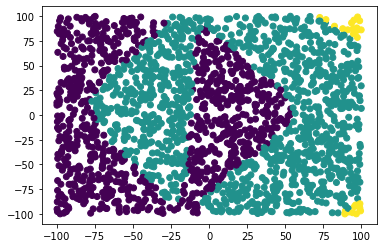

In [62]:
trainlossesBoth = nn.losses
vallossesBoth = nn.vallosses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

In [63]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.4739965867857201

## With early-stopping

In [64]:
nn = NeuralNetwork(2,[40,3],["tanh","softmax"],["uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.002,with_regularization=False,early_stopping=True)

In [65]:
nn.fit(X_train_std.copy(), y_train.copy(),val=(X_test_std.copy(),y_test.copy()),target=0.7, epochs = 20000, batch_size = 128)

Epoch 1/20000 - loss: 2.76341396638374
Validation loss: 3.739660409103765
Epoch 2/20000 - loss: 2.42831773505213
Epoch 3/20000 - loss: 2.363041086715758
Epoch 4/20000 - loss: 2.2940055446233245
Epoch 5/20000 - loss: 2.246786951683905
Epoch 6/20000 - loss: 2.1762590409142146
Epoch 7/20000 - loss: 2.121208143223094
Epoch 8/20000 - loss: 2.0749129035014744
Epoch 9/20000 - loss: 2.0393744441330295
Epoch 10/20000 - loss: 1.994637415565218
Epoch 11/20000 - loss: 1.9513113711922228
Epoch 12/20000 - loss: 1.9216803278546588
Epoch 13/20000 - loss: 1.8877616212771555
Epoch 14/20000 - loss: 1.8447906735257082
Epoch 15/20000 - loss: 1.8175239592422499
Epoch 16/20000 - loss: 1.7751985153422911
Epoch 17/20000 - loss: 1.7308090134103333
Epoch 18/20000 - loss: 1.6782941622964618
Epoch 19/20000 - loss: 1.6315999707578737
Epoch 20/20000 - loss: 1.5881693389542644
Epoch 21/20000 - loss: 1.5218724607106617
Epoch 22/20000 - loss: 1.4690571501317087
Epoch 23/20000 - loss: 1.4269680581194826
Epoch 24/20000 -

Epoch 194/20000 - loss: 0.4975726453248982
Epoch 195/20000 - loss: 0.49065173113389526
Epoch 196/20000 - loss: 0.4848867861936766
Epoch 197/20000 - loss: 0.48826083310216023
Epoch 198/20000 - loss: 0.48913656696941077
Epoch 199/20000 - loss: 0.4881060778364317
Epoch 200/20000 - loss: 0.4829584525726805
Epoch 201/20000 - loss: 0.4813048108117238
Validation loss: 1.8297171625071347
Epoch 202/20000 - loss: 0.4847028819989061
Epoch 203/20000 - loss: 0.4838917363819823
Epoch 204/20000 - loss: 0.4785913627451546
Epoch 205/20000 - loss: 0.4798153744762957
Epoch 206/20000 - loss: 0.4770332232907111
Epoch 207/20000 - loss: 0.47484614345943066
Epoch 208/20000 - loss: 0.4770349845019479
Epoch 209/20000 - loss: 0.4741614987087538
Epoch 210/20000 - loss: 0.47255950144570213
Epoch 211/20000 - loss: 0.47178782856839246
Epoch 212/20000 - loss: 0.47591543123226765
Epoch 213/20000 - loss: 0.46536005093110516
Epoch 214/20000 - loss: 0.4665034419198653
Epoch 215/20000 - loss: 0.4690437634019116
Epoch 216/

Epoch 381/20000 - loss: 0.33808562372333917
Epoch 382/20000 - loss: 0.33329138947268105
Epoch 383/20000 - loss: 0.33758561911527135
Epoch 384/20000 - loss: 0.33199006534328684
Epoch 385/20000 - loss: 0.3333537042209913
Epoch 386/20000 - loss: 0.33282825122099036
Epoch 387/20000 - loss: 0.33364758623344787
Epoch 388/20000 - loss: 0.3329700829289472
Epoch 389/20000 - loss: 0.33303261367034476
Epoch 390/20000 - loss: 0.33048079890718246
Epoch 391/20000 - loss: 0.32965045276788235
Epoch 392/20000 - loss: 0.3320275699320433
Epoch 393/20000 - loss: 0.32907596408860484
Epoch 394/20000 - loss: 0.3306749052326208
Epoch 395/20000 - loss: 0.33197676369511764
Epoch 396/20000 - loss: 0.3302861760814477
Epoch 397/20000 - loss: 0.32466606948918464
Epoch 398/20000 - loss: 0.32769306911917706
Epoch 399/20000 - loss: 0.3271636431503092
Epoch 400/20000 - loss: 0.32664336884885625
Epoch 401/20000 - loss: 0.32463153111657833
Validation loss: 1.4041925857980193
Epoch 402/20000 - loss: 0.32417509819553614
Ep

Epoch 569/20000 - loss: 0.27129109432029724
Epoch 570/20000 - loss: 0.2640579124835279
Epoch 571/20000 - loss: 0.26612562051843514
Epoch 572/20000 - loss: 0.26850569687566767
Epoch 573/20000 - loss: 0.261976082626809
Epoch 574/20000 - loss: 0.2651846399545248
Epoch 575/20000 - loss: 0.26612251091244105
Epoch 576/20000 - loss: 0.26418909755249254
Epoch 577/20000 - loss: 0.2657661777181289
Epoch 578/20000 - loss: 0.2661714793295201
Epoch 579/20000 - loss: 0.26169836913872435
Epoch 580/20000 - loss: 0.26826343865677865
Epoch 581/20000 - loss: 0.26040411155816673
Epoch 582/20000 - loss: 0.2584886717442314
Epoch 583/20000 - loss: 0.2667243594265928
Epoch 584/20000 - loss: 0.26069423998643915
Epoch 585/20000 - loss: 0.2625556065750067
Epoch 586/20000 - loss: 0.26137589193617655
Epoch 587/20000 - loss: 0.2625375023801827
Epoch 588/20000 - loss: 0.26209130763254285
Epoch 589/20000 - loss: 0.259836343209907
Epoch 590/20000 - loss: 0.26137224678906934
Epoch 591/20000 - loss: 0.2634616925113773
E

Epoch 756/20000 - loss: 0.22988618237473984
Epoch 757/20000 - loss: 0.2235981532264603
Epoch 758/20000 - loss: 0.22965719882403712
Epoch 759/20000 - loss: 0.22658709358710494
Epoch 760/20000 - loss: 0.2288105665250323
Epoch 761/20000 - loss: 0.2267515330125025
Epoch 762/20000 - loss: 0.22868835353861208
Epoch 763/20000 - loss: 0.22589534330043187
Epoch 764/20000 - loss: 0.23079433423403523
Epoch 765/20000 - loss: 0.2267535096397419
Epoch 766/20000 - loss: 0.22743571993941408
Epoch 767/20000 - loss: 0.22318354107367636
Epoch 768/20000 - loss: 0.2259993007024475
Epoch 769/20000 - loss: 0.22426859103994792
Epoch 770/20000 - loss: 0.22656126505208948
Epoch 771/20000 - loss: 0.22432712628873705
Epoch 772/20000 - loss: 0.2226115251150534
Epoch 773/20000 - loss: 0.22389531425047587
Epoch 774/20000 - loss: 0.22586426652044853
Epoch 775/20000 - loss: 0.22585993459061518
Epoch 776/20000 - loss: 0.2209510047228925
Epoch 777/20000 - loss: 0.2258809695050377
Epoch 778/20000 - loss: 0.22477393855493

Epoch 943/20000 - loss: 0.20112897088664414
Epoch 944/20000 - loss: 0.20069190497180178
Epoch 945/20000 - loss: 0.20128566192680003
Epoch 946/20000 - loss: 0.20287839146608513
Epoch 947/20000 - loss: 0.20423612852480325
Epoch 948/20000 - loss: 0.20350072264889127
Epoch 949/20000 - loss: 0.20053832526955853
Epoch 950/20000 - loss: 0.19959697434401827
Epoch 951/20000 - loss: 0.2035925120226452
Epoch 952/20000 - loss: 0.20084186326172998
Epoch 953/20000 - loss: 0.20154672488884776
Epoch 954/20000 - loss: 0.20076836769765083
Epoch 955/20000 - loss: 0.20029962073989072
Epoch 956/20000 - loss: 0.1993251464664485
Epoch 957/20000 - loss: 0.20103947113615403
Epoch 958/20000 - loss: 0.19981523375507257
Epoch 959/20000 - loss: 0.1998558210642209
Epoch 960/20000 - loss: 0.2021233328324343
Epoch 961/20000 - loss: 0.1998816709528674
Epoch 962/20000 - loss: 0.2013400052865639
Epoch 963/20000 - loss: 0.19846008330336068
Epoch 964/20000 - loss: 0.2012248191401977
Epoch 965/20000 - loss: 0.1984201663143

Epoch 1128/20000 - loss: 0.1840066257544785
Epoch 1129/20000 - loss: 0.18172682011599509
Epoch 1130/20000 - loss: 0.18430605905785108
Epoch 1131/20000 - loss: 0.18420179715413668
Epoch 1132/20000 - loss: 0.18221273652741363
Epoch 1133/20000 - loss: 0.1841978383656944
Epoch 1134/20000 - loss: 0.18319683529677283
Epoch 1135/20000 - loss: 0.18370632656911504
Epoch 1136/20000 - loss: 0.18545397807511035
Epoch 1137/20000 - loss: 0.18250918309182393
Epoch 1138/20000 - loss: 0.18450591717017242
Epoch 1139/20000 - loss: 0.181761636768987
Epoch 1140/20000 - loss: 0.18353496367901162
Epoch 1141/20000 - loss: 0.18130173601153132
Epoch 1142/20000 - loss: 0.18429028645166914
Epoch 1143/20000 - loss: 0.18374806885204004
Epoch 1144/20000 - loss: 0.18064121960762883
Epoch 1145/20000 - loss: 0.18227475322277972
Epoch 1146/20000 - loss: 0.18441781112086336
Epoch 1147/20000 - loss: 0.18269248388628695
Epoch 1148/20000 - loss: 0.18212039336241867
Epoch 1149/20000 - loss: 0.18061911090401508
Epoch 1150/200

Epoch 1310/20000 - loss: 0.1714973702219205
Epoch 1311/20000 - loss: 0.16948889328057543
Epoch 1312/20000 - loss: 0.17126886796852633
Epoch 1313/20000 - loss: 0.16897094221223485
Epoch 1314/20000 - loss: 0.17007650467594776
Epoch 1315/20000 - loss: 0.17041152582679991
Epoch 1316/20000 - loss: 0.1694151091033939
Epoch 1317/20000 - loss: 0.16833844981774113
Epoch 1318/20000 - loss: 0.1689502424344836
Epoch 1319/20000 - loss: 0.17094084477122054
Epoch 1320/20000 - loss: 0.16788781763931226
Epoch 1321/20000 - loss: 0.1703091748654813
Epoch 1322/20000 - loss: 0.1685199801476413
Epoch 1323/20000 - loss: 0.1712137061723963
Epoch 1324/20000 - loss: 0.1692051565168732
Epoch 1325/20000 - loss: 0.1702907678991529
Epoch 1326/20000 - loss: 0.16978859290934187
Epoch 1327/20000 - loss: 0.16832058212433024
Epoch 1328/20000 - loss: 0.16810826398527925
Epoch 1329/20000 - loss: 0.16979423394216803
Epoch 1330/20000 - loss: 0.16833552534624063
Epoch 1331/20000 - loss: 0.16819040808024216
Epoch 1332/20000 -

Epoch 1493/20000 - loss: 0.15971308255732547
Epoch 1494/20000 - loss: 0.1594073275935517
Epoch 1495/20000 - loss: 0.15853948261934045
Epoch 1496/20000 - loss: 0.15766129055571923
Epoch 1497/20000 - loss: 0.16062675617146724
Epoch 1498/20000 - loss: 0.15849346618339483
Epoch 1499/20000 - loss: 0.15844190197376162
Epoch 1500/20000 - loss: 0.15809283045959832
Epoch 1501/20000 - loss: 0.1587311368795029
Validation loss: 0.8193650421022224
Epoch 1502/20000 - loss: 0.15801560988238744
Epoch 1503/20000 - loss: 0.15860232109380892
Epoch 1504/20000 - loss: 0.1581504958616319
Epoch 1505/20000 - loss: 0.15777013588565109
Epoch 1506/20000 - loss: 0.15880486647232928
Epoch 1507/20000 - loss: 0.1580506246464048
Epoch 1508/20000 - loss: 0.15713386986533404
Epoch 1509/20000 - loss: 0.15913229410947785
Epoch 1510/20000 - loss: 0.1588921819066157
Epoch 1511/20000 - loss: 0.15485809900412228
Epoch 1512/20000 - loss: 0.16127155174396293
Epoch 1513/20000 - loss: 0.15751007248244214
Epoch 1514/20000 - loss:

Epoch 1675/20000 - loss: 0.15066361616827317
Epoch 1676/20000 - loss: 0.15095794487213662
Epoch 1677/20000 - loss: 0.14906934088536555
Epoch 1678/20000 - loss: 0.15079465899861455
Epoch 1679/20000 - loss: 0.1494577354682978
Epoch 1680/20000 - loss: 0.1490115594248849
Epoch 1681/20000 - loss: 0.14968674483099256
Epoch 1682/20000 - loss: 0.1478312286419779
Epoch 1683/20000 - loss: 0.1506098457967243
Epoch 1684/20000 - loss: 0.1498177953949568
Epoch 1685/20000 - loss: 0.14729064932234465
Epoch 1686/20000 - loss: 0.14913574582331232
Epoch 1687/20000 - loss: 0.1509654088948495
Epoch 1688/20000 - loss: 0.1482186669230616
Epoch 1689/20000 - loss: 0.1483734774733969
Epoch 1690/20000 - loss: 0.14767492248879918
Epoch 1691/20000 - loss: 0.14836193609475232
Epoch 1692/20000 - loss: 0.1499265835515289
Epoch 1693/20000 - loss: 0.14626337584893365
Epoch 1694/20000 - loss: 0.14888859199540863
Epoch 1695/20000 - loss: 0.14961839641347316
Epoch 1696/20000 - loss: 0.1491561002127526
Epoch 1697/20000 - l

Epoch 1857/20000 - loss: 0.14266621197884552
Epoch 1858/20000 - loss: 0.14148011579192427
Epoch 1859/20000 - loss: 0.1417956973575383
Epoch 1860/20000 - loss: 0.14118182232099277
Epoch 1861/20000 - loss: 0.14115602464308113
Epoch 1862/20000 - loss: 0.13823153018896261
Epoch 1863/20000 - loss: 0.14013554839100667
Epoch 1864/20000 - loss: 0.14110770476647982
Epoch 1865/20000 - loss: 0.14047876902514744
Epoch 1866/20000 - loss: 0.13933530371277886
Epoch 1867/20000 - loss: 0.14310523723503407
Epoch 1868/20000 - loss: 0.14025488787339585
Epoch 1869/20000 - loss: 0.14032856628822277
Epoch 1870/20000 - loss: 0.14082119357432396
Epoch 1871/20000 - loss: 0.14015081453940822
Epoch 1872/20000 - loss: 0.13938093850029845
Epoch 1873/20000 - loss: 0.1407679679013309
Epoch 1874/20000 - loss: 0.14104692773327068
Epoch 1875/20000 - loss: 0.14159020213831114
Epoch 1876/20000 - loss: 0.13934545825421452
Epoch 1877/20000 - loss: 0.13785412754694373
Epoch 1878/20000 - loss: 0.1388576787999306
Epoch 1879/20

Epoch 2039/20000 - loss: 0.13014163774474324
Epoch 2040/20000 - loss: 0.1360381430780306
Epoch 2041/20000 - loss: 0.13267487552220453
Epoch 2042/20000 - loss: 0.13089647015502223
Epoch 2043/20000 - loss: 0.1315782095290869
Epoch 2044/20000 - loss: 0.1328055035926943
Epoch 2045/20000 - loss: 0.13098507144514207
Epoch 2046/20000 - loss: 0.1343222060863989
Epoch 2047/20000 - loss: 0.1346908943675001
Epoch 2048/20000 - loss: 0.1322941958878683
Epoch 2049/20000 - loss: 0.1340262510969744
Epoch 2050/20000 - loss: 0.13305808970986494
Epoch 2051/20000 - loss: 0.13195565586273658
Epoch 2052/20000 - loss: 0.13332148826349163
Epoch 2053/20000 - loss: 0.13314103212046782
Epoch 2054/20000 - loss: 0.1324477711375628
Epoch 2055/20000 - loss: 0.13247929992769722
Epoch 2056/20000 - loss: 0.13158301344571335
Epoch 2057/20000 - loss: 0.13210115015348134
Epoch 2058/20000 - loss: 0.1319014324190616
Epoch 2059/20000 - loss: 0.1336437854297513
Epoch 2060/20000 - loss: 0.13273801409586355
Epoch 2061/20000 - l

Epoch 2222/20000 - loss: 0.12799377938298845
Epoch 2223/20000 - loss: 0.12747268367566064
Epoch 2224/20000 - loss: 0.1262386253533446
Epoch 2225/20000 - loss: 0.12564933865757358
Epoch 2226/20000 - loss: 0.12629954768147578
Epoch 2227/20000 - loss: 0.1273791507161986
Epoch 2228/20000 - loss: 0.12599803182922803
Epoch 2229/20000 - loss: 0.12340126251917537
Epoch 2230/20000 - loss: 0.12588978709279278
Epoch 2231/20000 - loss: 0.1275858796672277
Epoch 2232/20000 - loss: 0.1276168688105243
Epoch 2233/20000 - loss: 0.12715771405535053
Epoch 2234/20000 - loss: 0.12744689802595083
Epoch 2235/20000 - loss: 0.12493094981605396
Epoch 2236/20000 - loss: 0.12741336879483875
Epoch 2237/20000 - loss: 0.12752707981073005
Epoch 2238/20000 - loss: 0.12505764989833895
Epoch 2239/20000 - loss: 0.12730627562224248
Epoch 2240/20000 - loss: 0.1261690706793603
Epoch 2241/20000 - loss: 0.12542792570898934
Epoch 2242/20000 - loss: 0.12798671188524163
Epoch 2243/20000 - loss: 0.12614853145087432
Epoch 2244/2000

Epoch 2404/20000 - loss: 0.1228948800780998
Epoch 2405/20000 - loss: 0.11998309869297023
Epoch 2406/20000 - loss: 0.12113506918421232
Epoch 2407/20000 - loss: 0.12327049778353782
Epoch 2408/20000 - loss: 0.11933281733891851
Epoch 2409/20000 - loss: 0.12102576361219348
Epoch 2410/20000 - loss: 0.11987693963636616
Epoch 2411/20000 - loss: 0.12252302162810533
Epoch 2412/20000 - loss: 0.12087860028401103
Epoch 2413/20000 - loss: 0.12101432995382176
Epoch 2414/20000 - loss: 0.12101924210765233
Epoch 2415/20000 - loss: 0.12015259029703473
Epoch 2416/20000 - loss: 0.11986440807579254
Epoch 2417/20000 - loss: 0.12090031779225484
Epoch 2418/20000 - loss: 0.121430005487107
Epoch 2419/20000 - loss: 0.1172939635272187
Epoch 2420/20000 - loss: 0.12121562168423437
Epoch 2421/20000 - loss: 0.11971937521717899
Epoch 2422/20000 - loss: 0.12018117181691358
Epoch 2423/20000 - loss: 0.12033258596544343
Epoch 2424/20000 - loss: 0.12164586411763705
Epoch 2425/20000 - loss: 0.12066240491502747
Epoch 2426/200

Epoch 2586/20000 - loss: 0.11589416255840226
Epoch 2587/20000 - loss: 0.11633355987803705
Epoch 2588/20000 - loss: 0.11577935725453345
Epoch 2589/20000 - loss: 0.11398571481482735
Epoch 2590/20000 - loss: 0.11626960011373462
Epoch 2591/20000 - loss: 0.11558135597551657
Epoch 2592/20000 - loss: 0.11627852089784799
Epoch 2593/20000 - loss: 0.1147059735534914
Epoch 2594/20000 - loss: 0.11627818566838861
Epoch 2595/20000 - loss: 0.11480743893002203
Epoch 2596/20000 - loss: 0.11492585898150211
Epoch 2597/20000 - loss: 0.11412287656421385
Epoch 2598/20000 - loss: 0.11553330663681749
Epoch 2599/20000 - loss: 0.11639053412065721
Epoch 2600/20000 - loss: 0.11552591259767789
Epoch 2601/20000 - loss: 0.11553908941218026
Validation loss: 0.7107000446259423
Epoch 2602/20000 - loss: 0.11582313152649798
Epoch 2603/20000 - loss: 0.11448020561589431
Epoch 2604/20000 - loss: 0.11521519188212502
Epoch 2605/20000 - loss: 0.11339668585533211
Epoch 2606/20000 - loss: 0.11680154284345307
Epoch 2607/20000 - l

Epoch 2768/20000 - loss: 0.10923810858633608
Epoch 2769/20000 - loss: 0.10852943200226006
Epoch 2770/20000 - loss: 0.10912840653631664
Epoch 2771/20000 - loss: 0.11128068954313623
Epoch 2772/20000 - loss: 0.11141729364592773
Epoch 2773/20000 - loss: 0.10940806364433903
Epoch 2774/20000 - loss: 0.11003524493521151
Epoch 2775/20000 - loss: 0.1097204305706667
Epoch 2776/20000 - loss: 0.11065278294755837
Epoch 2777/20000 - loss: 0.11031245075647984
Epoch 2778/20000 - loss: 0.11018403042252652
Epoch 2779/20000 - loss: 0.10937111660392863
Epoch 2780/20000 - loss: 0.11001553039502686
Epoch 2781/20000 - loss: 0.11081063752172121
Epoch 2782/20000 - loss: 0.11014754610088275
Epoch 2783/20000 - loss: 0.11040735023979575
Epoch 2784/20000 - loss: 0.11045451755655995
Epoch 2785/20000 - loss: 0.11037115527481116
Epoch 2786/20000 - loss: 0.11081977863461505
Epoch 2787/20000 - loss: 0.10922920026519993
Epoch 2788/20000 - loss: 0.10994399999671492
Epoch 2789/20000 - loss: 0.10948598481828378
Epoch 2790/

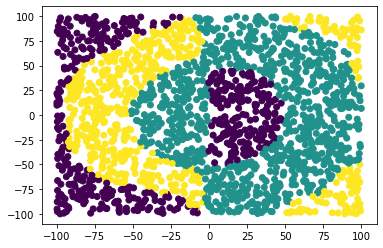

In [66]:
trainlossesES = nn.losses
vallossesES = nn.vallosses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

In [67]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.8898461262206844

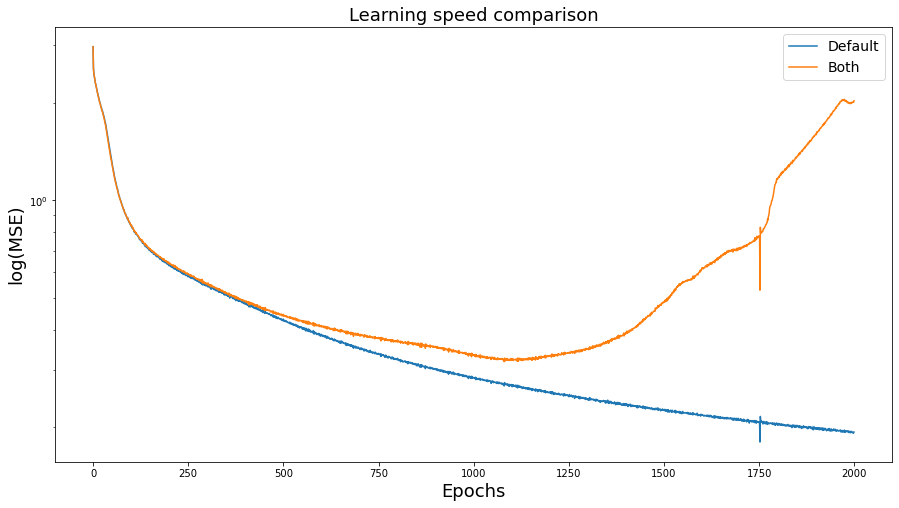

In [70]:
plt.figure(figsize=(15,8))
plt.plot(trainlossesDefault,label="Default")
plt.plot(trainlossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

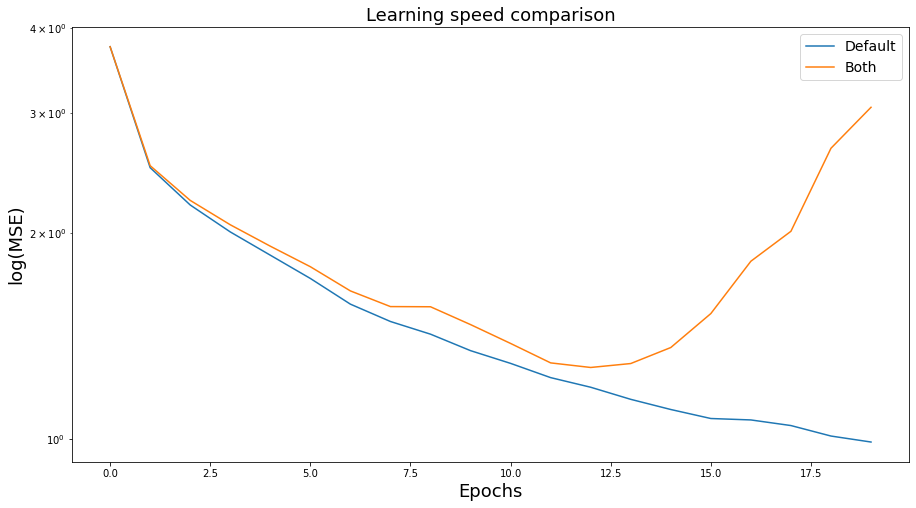

In [71]:
plt.figure(figsize=(15,8))
plt.plot(vallossesDefault,label="Default")
plt.plot(vallossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

# xor3-balance

In [5]:
train_df = pd.read_csv("data/xor3-balance-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/xor3-balance-test.csv",index_col=0).reset_index()

In [396]:
X_train = np.reshape(train_df[["x","y"]].values,(len(train_df),2))
Y_train = np.reshape(train_df["c"].values,(len(train_df),1))

In [397]:
X_test = np.reshape(test_df[["x","y"]].values,(len(test_df),2))
Y_test = np.reshape(test_df["c"].values,(len(test_df),1))

In [398]:
y_train = makeyxor3(Y_train)
y_test = makeyxor3(Y_test)

In [399]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Default

In [405]:
nn = NeuralNetwork(2,[100,2],["sigmoid","softmax"],["uniform","uniform","uniform"])
nn.compile(loss = "CE", optimizer= "RMSProp", lr = 0.01,with_regularization=False,early_stopping=False)

In [406]:
nn.fit(X_train_std.copy(), y_train.copy(),val=(X_test_std.copy(),y_test.copy()), epochs = 2000)

Epoch 1/2000 - loss: 7.4935829816150665
Validation loss: 4.222203732784798
Epoch 2/2000 - loss: 1.2061305009929293
Epoch 3/2000 - loss: 1.0563756113876788
Epoch 4/2000 - loss: 0.9807355314101768
Epoch 5/2000 - loss: 0.9356295208883196
Epoch 6/2000 - loss: 0.9067067934457158
Epoch 7/2000 - loss: 0.8873924128174879
Epoch 8/2000 - loss: 0.874144642666892
Epoch 9/2000 - loss: 0.8648572441446519
Epoch 10/2000 - loss: 0.8581988756391511
Epoch 11/2000 - loss: 0.8532999957499994
Epoch 12/2000 - loss: 0.8495866209445926
Epoch 13/2000 - loss: 0.8466820742616983
Epoch 14/2000 - loss: 0.8443431294276157
Epoch 15/2000 - loss: 0.8424157059782729
Epoch 16/2000 - loss: 0.8408033529391697
Epoch 17/2000 - loss: 0.8394451135426765
Epoch 18/2000 - loss: 0.8383006112596323
Epoch 19/2000 - loss: 0.8373406179024204
Epoch 20/2000 - loss: 0.8365415682768396
Epoch 21/2000 - loss: 0.8358827089282025
Epoch 22/2000 - loss: 0.835344849883276
Epoch 23/2000 - loss: 0.8349099872086334
Epoch 24/2000 - loss: 0.834561329

Epoch 199/2000 - loss: 0.6091175040552168
Epoch 200/2000 - loss: 1.031508656914681
Epoch 201/2000 - loss: 0.6091024924679979
Validation loss: 4.134324984368251
Epoch 202/2000 - loss: 1.0311044051363432
Epoch 203/2000 - loss: 0.6093697982747446
Epoch 204/2000 - loss: 1.0304420694521204
Epoch 205/2000 - loss: 0.6098955937531928
Epoch 206/2000 - loss: 1.029573702109675
Epoch 207/2000 - loss: 0.6105978641827025
Epoch 208/2000 - loss: 1.028557387488437
Epoch 209/2000 - loss: 0.6109363991252521
Epoch 210/2000 - loss: 1.0286485025065002
Epoch 211/2000 - loss: 0.6101742031004519
Epoch 212/2000 - loss: 1.029458957001579
Epoch 213/2000 - loss: 0.6092450736015403
Epoch 214/2000 - loss: 1.02930463489949
Epoch 215/2000 - loss: 0.6092277901187393
Epoch 216/2000 - loss: 1.028865013263645
Epoch 217/2000 - loss: 0.6095083716558477
Epoch 218/2000 - loss: 1.0281908602606358
Epoch 219/2000 - loss: 0.6100428372990282
Epoch 220/2000 - loss: 1.0272730986043297
Epoch 221/2000 - loss: 0.6107079804901717
Epoch 

Epoch 396/2000 - loss: 0.9911123434758706
Epoch 397/2000 - loss: 0.6046972359272775
Epoch 398/2000 - loss: 0.9904657536862602
Epoch 399/2000 - loss: 0.6045364663078628
Epoch 400/2000 - loss: 0.9898105213688922
Epoch 401/2000 - loss: 0.6043697992476177
Validation loss: 4.035149645016545
Epoch 402/2000 - loss: 0.989150035940636
Epoch 403/2000 - loss: 0.6041942298951445
Epoch 404/2000 - loss: 0.9884848909554499
Epoch 405/2000 - loss: 0.6040083239986715
Epoch 406/2000 - loss: 0.9878166725821743
Epoch 407/2000 - loss: 0.6038080199886244
Epoch 408/2000 - loss: 0.987151269892514
Epoch 409/2000 - loss: 0.603583249760658
Epoch 410/2000 - loss: 0.9865017940782161
Epoch 411/2000 - loss: 0.6033218426316652
Epoch 412/2000 - loss: 0.9858796489855238
Epoch 413/2000 - loss: 0.6030525500856698
Epoch 414/2000 - loss: 0.9851970277926395
Epoch 415/2000 - loss: 0.6028938094466348
Epoch 416/2000 - loss: 0.9842762594308407
Epoch 417/2000 - loss: 0.6028960339750818
Epoch 418/2000 - loss: 0.9833196524828245
Ep

Epoch 591/2000 - loss: 0.5698971905900616
Epoch 592/2000 - loss: 0.8805415100706826
Epoch 593/2000 - loss: 0.5693317319993535
Epoch 594/2000 - loss: 0.8790699949854364
Epoch 595/2000 - loss: 0.568763253628624
Epoch 596/2000 - loss: 0.8775944797717451
Epoch 597/2000 - loss: 0.568191846729258
Epoch 598/2000 - loss: 0.8761153222192047
Epoch 599/2000 - loss: 0.5676173658889843
Epoch 600/2000 - loss: 0.8746329154770832
Epoch 601/2000 - loss: 0.5670395942634957
Validation loss: 3.692723537858006
Epoch 602/2000 - loss: 0.8731474198831429
Epoch 603/2000 - loss: 0.5664585554332862
Epoch 604/2000 - loss: 0.8716584819428874
Epoch 605/2000 - loss: 0.5658747562372434
Epoch 606/2000 - loss: 0.8701651877284092
Epoch 607/2000 - loss: 0.5652890641360205
Epoch 608/2000 - loss: 0.8686665626507152
Epoch 609/2000 - loss: 0.564702121628526
Epoch 610/2000 - loss: 0.8671623853153347
Epoch 611/2000 - loss: 0.5641137895259588
Epoch 612/2000 - loss: 0.8656533204098343
Epoch 613/2000 - loss: 0.5635232757565963
Ep

Epoch 786/2000 - loss: 0.7235625369233712
Epoch 787/2000 - loss: 0.500844704657533
Epoch 788/2000 - loss: 0.7218717157746252
Epoch 789/2000 - loss: 0.5000168620943415
Epoch 790/2000 - loss: 0.7201806721284263
Epoch 791/2000 - loss: 0.4991874178045668
Epoch 792/2000 - loss: 0.718489312950066
Epoch 793/2000 - loss: 0.49835625552657997
Epoch 794/2000 - loss: 0.7167975898531733
Epoch 795/2000 - loss: 0.49752327292852877
Epoch 796/2000 - loss: 0.7151054757769716
Epoch 797/2000 - loss: 0.49668839154026434
Epoch 798/2000 - loss: 0.7134129443349901
Epoch 799/2000 - loss: 0.4958515580148185
Epoch 800/2000 - loss: 0.7117199674323538
Epoch 801/2000 - loss: 0.49501273684480956
Validation loss: 3.0799722364499655
Epoch 802/2000 - loss: 0.7100265223885623
Epoch 803/2000 - loss: 0.49417190162203456
Epoch 804/2000 - loss: 0.7083325977475823
Epoch 805/2000 - loss: 0.49332902959323355
Epoch 806/2000 - loss: 0.7066381944791661
Epoch 807/2000 - loss: 0.492484099759341
Epoch 808/2000 - loss: 0.704943324528

Epoch 980/2000 - loss: 0.5665590878580088
Epoch 981/2000 - loss: 0.41386753985087094
Epoch 982/2000 - loss: 0.5651319645745865
Epoch 983/2000 - loss: 0.41297956995674295
Epoch 984/2000 - loss: 0.5637105291616429
Epoch 985/2000 - loss: 0.41209329813111373
Epoch 986/2000 - loss: 0.562294820282998
Epoch 987/2000 - loss: 0.4112087503934331
Epoch 988/2000 - loss: 0.5608848923441144
Epoch 989/2000 - loss: 0.4103259515476531
Epoch 990/2000 - loss: 0.55948077714367
Epoch 991/2000 - loss: 0.40944493254254016
Epoch 992/2000 - loss: 0.5580824792486926
Epoch 993/2000 - loss: 0.4085657287158539
Epoch 994/2000 - loss: 0.5566899922921051
Epoch 995/2000 - loss: 0.40768837411489106
Epoch 996/2000 - loss: 0.5553033140765261
Epoch 997/2000 - loss: 0.4068128974885351
Epoch 998/2000 - loss: 0.553922449718046
Epoch 999/2000 - loss: 0.4059393217043537
Epoch 1000/2000 - loss: 0.5525474060138942
Epoch 1001/2000 - loss: 0.4050676651848358
Validation loss: 2.4732903111177693
Epoch 1002/2000 - loss: 0.55117818535

Epoch 1169/2000 - loss: 0.34029901064815354
Epoch 1170/2000 - loss: 0.4562985659549392
Epoch 1171/2000 - loss: 0.3396394052939639
Epoch 1172/2000 - loss: 0.4553999734788917
Epoch 1173/2000 - loss: 0.33896435971309563
Epoch 1174/2000 - loss: 0.45448688014365113
Epoch 1175/2000 - loss: 0.33828868061801987
Epoch 1176/2000 - loss: 0.4535663866585917
Epoch 1177/2000 - loss: 0.33762543506329135
Epoch 1178/2000 - loss: 0.4526576653505333
Epoch 1179/2000 - loss: 0.3369775547813242
Epoch 1180/2000 - loss: 0.4517716945271439
Epoch 1181/2000 - loss: 0.336338768155403
Epoch 1182/2000 - loss: 0.45090257271551837
Epoch 1183/2000 - loss: 0.3356980028075846
Epoch 1184/2000 - loss: 0.4500332624753623
Epoch 1185/2000 - loss: 0.3350484095748889
Epoch 1186/2000 - loss: 0.4491514656864982
Epoch 1187/2000 - loss: 0.3343934423938125
Epoch 1188/2000 - loss: 0.4482616125174694
Epoch 1189/2000 - loss: 0.33374173005195673
Epoch 1190/2000 - loss: 0.44737793146311244
Epoch 1191/2000 - loss: 0.3331001937925691
Epoc

Epoch 1358/2000 - loss: 0.38722662101382876
Epoch 1359/2000 - loss: 0.2878260139506517
Epoch 1360/2000 - loss: 0.3866766128887296
Epoch 1361/2000 - loss: 0.28757160477865595
Epoch 1362/2000 - loss: 0.38603434461550473
Epoch 1363/2000 - loss: 0.28753541293753077
Epoch 1364/2000 - loss: 0.38534122630127493
Epoch 1365/2000 - loss: 0.2873915832645501
Epoch 1366/2000 - loss: 0.38480181928145707
Epoch 1367/2000 - loss: 0.2866302469758818
Epoch 1368/2000 - loss: 0.38423361940277
Epoch 1369/2000 - loss: 0.2858305920442663
Epoch 1370/2000 - loss: 0.3836344828427492
Epoch 1371/2000 - loss: 0.2851913835946265
Epoch 1372/2000 - loss: 0.3830709156281197
Epoch 1373/2000 - loss: 0.2846978964324888
Epoch 1374/2000 - loss: 0.3825499694740489
Epoch 1375/2000 - loss: 0.2843305760038653
Epoch 1376/2000 - loss: 0.38203045177007416
Epoch 1377/2000 - loss: 0.2841112587392608
Epoch 1378/2000 - loss: 0.38142170277353765
Epoch 1379/2000 - loss: 0.2840956918889374
Epoch 1380/2000 - loss: 0.38079462383509394
Epoc

Epoch 1546/2000 - loss: 0.34064689255336894
Epoch 1547/2000 - loss: 0.2527714188241855
Epoch 1548/2000 - loss: 0.3402617792891362
Epoch 1549/2000 - loss: 0.25241642773659534
Epoch 1550/2000 - loss: 0.3398571197679342
Epoch 1551/2000 - loss: 0.2522101418250013
Epoch 1552/2000 - loss: 0.33945116590730784
Epoch 1553/2000 - loss: 0.2520853619401476
Epoch 1554/2000 - loss: 0.33903203590606124
Epoch 1555/2000 - loss: 0.25193157646744396
Epoch 1556/2000 - loss: 0.3385920136681463
Epoch 1557/2000 - loss: 0.25159848551847336
Epoch 1558/2000 - loss: 0.3381590800607836
Epoch 1559/2000 - loss: 0.25112637716050895
Epoch 1560/2000 - loss: 0.3377494891377203
Epoch 1561/2000 - loss: 0.25064762318682804
Epoch 1562/2000 - loss: 0.33737548494443
Epoch 1563/2000 - loss: 0.2502502451584352
Epoch 1564/2000 - loss: 0.3369884017476198
Epoch 1565/2000 - loss: 0.2500041097966715
Epoch 1566/2000 - loss: 0.336590240912104
Epoch 1567/2000 - loss: 0.24986866930329926
Epoch 1568/2000 - loss: 0.3361870118592608
Epoch

Epoch 1733/2000 - loss: 0.22806653269146973
Epoch 1734/2000 - loss: 0.30664218041665336
Epoch 1735/2000 - loss: 0.22772530986799422
Epoch 1736/2000 - loss: 0.3062988618047919
Epoch 1737/2000 - loss: 0.22738790107916623
Epoch 1738/2000 - loss: 0.3059625728643107
Epoch 1739/2000 - loss: 0.2271019201289922
Epoch 1740/2000 - loss: 0.3056535199859786
Epoch 1741/2000 - loss: 0.22689638118727626
Epoch 1742/2000 - loss: 0.30536534351700845
Epoch 1743/2000 - loss: 0.22676663192273247
Epoch 1744/2000 - loss: 0.3050768269336971
Epoch 1745/2000 - loss: 0.22666343774001288
Epoch 1746/2000 - loss: 0.30477705244858866
Epoch 1747/2000 - loss: 0.22646770506618838
Epoch 1748/2000 - loss: 0.3044757184318371
Epoch 1749/2000 - loss: 0.22615234960561673
Epoch 1750/2000 - loss: 0.30413752914090875
Epoch 1751/2000 - loss: 0.22582450807586696
Epoch 1752/2000 - loss: 0.3037951182906229
Epoch 1753/2000 - loss: 0.22553951438587969
Epoch 1754/2000 - loss: 0.30348446081876784
Epoch 1755/2000 - loss: 0.2253219465878

Epoch 1922/2000 - loss: 0.27987088958583833
Epoch 1923/2000 - loss: 0.20828168135501332
Epoch 1924/2000 - loss: 0.2796151242162451
Epoch 1925/2000 - loss: 0.20811830627584593
Epoch 1926/2000 - loss: 0.2793771287343489
Epoch 1927/2000 - loss: 0.20798651036575147
Epoch 1928/2000 - loss: 0.27913824918141
Epoch 1929/2000 - loss: 0.20785236781643837
Epoch 1930/2000 - loss: 0.2788906999581905
Epoch 1931/2000 - loss: 0.20766139373966622
Epoch 1932/2000 - loss: 0.27862726606414323
Epoch 1933/2000 - loss: 0.2074186536320725
Epoch 1934/2000 - loss: 0.2783419893447441
Epoch 1935/2000 - loss: 0.2071771279598658
Epoch 1936/2000 - loss: 0.2780644422605554
Epoch 1937/2000 - loss: 0.20696588463770396
Epoch 1938/2000 - loss: 0.2778126029713836
Epoch 1939/2000 - loss: 0.2068008420203199
Epoch 1940/2000 - loss: 0.2775790247626162
Epoch 1941/2000 - loss: 0.20668024210039296
Epoch 1942/2000 - loss: 0.2773365260418282
Epoch 1943/2000 - loss: 0.20657948082090083
Epoch 1944/2000 - loss: 0.2770804905722269
Epo

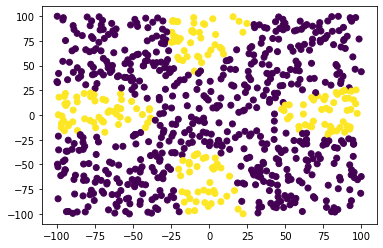

In [407]:
trainlossesDefault = nn.losses
vallossesDefault = nn.vallosses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

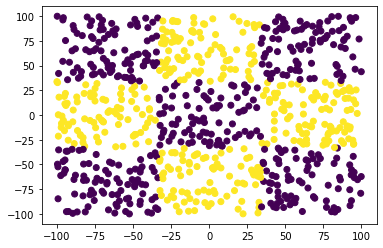

In [408]:
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

In [409]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.7700432900432901

## With weight regularization and early-stopping

In [418]:
nn = NeuralNetwork(2,[100,2],["sigmoid","softmax"],["uniform","uniform","uniform"])
nn.compile(loss = "CE", optimizer= "RMSProp", lr = 0.003,lmbda=0.0001,with_regularization=True,early_stopping=True)

In [419]:
nn.fit(X_train_std.copy(), y_train.copy(),val=(X_test_std.copy(),y_test.copy()),target=1.3, epochs = 10000)

Epoch 1/10000 - loss: 7.861138136324808
Validation loss: 4.782051111087387
Epoch 2/10000 - loss: 6.719066609984983
Epoch 3/10000 - loss: 5.432667897648919
Epoch 4/10000 - loss: 4.27533551502379
Epoch 5/10000 - loss: 3.4195737196586578
Epoch 6/10000 - loss: 2.8307184238624643
Epoch 7/10000 - loss: 2.4218226566147996
Epoch 8/10000 - loss: 2.1279996458281047
Epoch 9/10000 - loss: 1.9091586442839859
Epoch 10/10000 - loss: 1.7409834374035784
Epoch 11/10000 - loss: 1.6083345410965826
Epoch 12/10000 - loss: 1.501440365117929
Epoch 13/10000 - loss: 1.4137650131223216
Epoch 14/10000 - loss: 1.340792608090831
Epoch 15/10000 - loss: 1.279312065244082
Epoch 16/10000 - loss: 1.226981865531326
Epoch 17/10000 - loss: 1.182056471093593
Epoch 18/10000 - loss: 1.1432091048237338
Epoch 19/10000 - loss: 1.1094137779509994
Epoch 20/10000 - loss: 1.0798648064626915
Epoch 21/10000 - loss: 1.0539206773864556
Epoch 22/10000 - loss: 1.0310641071002344
Epoch 23/10000 - loss: 1.0108730975095908
Epoch 24/10000 - l

Epoch 193/10000 - loss: 0.8790542695424352
Epoch 194/10000 - loss: 0.7893344148213103
Epoch 195/10000 - loss: 0.8784856154595809
Epoch 196/10000 - loss: 0.7892470953113452
Epoch 197/10000 - loss: 0.8776757295321449
Epoch 198/10000 - loss: 0.7892463928341596
Epoch 199/10000 - loss: 0.8771344709801628
Epoch 200/10000 - loss: 0.7888869813278387
Epoch 201/10000 - loss: 0.8771347646395539
Validation loss: 4.156170050775304
Epoch 202/10000 - loss: 0.788011055717681
Epoch 203/10000 - loss: 0.8776602468577229
Epoch 204/10000 - loss: 0.7867456567904029
Epoch 205/10000 - loss: 0.8784586234857936
Epoch 206/10000 - loss: 0.7854101241554131
Epoch 207/10000 - loss: 0.8791729787103376
Epoch 208/10000 - loss: 0.7843501542396084
Epoch 209/10000 - loss: 0.8795301874643476
Epoch 210/10000 - loss: 0.783748198614602
Epoch 211/10000 - loss: 0.8794877463065153
Epoch 212/10000 - loss: 0.7835331906158536
Epoch 213/10000 - loss: 0.879225206275296
Epoch 214/10000 - loss: 0.7834614638809071
Epoch 215/10000 - loss

Epoch 383/10000 - loss: 0.865393802100635
Epoch 384/10000 - loss: 0.7784759270087469
Epoch 385/10000 - loss: 0.8650991534558147
Epoch 386/10000 - loss: 0.7784415323690711
Epoch 387/10000 - loss: 0.8648017805568939
Epoch 388/10000 - loss: 0.7784047460788318
Epoch 389/10000 - loss: 0.8645016244749956
Epoch 390/10000 - loss: 0.7783654804176896
Epoch 391/10000 - loss: 0.8641986456830406
Epoch 392/10000 - loss: 0.7783236359617327
Epoch 393/10000 - loss: 0.8638928177772045
Epoch 394/10000 - loss: 0.7782791128423742
Epoch 395/10000 - loss: 0.8635841139964401
Epoch 396/10000 - loss: 0.7782318242618135
Epoch 397/10000 - loss: 0.8632724962406876
Epoch 398/10000 - loss: 0.7781817031183689
Epoch 399/10000 - loss: 0.8629579136956748
Epoch 400/10000 - loss: 0.7781286981791715
Epoch 401/10000 - loss: 0.8626403103806966
Validation loss: 4.131506377963961
Epoch 402/10000 - loss: 0.7780727639730479
Epoch 403/10000 - loss: 0.8623196349350799
Epoch 404/10000 - loss: 0.7780138520818765
Epoch 405/10000 - lo

Epoch 573/10000 - loss: 0.8237857688127269
Epoch 574/10000 - loss: 0.7617018669690331
Epoch 575/10000 - loss: 0.8232218813148455
Epoch 576/10000 - loss: 0.7613879430089608
Epoch 577/10000 - loss: 0.8226577714526572
Epoch 578/10000 - loss: 0.7610666455317604
Epoch 579/10000 - loss: 0.8220977455394479
Epoch 580/10000 - loss: 0.7607299595536415
Epoch 581/10000 - loss: 0.8215582121247791
Epoch 582/10000 - loss: 0.7603543773408955
Epoch 583/10000 - loss: 0.8210733440885202
Epoch 584/10000 - loss: 0.7599852526802549
Epoch 585/10000 - loss: 0.8204943670808506
Epoch 586/10000 - loss: 0.7597516471727969
Epoch 587/10000 - loss: 0.819819098646423
Epoch 588/10000 - loss: 0.7595009468149062
Epoch 589/10000 - loss: 0.819193470461737
Epoch 590/10000 - loss: 0.7591603792671796
Epoch 591/10000 - loss: 0.8186200266893615
Epoch 592/10000 - loss: 0.7587684458055847
Epoch 593/10000 - loss: 0.818056048097033
Epoch 594/10000 - loss: 0.7583748232571763
Epoch 595/10000 - loss: 0.8174706675543023
Epoch 596/1000

Epoch 763/10000 - loss: 0.7466978696426393
Epoch 764/10000 - loss: 0.707844167339688
Epoch 765/10000 - loss: 0.7455986110605
Epoch 766/10000 - loss: 0.7069708060925917
Epoch 767/10000 - loss: 0.7444936803243457
Epoch 768/10000 - loss: 0.7060910667741583
Epoch 769/10000 - loss: 0.7433831562516005
Epoch 770/10000 - loss: 0.7052050258420146
Epoch 771/10000 - loss: 0.7422671120281755
Epoch 772/10000 - loss: 0.7043127603505344
Epoch 773/10000 - loss: 0.7411456231031784
Epoch 774/10000 - loss: 0.7034143405194544
Epoch 775/10000 - loss: 0.7400187727875718
Epoch 776/10000 - loss: 0.7025098263478804
Epoch 777/10000 - loss: 0.7388866532921246
Epoch 778/10000 - loss: 0.70159926873589
Epoch 779/10000 - loss: 0.7377493631634677
Epoch 780/10000 - loss: 0.7006827130073621
Epoch 781/10000 - loss: 0.7366070037117336
Epoch 782/10000 - loss: 0.6997602027081642
Epoch 783/10000 - loss: 0.7354596764299415
Epoch 784/10000 - loss: 0.6988317839213638
Epoch 785/10000 - loss: 0.7343074809470179
Epoch 786/10000 -

Epoch 954/10000 - loss: 0.6125087039489763
Epoch 955/10000 - loss: 0.6328940201237284
Epoch 956/10000 - loss: 0.6116013621925417
Epoch 957/10000 - loss: 0.631861193552367
Epoch 958/10000 - loss: 0.6107003329940841
Epoch 959/10000 - loss: 0.6308359503227426
Epoch 960/10000 - loss: 0.60980567343107
Epoch 961/10000 - loss: 0.6298183866809943
Epoch 962/10000 - loss: 0.6089174366440797
Epoch 963/10000 - loss: 0.6288086021799388
Epoch 964/10000 - loss: 0.6080356770737005
Epoch 965/10000 - loss: 0.6278066861553452
Epoch 966/10000 - loss: 0.607160463526842
Epoch 967/10000 - loss: 0.6268126877411728
Epoch 968/10000 - loss: 0.6062918991370556
Epoch 969/10000 - loss: 0.625826580065929
Epoch 970/10000 - loss: 0.6054301310284197
Epoch 971/10000 - loss: 0.6248482571545914
Epoch 972/10000 - loss: 0.6045753210267732
Epoch 973/10000 - loss: 0.6238775968490847
Epoch 974/10000 - loss: 0.603727577075579
Epoch 975/10000 - loss: 0.6229145568283428
Epoch 976/10000 - loss: 0.6028868962746848
Epoch 977/10000 -

Epoch 1141/10000 - loss: 0.5690567099352266
Epoch 1142/10000 - loss: 0.5559450327669033
Epoch 1143/10000 - loss: 0.5686464015803077
Epoch 1144/10000 - loss: 0.5555883159304376
Epoch 1145/10000 - loss: 0.5682419653572449
Epoch 1146/10000 - loss: 0.5552373363740961
Epoch 1147/10000 - loss: 0.5678435254208267
Epoch 1148/10000 - loss: 0.5548920969822417
Epoch 1149/10000 - loss: 0.5674509516611898
Epoch 1150/10000 - loss: 0.5545523835525555
Epoch 1151/10000 - loss: 0.567063981931568
Epoch 1152/10000 - loss: 0.5542178952100415
Epoch 1153/10000 - loss: 0.5666823303646777
Epoch 1154/10000 - loss: 0.553888344945136
Epoch 1155/10000 - loss: 0.5663057647760834
Epoch 1156/10000 - loss: 0.5535635223030289
Epoch 1157/10000 - loss: 0.5659341485562661
Epoch 1158/10000 - loss: 0.5532433186036728
Epoch 1159/10000 - loss: 0.5655674477171567
Epoch 1160/10000 - loss: 0.5529277190702748
Epoch 1161/10000 - loss: 0.5652057111432948
Epoch 1162/10000 - loss: 0.5526167742062341
Epoch 1163/10000 - loss: 0.5648490

Epoch 1326/10000 - loss: 0.5402481044860603
Epoch 1327/10000 - loss: 0.5494027467753115
Epoch 1328/10000 - loss: 0.5402492455607695
Epoch 1329/10000 - loss: 0.5492605995812274
Epoch 1330/10000 - loss: 0.540176768267593
Epoch 1331/10000 - loss: 0.5491543097473623
Epoch 1332/10000 - loss: 0.5401032435749653
Epoch 1333/10000 - loss: 0.5490005044859668
Epoch 1334/10000 - loss: 0.5400601549265769
Epoch 1335/10000 - loss: 0.548817655160791
Epoch 1336/10000 - loss: 0.5399860149201027
Epoch 1337/10000 - loss: 0.5487133375737859
Epoch 1338/10000 - loss: 0.5398090502965662
Epoch 1339/10000 - loss: 0.5487466763754371
Epoch 1340/10000 - loss: 0.5395492087623432
Epoch 1341/10000 - loss: 0.5488257055165613
Epoch 1342/10000 - loss: 0.53938166192934
Epoch 1343/10000 - loss: 0.5487174717936791
Epoch 1344/10000 - loss: 0.5394291373356164
Epoch 1345/10000 - loss: 0.5484623059761722
Epoch 1346/10000 - loss: 0.5395008908770781
Epoch 1347/10000 - loss: 0.5482810584719362
Epoch 1348/10000 - loss: 0.539467599

Epoch 1512/10000 - loss: 0.5365738361434329
Epoch 1513/10000 - loss: 0.5438603664218368
Epoch 1514/10000 - loss: 0.5366255493383906
Epoch 1515/10000 - loss: 0.543816495922169
Epoch 1516/10000 - loss: 0.5366498858176294
Epoch 1517/10000 - loss: 0.5437801818329598
Epoch 1518/10000 - loss: 0.5366649567167145
Epoch 1519/10000 - loss: 0.5437460042541328
Epoch 1520/10000 - loss: 0.5366501444622769
Epoch 1521/10000 - loss: 0.5437525990050116
Epoch 1522/10000 - loss: 0.5365802912037305
Epoch 1523/10000 - loss: 0.5438194854678964
Epoch 1524/10000 - loss: 0.5364743073076594
Epoch 1525/10000 - loss: 0.5438979889799652
Epoch 1526/10000 - loss: 0.5364125471599863
Epoch 1527/10000 - loss: 0.5438942663442056
Epoch 1528/10000 - loss: 0.5364518271761669
Epoch 1529/10000 - loss: 0.543810808917735
Epoch 1530/10000 - loss: 0.5365307507028013
Epoch 1531/10000 - loss: 0.5437329695155448
Epoch 1532/10000 - loss: 0.5365839137167937
Epoch 1533/10000 - loss: 0.5436889288818888
Epoch 1534/10000 - loss: 0.5366127

Epoch 1699/10000 - loss: 0.5428598110951007
Epoch 1700/10000 - loss: 0.5363945254507972
Epoch 1701/10000 - loss: 0.5429248155442357
Validation loss: 3.1360693614363493
Epoch 1702/10000 - loss: 0.5362721983496213
Epoch 1703/10000 - loss: 0.5430261295182557
Epoch 1704/10000 - loss: 0.5361682785429275
Epoch 1705/10000 - loss: 0.543062763500995
Epoch 1706/10000 - loss: 0.5361641733817469
Epoch 1707/10000 - loss: 0.5429942166502771
Epoch 1708/10000 - loss: 0.5362386172465766
Epoch 1709/10000 - loss: 0.5428939001598504
Epoch 1710/10000 - loss: 0.5363105484509745
Epoch 1711/10000 - loss: 0.5428251301874596
Epoch 1712/10000 - loss: 0.5363556600667685
Epoch 1713/10000 - loss: 0.5427781918857782
Epoch 1714/10000 - loss: 0.536376234017518
Epoch 1715/10000 - loss: 0.5427420058467126
Epoch 1716/10000 - loss: 0.5363538373183556
Epoch 1717/10000 - loss: 0.5427536446634248
Epoch 1718/10000 - loss: 0.5362631051283512
Epoch 1719/10000 - loss: 0.5428395153892368
Epoch 1720/10000 - loss: 0.536130978919742

Epoch 1885/10000 - loss: 0.5406368709890382
Epoch 1886/10000 - loss: 0.5342788266733378
Epoch 1887/10000 - loss: 0.5405980773278996
Epoch 1888/10000 - loss: 0.5342360734375751
Epoch 1889/10000 - loss: 0.5405745578082964
Epoch 1890/10000 - loss: 0.5341718159460368
Epoch 1891/10000 - loss: 0.5405748404654573
Epoch 1892/10000 - loss: 0.5340979920610276
Epoch 1893/10000 - loss: 0.5405713500278423
Epoch 1894/10000 - loss: 0.5340488899586435
Epoch 1895/10000 - loss: 0.5405310005395281
Epoch 1896/10000 - loss: 0.5340373099868645
Epoch 1897/10000 - loss: 0.5404624990564025
Epoch 1898/10000 - loss: 0.5340374064050198
Epoch 1899/10000 - loss: 0.5403979527333204
Epoch 1900/10000 - loss: 0.5340236091353444
Epoch 1901/10000 - loss: 0.5403485076674187
Validation loss: 3.1150308316300475
Epoch 1902/10000 - loss: 0.533994328180775
Epoch 1903/10000 - loss: 0.5403077422946763
Epoch 1904/10000 - loss: 0.5339539199836894
Epoch 1905/10000 - loss: 0.5402765974990524
Epoch 1906/10000 - loss: 0.53389891458811

Epoch 2071/10000 - loss: 0.5351817325549746
Epoch 2072/10000 - loss: 0.5290219646903099
Epoch 2073/10000 - loss: 0.5350864387861003
Epoch 2074/10000 - loss: 0.5289302031941591
Epoch 2075/10000 - loss: 0.5349902398784065
Epoch 2076/10000 - loss: 0.5288375134435604
Epoch 2077/10000 - loss: 0.534893156789303
Epoch 2078/10000 - loss: 0.5287438844130753
Epoch 2079/10000 - loss: 0.5347951984193169
Epoch 2080/10000 - loss: 0.5286493250039405
Epoch 2081/10000 - loss: 0.53469636069221
Epoch 2082/10000 - loss: 0.5285538584031343
Epoch 2083/10000 - loss: 0.5345966350106374
Epoch 2084/10000 - loss: 0.528457510637154
Epoch 2085/10000 - loss: 0.5344960190604295
Epoch 2086/10000 - loss: 0.5283603008598194
Epoch 2087/10000 - loss: 0.5343945228362976
Epoch 2088/10000 - loss: 0.5282622384488422
Epoch 2089/10000 - loss: 0.5342921669395989
Epoch 2090/10000 - loss: 0.5281633270280538
Epoch 2091/10000 - loss: 0.5341889753639236
Epoch 2092/10000 - loss: 0.528063571464073
Epoch 2093/10000 - loss: 0.5340849678

Epoch 2257/10000 - loss: 0.5209661224949202
Epoch 2258/10000 - loss: 0.5153439744855448
Epoch 2259/10000 - loss: 0.5207405801860538
Epoch 2260/10000 - loss: 0.5150971403476531
Epoch 2261/10000 - loss: 0.5205090299986315
Epoch 2262/10000 - loss: 0.5148571382937809
Epoch 2263/10000 - loss: 0.520265790512638
Epoch 2264/10000 - loss: 0.514617986206367
Epoch 2265/10000 - loss: 0.5200252432305381
Epoch 2266/10000 - loss: 0.5143681757048194
Epoch 2267/10000 - loss: 0.5197939353197747
Epoch 2268/10000 - loss: 0.514112942599259
Epoch 2269/10000 - loss: 0.5195512338478648
Epoch 2270/10000 - loss: 0.5138812631122927
Epoch 2271/10000 - loss: 0.5192696707261246
Epoch 2272/10000 - loss: 0.5136712494501064
Epoch 2273/10000 - loss: 0.5189818834309556
Epoch 2274/10000 - loss: 0.5134391088605166
Epoch 2275/10000 - loss: 0.5187247322813121
Epoch 2276/10000 - loss: 0.5131742632797646
Epoch 2277/10000 - loss: 0.5184851114061465
Epoch 2278/10000 - loss: 0.5129038694661795
Epoch 2279/10000 - loss: 0.51823282

Epoch 2443/10000 - loss: 0.49219822394611173
Epoch 2444/10000 - loss: 0.48743790550070887
Epoch 2445/10000 - loss: 0.49190144833830246
Epoch 2446/10000 - loss: 0.4870657299294166
Epoch 2447/10000 - loss: 0.4916105727448265
Epoch 2448/10000 - loss: 0.4867093447069042
Epoch 2449/10000 - loss: 0.49129386977884354
Epoch 2450/10000 - loss: 0.4863803299724492
Epoch 2451/10000 - loss: 0.4909559971900208
Epoch 2452/10000 - loss: 0.48606546540485634
Epoch 2453/10000 - loss: 0.4906081749607202
Epoch 2454/10000 - loss: 0.4857634496638786
Epoch 2455/10000 - loss: 0.4902396796692161
Epoch 2456/10000 - loss: 0.48547705777101474
Epoch 2457/10000 - loss: 0.48986488478357926
Epoch 2458/10000 - loss: 0.48517474508155106
Epoch 2459/10000 - loss: 0.4895252625324633
Epoch 2460/10000 - loss: 0.48483210911561586
Epoch 2461/10000 - loss: 0.48922735763293684
Epoch 2462/10000 - loss: 0.4844671472396008
Epoch 2463/10000 - loss: 0.48893762337813984
Epoch 2464/10000 - loss: 0.4841145726159236
Epoch 2465/10000 - lo

Epoch 2627/10000 - loss: 0.4639933532009399
Epoch 2628/10000 - loss: 0.4599599391418615
Epoch 2629/10000 - loss: 0.4637074431329656
Epoch 2630/10000 - loss: 0.45970076377896973
Epoch 2631/10000 - loss: 0.4634276935679407
Epoch 2632/10000 - loss: 0.4594352005361843
Epoch 2633/10000 - loss: 0.463157227833418
Epoch 2634/10000 - loss: 0.4591634896679586
Epoch 2635/10000 - loss: 0.4628933854507662
Epoch 2636/10000 - loss: 0.45889023270984375
Epoch 2637/10000 - loss: 0.4626300918133082
Epoch 2638/10000 - loss: 0.4586208595087497
Epoch 2639/10000 - loss: 0.4623621645462041
Epoch 2640/10000 - loss: 0.4583582630175713
Epoch 2641/10000 - loss: 0.46208806601315755
Epoch 2642/10000 - loss: 0.45810163118979647
Epoch 2643/10000 - loss: 0.4618102179655187
Epoch 2644/10000 - loss: 0.4578472274958924
Epoch 2645/10000 - loss: 0.46153351962500505
Epoch 2646/10000 - loss: 0.45759055350407296
Epoch 2647/10000 - loss: 0.4612624278653408
Epoch 2648/10000 - loss: 0.4573291439872157
Epoch 2649/10000 - loss: 0.

Epoch 2812/10000 - loss: 0.4380255154988398
Epoch 2813/10000 - loss: 0.4411162718596371
Epoch 2814/10000 - loss: 0.43780907512587497
Epoch 2815/10000 - loss: 0.4408926891892877
Epoch 2816/10000 - loss: 0.4375929115292885
Epoch 2817/10000 - loss: 0.44066938353428936
Epoch 2818/10000 - loss: 0.4373770174191422
Epoch 2819/10000 - loss: 0.4404463537081712
Epoch 2820/10000 - loss: 0.43716138822878126
Epoch 2821/10000 - loss: 0.44022359559090674
Epoch 2822/10000 - loss: 0.4369460219948947
Epoch 2823/10000 - loss: 0.4400011032279178
Epoch 2824/10000 - loss: 0.4367309179326768
Epoch 2825/10000 - loss: 0.4397788707934246
Epoch 2826/10000 - loss: 0.43651607479877974
Epoch 2827/10000 - loss: 0.43955689411912224
Epoch 2828/10000 - loss: 0.4363014899921422
Epoch 2829/10000 - loss: 0.43933517104188524
Epoch 2830/10000 - loss: 0.4360871597028531
Epoch 2831/10000 - loss: 0.4391137006649255
Epoch 2832/10000 - loss: 0.4358730797611692
Epoch 2833/10000 - loss: 0.4388924822106272
Epoch 2834/10000 - loss: 

Epoch 2997/10000 - loss: 0.4216004811288852
Epoch 2998/10000 - loss: 0.4189292978904743
Epoch 2999/10000 - loss: 0.42140181889326167
Epoch 3000/10000 - loss: 0.4187369384599165
Epoch 3001/10000 - loss: 0.42120349860012524
Validation loss: 2.703340009105816
Epoch 3002/10000 - loss: 0.41854493714449953
Epoch 3003/10000 - loss: 0.4210055224755343
Epoch 3004/10000 - loss: 0.41835328804887084
Epoch 3005/10000 - loss: 0.42080789352120873
Epoch 3006/10000 - loss: 0.4181619852316349
Epoch 3007/10000 - loss: 0.4206106118508198
Epoch 3008/10000 - loss: 0.41797102479415227
Epoch 3009/10000 - loss: 0.42041367250547834
Epoch 3010/10000 - loss: 0.41778040435763913
Epoch 3011/10000 - loss: 0.4202170670611844
Epoch 3012/10000 - loss: 0.41759012008595575
Epoch 3013/10000 - loss: 0.4200207891753439
Epoch 3014/10000 - loss: 0.417400163900252
Epoch 3015/10000 - loss: 0.41982484001329784
Epoch 3016/10000 - loss: 0.4172105234901396
Epoch 3017/10000 - loss: 0.4196292284702845
Epoch 3018/10000 - loss: 0.41702

Epoch 3181/10000 - loss: 0.4048168991117846
Epoch 3182/10000 - loss: 0.4026282107928275
Epoch 3183/10000 - loss: 0.4046469111943899
Epoch 3184/10000 - loss: 0.4024783560449118
Epoch 3185/10000 - loss: 0.4044687263319743
Epoch 3186/10000 - loss: 0.4023356941401422
Epoch 3187/10000 - loss: 0.40428058401641676
Epoch 3188/10000 - loss: 0.40218971776298035
Epoch 3189/10000 - loss: 0.40410750796868056
Epoch 3190/10000 - loss: 0.4020239089676563
Epoch 3191/10000 - loss: 0.40396501562954784
Epoch 3192/10000 - loss: 0.4018413071576593
Epoch 3193/10000 - loss: 0.4038367285416653
Epoch 3194/10000 - loss: 0.40166316072581965
Epoch 3195/10000 - loss: 0.4036942084054604
Epoch 3196/10000 - loss: 0.40150424507307403
Epoch 3197/10000 - loss: 0.40353032897179125
Epoch 3198/10000 - loss: 0.40135853339129685
Epoch 3199/10000 - loss: 0.40336023994453807
Epoch 3200/10000 - loss: 0.4012142875053145
Epoch 3201/10000 - loss: 0.4031900495071418
Validation loss: 2.6500089881903763
Epoch 3202/10000 - loss: 0.4010

Epoch 3366/10000 - loss: 0.38992418969818493
Epoch 3367/10000 - loss: 0.39166357106065947
Epoch 3368/10000 - loss: 0.38981208513654264
Epoch 3369/10000 - loss: 0.39153680413956227
Epoch 3370/10000 - loss: 0.3897003448910097
Epoch 3371/10000 - loss: 0.39141226115306693
Epoch 3372/10000 - loss: 0.3895861295913479
Epoch 3373/10000 - loss: 0.39129263753514015
Epoch 3374/10000 - loss: 0.38946831910655866
Epoch 3375/10000 - loss: 0.39117795638791625
Epoch 3376/10000 - loss: 0.3893480699105689
Epoch 3377/10000 - loss: 0.39106566342886473
Epoch 3378/10000 - loss: 0.38922800761895326
Epoch 3379/10000 - loss: 0.3909523099016106
Epoch 3380/10000 - loss: 0.38911057847430625
Epoch 3381/10000 - loss: 0.3908356457890754
Epoch 3382/10000 - loss: 0.38899668998787923
Epoch 3383/10000 - loss: 0.39071571402290844
Epoch 3384/10000 - loss: 0.3888854259032271
Epoch 3385/10000 - loss: 0.39059448858984364
Epoch 3386/10000 - loss: 0.38877477599573845
Epoch 3387/10000 - loss: 0.3904745829646115
Epoch 3388/10000 

Epoch 3551/10000 - loss: 0.3820232596421606
Epoch 3552/10000 - loss: 0.3803655653261586
Epoch 3553/10000 - loss: 0.3819309267966308
Epoch 3554/10000 - loss: 0.38027487904909624
Epoch 3555/10000 - loss: 0.3818387989501549
Epoch 3556/10000 - loss: 0.3801843913975696
Epoch 3557/10000 - loss: 0.38174687438029864
Epoch 3558/10000 - loss: 0.3800941012136119
Epoch 3559/10000 - loss: 0.38165515160920643
Epoch 3560/10000 - loss: 0.3800040071785035
Epoch 3561/10000 - loss: 0.38156362942388533
Epoch 3562/10000 - loss: 0.3799141078490831
Epoch 3563/10000 - loss: 0.38147230677133215
Epoch 3564/10000 - loss: 0.37982440177303417
Epoch 3565/10000 - loss: 0.38138118261177134
Epoch 3566/10000 - loss: 0.3797348876046224
Epoch 3567/10000 - loss: 0.3812902558174505
Epoch 3568/10000 - loss: 0.37964556415916195
Epoch 3569/10000 - loss: 0.38119952516121036
Epoch 3570/10000 - loss: 0.3795564303905102
Epoch 3571/10000 - loss: 0.38110898938164534
Epoch 3572/10000 - loss: 0.37946748532030145
Epoch 3573/10000 - lo

Epoch 3734/10000 - loss: 0.3728553413800904
Epoch 3735/10000 - loss: 0.3743112645446764
Epoch 3736/10000 - loss: 0.3727811108721893
Epoch 3737/10000 - loss: 0.37423607093241323
Epoch 3738/10000 - loss: 0.3727070612508569
Epoch 3739/10000 - loss: 0.37416106243200226
Epoch 3740/10000 - loss: 0.3726331917534292
Epoch 3741/10000 - loss: 0.3740862382125145
Epoch 3742/10000 - loss: 0.37255950155658446
Epoch 3743/10000 - loss: 0.37401159738033823
Epoch 3744/10000 - loss: 0.37248598977748754
Epoch 3745/10000 - loss: 0.37393713898040026
Epoch 3746/10000 - loss: 0.37241265547511126
Epoch 3747/10000 - loss: 0.3738628619975844
Epoch 3748/10000 - loss: 0.3723394976517231
Epoch 3749/10000 - loss: 0.3737887653583227
Epoch 3750/10000 - loss: 0.3722665152545227
Epoch 3751/10000 - loss: 0.37371484793233745
Epoch 3752/10000 - loss: 0.3721937071774155
Epoch 3753/10000 - loss: 0.3736411085345153
Epoch 3754/10000 - loss: 0.37212107226291014
Epoch 3755/10000 - loss: 0.373567545926898
Epoch 3756/10000 - loss:

Epoch 3917/10000 - loss: 0.36805476319099695
Epoch 3918/10000 - loss: 0.36661522633582305
Epoch 3919/10000 - loss: 0.36799086346782434
Epoch 3920/10000 - loss: 0.3665522640275545
Epoch 3921/10000 - loss: 0.36792705219759875
Epoch 3922/10000 - loss: 0.3664893900908564
Epoch 3923/10000 - loss: 0.36786332953579837
Epoch 3924/10000 - loss: 0.3664266046673785
Epoch 3925/10000 - loss: 0.36779969561669673
Epoch 3926/10000 - loss: 0.3663639078755615
Epoch 3927/10000 - loss: 0.3677361505431217
Epoch 3928/10000 - loss: 0.36630129980074
Epoch 3929/10000 - loss: 0.3676726943750125
Epoch 3930/10000 - loss: 0.3662387804841879
Epoch 3931/10000 - loss: 0.3676093271166989
Epoch 3932/10000 - loss: 0.36617634991108183
Epoch 3933/10000 - loss: 0.36754604870284197
Epoch 3934/10000 - loss: 0.3661140079973891
Epoch 3935/10000 - loss: 0.36748285898299177
Epoch 3936/10000 - loss: 0.3660517545757259
Epoch 3937/10000 - loss: 0.36741975770473034
Epoch 3938/10000 - loss: 0.3659895893802786
Epoch 3939/10000 - loss:

Epoch 4102/10000 - loss: 0.3608916306677221
Epoch 4103/10000 - loss: 0.3621829511632241
Epoch 4104/10000 - loss: 0.3608280853942792
Epoch 4105/10000 - loss: 0.36211850422366415
Epoch 4106/10000 - loss: 0.36076453953153087
Epoch 4107/10000 - loss: 0.3620540580843445
Epoch 4108/10000 - loss: 0.3607009939067719
Epoch 4109/10000 - loss: 0.3619896135596789
Epoch 4110/10000 - loss: 0.36063744927921737
Epoch 4111/10000 - loss: 0.36192517139015284
Epoch 4112/10000 - loss: 0.3605739063383085
Epoch 4113/10000 - loss: 0.3618607322452815
Epoch 4114/10000 - loss: 0.36051036570220546
Epoch 4115/10000 - loss: 0.36179629672562885
Epoch 4116/10000 - loss: 0.36044682791760496
Epoch 4117/10000 - loss: 0.36173186536320373
Epoch 4118/10000 - loss: 0.36038329346109266
Epoch 4119/10000 - loss: 0.3616674386205962
Epoch 4120/10000 - loss: 0.3603197627413725
Epoch 4121/10000 - loss: 0.36160301688988405
Epoch 4122/10000 - loss: 0.36025623610137963
Epoch 4123/10000 - loss: 0.3615386004923209
Epoch 4124/10000 - lo

Epoch 4287/10000 - loss: 0.35621047905332676
Epoch 4288/10000 - loss: 0.354938486534821
Epoch 4289/10000 - loss: 0.35614357703955607
Epoch 4290/10000 - loss: 0.3548725996408471
Epoch 4291/10000 - loss: 0.3560766053630416
Epoch 4292/10000 - loss: 0.354806647430421
Epoch 4293/10000 - loss: 0.3560095647827432
Epoch 4294/10000 - loss: 0.3547406303971219
Epoch 4295/10000 - loss: 0.3559424561354631
Epoch 4296/10000 - loss: 0.35467454911399005
Epoch 4297/10000 - loss: 0.3558752802707901
Epoch 4298/10000 - loss: 0.35460840428917123
Epoch 4299/10000 - loss: 0.35580803793263516
Epoch 4300/10000 - loss: 0.35454219685257693
Epoch 4301/10000 - loss: 0.3557407295969066
Validation loss: 2.5037061664905393
Epoch 4302/10000 - loss: 0.35447592803997013
Epoch 4303/10000 - loss: 0.355673355330783
Epoch 4304/10000 - loss: 0.3544095993949895
Epoch 4305/10000 - loss: 0.35560591475573256
Epoch 4306/10000 - loss: 0.3543432126640871
Epoch 4307/10000 - loss: 0.35553840688431754
Epoch 4308/10000 - loss: 0.3542767

Epoch 4471/10000 - loss: 0.3497464272869923
Epoch 4472/10000 - loss: 0.34857357303397857
Epoch 4473/10000 - loss: 0.3496886903234201
Epoch 4474/10000 - loss: 0.34849108843877125
Epoch 4475/10000 - loss: 0.34961282655645215
Epoch 4476/10000 - loss: 0.3484265227586877
Epoch 4477/10000 - loss: 0.3495222578115444
Epoch 4478/10000 - loss: 0.34836716780772814
Epoch 4479/10000 - loss: 0.34943746471588083
Epoch 4480/10000 - loss: 0.3482979046195327
Epoch 4481/10000 - loss: 0.3493675500920519
Epoch 4482/10000 - loss: 0.3482152142108404
Epoch 4483/10000 - loss: 0.3493097030035832
Epoch 4484/10000 - loss: 0.348126237855002
Epoch 4485/10000 - loss: 0.34924923442121014
Epoch 4486/10000 - loss: 0.34804780240230654
Epoch 4487/10000 - loss: 0.34916726665874603
Epoch 4488/10000 - loss: 0.34798818578691076
Epoch 4489/10000 - loss: 0.3490725905268175
Epoch 4490/10000 - loss: 0.3479315237905121
Epoch 4491/10000 - loss: 0.3489861252174541
Epoch 4492/10000 - loss: 0.3478629421438134
Epoch 4493/10000 - loss:

Epoch 4656/10000 - loss: 0.341362217024973
Epoch 4657/10000 - loss: 0.34242072863033085
Epoch 4658/10000 - loss: 0.3412821293478229
Epoch 4659/10000 - loss: 0.34230942483587434
Epoch 4660/10000 - loss: 0.34122187838982737
Epoch 4661/10000 - loss: 0.34219389581680476
Epoch 4662/10000 - loss: 0.34115486080311225
Epoch 4663/10000 - loss: 0.34209593664078597
Epoch 4664/10000 - loss: 0.3410682258658339
Epoch 4665/10000 - loss: 0.3420193602273639
Epoch 4666/10000 - loss: 0.3409627373587384
Epoch 4667/10000 - loss: 0.3419572846575469
Epoch 4668/10000 - loss: 0.34085020144486006
Epoch 4669/10000 - loss: 0.3418899516652963
Epoch 4670/10000 - loss: 0.34075377349335545
Epoch 4671/10000 - loss: 0.34179098834134175
Epoch 4672/10000 - loss: 0.340685663341337
Epoch 4673/10000 - loss: 0.3416727726691734
Epoch 4674/10000 - loss: 0.34062131484364855
Epoch 4675/10000 - loss: 0.3415665431878098
Epoch 4676/10000 - loss: 0.3405400543451757
Epoch 4677/10000 - loss: 0.34148205083939265
Epoch 4678/10000 - loss

Epoch 4840/10000 - loss: 0.33297377119762955
Epoch 4841/10000 - loss: 0.3338042423210835
Epoch 4842/10000 - loss: 0.3328571231787107
Epoch 4843/10000 - loss: 0.3337454612865227
Epoch 4844/10000 - loss: 0.33272577610542076
Epoch 4845/10000 - loss: 0.33369186794081596
Epoch 4846/10000 - loss: 0.33260170445558745
Epoch 4847/10000 - loss: 0.33361523480882094
Epoch 4848/10000 - loss: 0.33251135772663354
Epoch 4849/10000 - loss: 0.33349039504353956
Epoch 4850/10000 - loss: 0.33245940366912746
Epoch 4851/10000 - loss: 0.33334544637089353
Epoch 4852/10000 - loss: 0.3324065054115594
Epoch 4853/10000 - loss: 0.3332242915046843
Epoch 4854/10000 - loss: 0.3323269251470854
Epoch 4855/10000 - loss: 0.33313489072915187
Epoch 4856/10000 - loss: 0.33221863552182473
Epoch 4857/10000 - loss: 0.3330712113340618
Epoch 4858/10000 - loss: 0.3320903164952435
Epoch 4859/10000 - loss: 0.3330195997592905
Epoch 4860/10000 - loss: 0.3319604001590931
Epoch 4861/10000 - loss: 0.3329561005320205
Epoch 4862/10000 - lo

Epoch 5023/10000 - loss: 0.3257696946865285
Epoch 5024/10000 - loss: 0.324970520668897
Epoch 5025/10000 - loss: 0.3256877805097791
Epoch 5026/10000 - loss: 0.3248796410589187
Epoch 5027/10000 - loss: 0.32564123494713393
Epoch 5028/10000 - loss: 0.3247615774605952
Epoch 5029/10000 - loss: 0.32561014250942283
Epoch 5030/10000 - loss: 0.32463781631673516
Epoch 5031/10000 - loss: 0.3255696650352108
Epoch 5032/10000 - loss: 0.32453186142786966
Epoch 5033/10000 - loss: 0.3255042510161605
Epoch 5034/10000 - loss: 0.324453461809739
Epoch 5035/10000 - loss: 0.32541006452289023
Epoch 5036/10000 - loss: 0.32440350754625513
Epoch 5037/10000 - loss: 0.3252816294476988
Epoch 5038/10000 - loss: 0.32437823115027287
Epoch 5039/10000 - loss: 0.3251492693783542
Epoch 5040/10000 - loss: 0.32433800739915175
Epoch 5041/10000 - loss: 0.32505799763722226
Epoch 5042/10000 - loss: 0.3242597864624282
Epoch 5043/10000 - loss: 0.32500342342648236
Epoch 5044/10000 - loss: 0.32415266850532937
Epoch 5045/10000 - loss

Epoch 5207/10000 - loss: 0.31952699802382317
Epoch 5208/10000 - loss: 0.3185827505575915
Epoch 5209/10000 - loss: 0.3194418471752412
Epoch 5210/10000 - loss: 0.31855979021858183
Epoch 5211/10000 - loss: 0.31933363192453285
Epoch 5212/10000 - loss: 0.31854529687709965
Epoch 5213/10000 - loss: 0.31925641260998966
Epoch 5214/10000 - loss: 0.3184906107113138
Epoch 5215/10000 - loss: 0.31922024357090617
Epoch 5216/10000 - loss: 0.3184090270559725
Epoch 5217/10000 - loss: 0.3191995547607209
Epoch 5218/10000 - loss: 0.3183194575859891
Epoch 5219/10000 - loss: 0.3191748002688297
Epoch 5220/10000 - loss: 0.31823889295224556
Epoch 5221/10000 - loss: 0.31913288359888803
Epoch 5222/10000 - loss: 0.3181750694718773
Epoch 5223/10000 - loss: 0.319076609265282
Epoch 5224/10000 - loss: 0.31812311573607593
Epoch 5225/10000 - loss: 0.3190124565427536
Epoch 5226/10000 - loss: 0.3180812177552176
Epoch 5227/10000 - loss: 0.3189272482429595
Epoch 5228/10000 - loss: 0.3180645389350627
Epoch 5229/10000 - loss:

Epoch 5392/10000 - loss: 0.31415687204900933
Epoch 5393/10000 - loss: 0.31486633379775836
Epoch 5394/10000 - loss: 0.3141236653237204
Epoch 5395/10000 - loss: 0.31484226682886485
Epoch 5396/10000 - loss: 0.31405979463820516
Epoch 5397/10000 - loss: 0.31483167085096686
Epoch 5398/10000 - loss: 0.31399056720442176
Epoch 5399/10000 - loss: 0.3148166759861093
Epoch 5400/10000 - loss: 0.31392887024746813
Epoch 5401/10000 - loss: 0.31478716983394955
Validation loss: 2.4966045058456983
Epoch 5402/10000 - loss: 0.3138810661137999
Epoch 5403/10000 - loss: 0.31474361601177586
Epoch 5404/10000 - loss: 0.3138435498122526
Epoch 5405/10000 - loss: 0.3146937211781482
Epoch 5406/10000 - loss: 0.3138107262842368
Epoch 5407/10000 - loss: 0.314635987158012
Epoch 5408/10000 - loss: 0.313791811826028
Epoch 5409/10000 - loss: 0.31455130982640844
Epoch 5410/10000 - loss: 0.3137931284401207
Epoch 5411/10000 - loss: 0.31448467159682414
Epoch 5412/10000 - loss: 0.31375376015967893
Epoch 5413/10000 - loss: 0.314

Epoch 5576/10000 - loss: 0.3105457770223689
Epoch 5577/10000 - loss: 0.31143376009927876
Epoch 5578/10000 - loss: 0.31051001307699055
Epoch 5579/10000 - loss: 0.31138338635586615
Epoch 5580/10000 - loss: 0.3104939610499968
Epoch 5581/10000 - loss: 0.3113216040489235
Epoch 5582/10000 - loss: 0.31048091400494393
Epoch 5583/10000 - loss: 0.3112636581086374
Epoch 5584/10000 - loss: 0.3104641801915864
Epoch 5585/10000 - loss: 0.31119945300999463
Epoch 5586/10000 - loss: 0.3104681971568069
Epoch 5587/10000 - loss: 0.3111308158737134
Epoch 5588/10000 - loss: 0.31044434656111725
Epoch 5589/10000 - loss: 0.3111152230517207
Epoch 5590/10000 - loss: 0.3103826297508015
Epoch 5591/10000 - loss: 0.3111209304164526
Epoch 5592/10000 - loss: 0.3103113890576635
Epoch 5593/10000 - loss: 0.31112174582828767
Epoch 5594/10000 - loss: 0.31025257991048516
Epoch 5595/10000 - loss: 0.3110992068122571
Epoch 5596/10000 - loss: 0.3102167306496833
Epoch 5597/10000 - loss: 0.3110540876017825
Epoch 5598/10000 - loss:

Epoch 5759/10000 - loss: 0.30831652019566863
Epoch 5760/10000 - loss: 0.30760397436219983
Epoch 5761/10000 - loss: 0.3082375813308507
Epoch 5762/10000 - loss: 0.3076213422233307
Epoch 5763/10000 - loss: 0.308206992953372
Epoch 5764/10000 - loss: 0.3075442853066251
Epoch 5765/10000 - loss: 0.30825505239570605
Epoch 5766/10000 - loss: 0.3074399439711186
Epoch 5767/10000 - loss: 0.3082893736311811
Epoch 5768/10000 - loss: 0.3073701640854927
Epoch 5769/10000 - loss: 0.30827039004398854
Epoch 5770/10000 - loss: 0.3073497679549271
Epoch 5771/10000 - loss: 0.3082072259617416
Epoch 5772/10000 - loss: 0.3073548235490355
Epoch 5773/10000 - loss: 0.30813819714925067
Epoch 5774/10000 - loss: 0.3073542212610754
Epoch 5775/10000 - loss: 0.30808532198258914
Epoch 5776/10000 - loss: 0.3073433466325225
Epoch 5777/10000 - loss: 0.3080307040292327
Epoch 5778/10000 - loss: 0.3073468447049087
Epoch 5779/10000 - loss: 0.30798228776968606
Epoch 5780/10000 - loss: 0.3073177039436508
Epoch 5781/10000 - loss: 0

Epoch 5943/10000 - loss: 0.30569136298670246
Epoch 5944/10000 - loss: 0.3048622754202604
Epoch 5945/10000 - loss: 0.305642278137395
Epoch 5946/10000 - loss: 0.30485546555553333
Epoch 5947/10000 - loss: 0.3055817129704251
Epoch 5948/10000 - loss: 0.3048579536102792
Epoch 5949/10000 - loss: 0.30551226279169397
Epoch 5950/10000 - loss: 0.3048691849018969
Epoch 5951/10000 - loss: 0.3054538040378597
Epoch 5952/10000 - loss: 0.30484148721757276
Epoch 5953/10000 - loss: 0.3054571708772055
Epoch 5954/10000 - loss: 0.3047603193631461
Epoch 5955/10000 - loss: 0.30549181522483976
Epoch 5956/10000 - loss: 0.30467151674388393
Epoch 5957/10000 - loss: 0.3055077448880127
Epoch 5958/10000 - loss: 0.3046172091009354
Epoch 5959/10000 - loss: 0.30547612397820256
Epoch 5960/10000 - loss: 0.3046042134252167
Epoch 5961/10000 - loss: 0.3054103892552486
Epoch 5962/10000 - loss: 0.30461049238929827
Epoch 5963/10000 - loss: 0.30533886750435724
Epoch 5964/10000 - loss: 0.3046170629811562
Epoch 5965/10000 - loss:

Epoch 6126/10000 - loss: 0.3022079641914128
Epoch 6127/10000 - loss: 0.3027503974130318
Epoch 6128/10000 - loss: 0.30212813028165353
Epoch 6129/10000 - loss: 0.30280376222878946
Epoch 6130/10000 - loss: 0.3020260412085829
Epoch 6131/10000 - loss: 0.302825239132509
Epoch 6132/10000 - loss: 0.3019694970391184
Epoch 6133/10000 - loss: 0.3027962584422986
Epoch 6134/10000 - loss: 0.30195270983820527
Epoch 6135/10000 - loss: 0.302736287142415
Epoch 6136/10000 - loss: 0.3019519084252109
Epoch 6137/10000 - loss: 0.3026733790934458
Epoch 6138/10000 - loss: 0.3019454211602766
Epoch 6139/10000 - loss: 0.3026229304454773
Epoch 6140/10000 - loss: 0.30192965558414103
Epoch 6141/10000 - loss: 0.30257082527496215
Epoch 6142/10000 - loss: 0.30192784351271235
Epoch 6143/10000 - loss: 0.3025159353909162
Epoch 6144/10000 - loss: 0.30190189680863216
Epoch 6145/10000 - loss: 0.30250752491776706
Epoch 6146/10000 - loss: 0.3018408217106884
Epoch 6147/10000 - loss: 0.3025154800740908
Epoch 6148/10000 - loss: 0

Epoch 6311/10000 - loss: 0.29992539548390207
Epoch 6312/10000 - loss: 0.2992362272347366
Epoch 6313/10000 - loss: 0.2998746452057142
Epoch 6314/10000 - loss: 0.29921175533534944
Epoch 6315/10000 - loss: 0.2998342141095225
Epoch 6316/10000 - loss: 0.2992027099920588
Epoch 6317/10000 - loss: 0.2997612425417229
Epoch 6318/10000 - loss: 0.29919293081932063
Epoch 6319/10000 - loss: 0.29974826703765206
Epoch 6320/10000 - loss: 0.29912458155310767
Epoch 6321/10000 - loss: 0.29976452603622633
Epoch 6322/10000 - loss: 0.2990505587391576
Epoch 6323/10000 - loss: 0.2997702327407445
Epoch 6324/10000 - loss: 0.298996019898673
Epoch 6325/10000 - loss: 0.29974738682872026
Epoch 6326/10000 - loss: 0.29896871678724074
Epoch 6327/10000 - loss: 0.2996981806144008
Epoch 6328/10000 - loss: 0.2989584460149355
Epoch 6329/10000 - loss: 0.29963961268416905
Epoch 6330/10000 - loss: 0.2989506116960368
Epoch 6331/10000 - loss: 0.299581822370733
Epoch 6332/10000 - loss: 0.29894699566106414
Epoch 6333/10000 - loss:

Epoch 6496/10000 - loss: 0.2962684902423154
Epoch 6497/10000 - loss: 0.29674129353143675
Epoch 6498/10000 - loss: 0.29627467139648084
Epoch 6499/10000 - loss: 0.29672223732454284
Epoch 6500/10000 - loss: 0.2961743764266132
Epoch 6501/10000 - loss: 0.29678366173660226
Validation loss: 2.554935093477918
Epoch 6502/10000 - loss: 0.29604884396481296
Epoch 6503/10000 - loss: 0.29682523262590643
Epoch 6504/10000 - loss: 0.2959735996936464
Epoch 6505/10000 - loss: 0.29679916593263045
Epoch 6506/10000 - loss: 0.29595798924704786
Epoch 6507/10000 - loss: 0.29672294142852
Epoch 6508/10000 - loss: 0.2959680484555314
Epoch 6509/10000 - loss: 0.2966400618285135
Epoch 6510/10000 - loss: 0.295970064229966
Epoch 6511/10000 - loss: 0.29657721485680233
Epoch 6512/10000 - loss: 0.2959485282718223
Epoch 6513/10000 - loss: 0.29654014093872144
Epoch 6514/10000 - loss: 0.2959060276210868
Epoch 6515/10000 - loss: 0.29650223325385794
Epoch 6516/10000 - loss: 0.2959050556595063
Epoch 6517/10000 - loss: 0.296427

Epoch 6681/10000 - loss: 0.2934657244919761
Epoch 6682/10000 - loss: 0.29289470988079613
Epoch 6683/10000 - loss: 0.29335000480895207
Epoch 6684/10000 - loss: 0.29286136302443616
Epoch 6685/10000 - loss: 0.2933836626295719
Epoch 6686/10000 - loss: 0.2927444781636038
Epoch 6687/10000 - loss: 0.29341477934648114
Epoch 6688/10000 - loss: 0.292662104110012
Epoch 6689/10000 - loss: 0.29340202362788115
Epoch 6690/10000 - loss: 0.2926193013853842
Epoch 6691/10000 - loss: 0.29335221694419417
Epoch 6692/10000 - loss: 0.29260166020531264
Epoch 6693/10000 - loss: 0.2932845406067336
Epoch 6694/10000 - loss: 0.29258966258150676
Epoch 6695/10000 - loss: 0.2932193725650627
Epoch 6696/10000 - loss: 0.29257025143023774
Epoch 6697/10000 - loss: 0.293160268891957
Epoch 6698/10000 - loss: 0.2925574870523536
Epoch 6699/10000 - loss: 0.2930804883137606
Epoch 6700/10000 - loss: 0.29255447757475145
Epoch 6701/10000 - loss: 0.29303567318310864
Validation loss: 2.5848199737484574
Epoch 6702/10000 - loss: 0.2924

Epoch 6865/10000 - loss: 0.2898394074611115
Epoch 6866/10000 - loss: 0.2891592723937644
Epoch 6867/10000 - loss: 0.2897715100800552
Epoch 6868/10000 - loss: 0.2891402630898571
Epoch 6869/10000 - loss: 0.28970660025581646
Epoch 6870/10000 - loss: 0.28912736882823425
Epoch 6871/10000 - loss: 0.2896176456806089
Epoch 6872/10000 - loss: 0.2891400603931229
Epoch 6873/10000 - loss: 0.2895537542756816
Epoch 6874/10000 - loss: 0.2890698328499883
Epoch 6875/10000 - loss: 0.28958258649616114
Epoch 6876/10000 - loss: 0.28894781277285053
Epoch 6877/10000 - loss: 0.28962536426483076
Epoch 6878/10000 - loss: 0.28884803081475624
Epoch 6879/10000 - loss: 0.2896202897739736
Epoch 6880/10000 - loss: 0.28880552190209746
Epoch 6881/10000 - loss: 0.28955532749986995
Epoch 6882/10000 - loss: 0.28880196775111433
Epoch 6883/10000 - loss: 0.2894661669589257
Epoch 6884/10000 - loss: 0.28880262790652456
Epoch 6885/10000 - loss: 0.28938615260226064
Epoch 6886/10000 - loss: 0.2887898998268132
Epoch 6887/10000 - lo

Epoch 7048/10000 - loss: 0.2855263330923865
Epoch 7049/10000 - loss: 0.2860119064904475
Epoch 7050/10000 - loss: 0.28553534528274876
Epoch 7051/10000 - loss: 0.2858999444289308
Epoch 7052/10000 - loss: 0.2855416579524702
Epoch 7053/10000 - loss: 0.28588442016646826
Epoch 7054/10000 - loss: 0.2854173653209497
Epoch 7055/10000 - loss: 0.28596425911917367
Epoch 7056/10000 - loss: 0.28526180839050236
Epoch 7057/10000 - loss: 0.2860244932407053
Epoch 7058/10000 - loss: 0.28517539140821935
Epoch 7059/10000 - loss: 0.2859902996893378
Epoch 7060/10000 - loss: 0.2851671207734852
Epoch 7061/10000 - loss: 0.2858934549920506
Epoch 7062/10000 - loss: 0.2851832648005756
Epoch 7063/10000 - loss: 0.2857970820976884
Epoch 7064/10000 - loss: 0.28518328487706135
Epoch 7065/10000 - loss: 0.28572749846352
Epoch 7066/10000 - loss: 0.28515526933565133
Epoch 7067/10000 - loss: 0.28568783226051114
Epoch 7068/10000 - loss: 0.28510536459397645
Epoch 7069/10000 - loss: 0.2856439034783447
Epoch 7070/10000 - loss: 

Epoch 7232/10000 - loss: 0.2821141463274228
Epoch 7233/10000 - loss: 0.2826189868711238
Epoch 7234/10000 - loss: 0.282124181846184
Epoch 7235/10000 - loss: 0.28252987524121104
Epoch 7236/10000 - loss: 0.28216389801723446
Epoch 7237/10000 - loss: 0.2824327626000343
Epoch 7238/10000 - loss: 0.282134491158794
Epoch 7239/10000 - loss: 0.28246371790510405
Epoch 7240/10000 - loss: 0.2819956674636156
Epoch 7241/10000 - loss: 0.2825728387129481
Epoch 7242/10000 - loss: 0.2818293341080839
Epoch 7243/10000 - loss: 0.28265551654831106
Epoch 7244/10000 - loss: 0.2817589919886058
Epoch 7245/10000 - loss: 0.28260540542419765
Epoch 7246/10000 - loss: 0.2817843538081295
Epoch 7247/10000 - loss: 0.2824866266710474
Epoch 7248/10000 - loss: 0.28182474293226056
Epoch 7249/10000 - loss: 0.28238677566596077
Epoch 7250/10000 - loss: 0.28183574241697
Epoch 7251/10000 - loss: 0.2823267412169528
Epoch 7252/10000 - loss: 0.2818121287543862
Epoch 7253/10000 - loss: 0.2822988768366375
Epoch 7254/10000 - loss: 0.28

Epoch 7415/10000 - loss: 0.2803299376687073
Epoch 7416/10000 - loss: 0.2798584855401197
Epoch 7417/10000 - loss: 0.2803493749258088
Epoch 7418/10000 - loss: 0.2797890630233253
Epoch 7419/10000 - loss: 0.2803873960363325
Epoch 7420/10000 - loss: 0.27973490894325864
Epoch 7421/10000 - loss: 0.2803978343932848
Epoch 7422/10000 - loss: 0.27970878483169337
Epoch 7423/10000 - loss: 0.2803808503421624
Epoch 7424/10000 - loss: 0.279701229609307
Epoch 7425/10000 - loss: 0.28035011770943435
Epoch 7426/10000 - loss: 0.2796983080149701
Epoch 7427/10000 - loss: 0.28031935034886296
Epoch 7428/10000 - loss: 0.2796903473140652
Epoch 7429/10000 - loss: 0.28029618183357113
Epoch 7430/10000 - loss: 0.27967365486964785
Epoch 7431/10000 - loss: 0.28028008132582577
Epoch 7432/10000 - loss: 0.27966139347082714
Epoch 7433/10000 - loss: 0.2802243215862467
Epoch 7434/10000 - loss: 0.27972268647596216
Epoch 7435/10000 - loss: 0.28015154570376893
Epoch 7436/10000 - loss: 0.2797043343601886
Epoch 7437/10000 - loss

Epoch 7600/10000 - loss: 0.27844157046331636
Epoch 7601/10000 - loss: 0.2788447071231014
Validation loss: 2.602524673285952
Epoch 7602/10000 - loss: 0.27829388065333716
Epoch 7603/10000 - loss: 0.27897717149560214
Epoch 7604/10000 - loss: 0.27816559722120193
Epoch 7605/10000 - loss: 0.27902942586485574
Epoch 7606/10000 - loss: 0.2781546770459377
Epoch 7607/10000 - loss: 0.2789653055403349
Epoch 7608/10000 - loss: 0.2782038682712849
Epoch 7609/10000 - loss: 0.2788706358709744
Epoch 7610/10000 - loss: 0.2782484821605375
Epoch 7611/10000 - loss: 0.278800164449461
Epoch 7612/10000 - loss: 0.2782659536934637
Epoch 7613/10000 - loss: 0.27875884847356275
Epoch 7614/10000 - loss: 0.2782665763523426
Epoch 7615/10000 - loss: 0.27870752575693675
Epoch 7616/10000 - loss: 0.2783286543797546
Epoch 7617/10000 - loss: 0.2786004079482985
Epoch 7618/10000 - loss: 0.27832217208875615
Epoch 7619/10000 - loss: 0.27866684692591515
Epoch 7620/10000 - loss: 0.2781787959504063
Epoch 7621/10000 - loss: 0.278799

Epoch 7783/10000 - loss: 0.2776398407794517
Epoch 7784/10000 - loss: 0.27679837181438666
Epoch 7785/10000 - loss: 0.27753951530643184
Epoch 7786/10000 - loss: 0.2768617038114177
Epoch 7787/10000 - loss: 0.2774491174514391
Epoch 7788/10000 - loss: 0.2768965718151861
Epoch 7789/10000 - loss: 0.27739886331177993
Epoch 7790/10000 - loss: 0.2768934540853042
Epoch 7791/10000 - loss: 0.2773859776654526
Epoch 7792/10000 - loss: 0.2768652424644944
Epoch 7793/10000 - loss: 0.2773570879824772
Epoch 7794/10000 - loss: 0.2769134610074622
Epoch 7795/10000 - loss: 0.27729446487355647
Epoch 7796/10000 - loss: 0.27688124730723185
Epoch 7797/10000 - loss: 0.27734249343697054
Epoch 7798/10000 - loss: 0.27679329440856665
Epoch 7799/10000 - loss: 0.2774074654761258
Epoch 7800/10000 - loss: 0.2767199997557961
Epoch 7801/10000 - loss: 0.27743561394954414
Validation loss: 2.6044715901922335
Epoch 7802/10000 - loss: 0.27669651448797694
Epoch 7803/10000 - loss: 0.27740793307464695
Epoch 7804/10000 - loss: 0.276

Epoch 7968/10000 - loss: 0.2755407953069073
Epoch 7969/10000 - loss: 0.27598445108753455
Epoch 7970/10000 - loss: 0.275633382879356
Epoch 7971/10000 - loss: 0.2758501743726913
Epoch 7972/10000 - loss: 0.2757113959417273
Epoch 7973/10000 - loss: 0.2757839470101018
Epoch 7974/10000 - loss: 0.2756916764572844
Epoch 7975/10000 - loss: 0.27579696051761776
Epoch 7976/10000 - loss: 0.2756092678923824
Epoch 7977/10000 - loss: 0.2758725800837145
Epoch 7978/10000 - loss: 0.2754455838288417
Epoch 7979/10000 - loss: 0.2760648435724458
Epoch 7980/10000 - loss: 0.27521755025903943
Epoch 7981/10000 - loss: 0.276221706437743
Epoch 7982/10000 - loss: 0.27519853895250274
Epoch 7983/10000 - loss: 0.2761105758099806
Epoch 7984/10000 - loss: 0.27531401468700184
Epoch 7985/10000 - loss: 0.2759388172918735
Epoch 7986/10000 - loss: 0.2754271865581511
Epoch 7987/10000 - loss: 0.27579267138174857
Epoch 7988/10000 - loss: 0.27553089753593396
Epoch 7989/10000 - loss: 0.2756712305425132
Epoch 7990/10000 - loss: 0.

Epoch 8152/10000 - loss: 0.274142770781443
Epoch 8153/10000 - loss: 0.2742016474807314
Epoch 8154/10000 - loss: 0.2741350829860329
Epoch 8155/10000 - loss: 0.27414067650454577
Epoch 8156/10000 - loss: 0.27417374742324385
Epoch 8157/10000 - loss: 0.27401220319618586
Epoch 8158/10000 - loss: 0.27434140345794705
Epoch 8159/10000 - loss: 0.27370741506157487
Epoch 8160/10000 - loss: 0.2747305047804876
Epoch 8161/10000 - loss: 0.2735315247483046
Epoch 8162/10000 - loss: 0.27461269063813887
Epoch 8163/10000 - loss: 0.27372682775760104
Epoch 8164/10000 - loss: 0.27436428478956315
Epoch 8165/10000 - loss: 0.2738736353412217
Epoch 8166/10000 - loss: 0.27421898162317004
Epoch 8167/10000 - loss: 0.27396474346943733
Epoch 8168/10000 - loss: 0.27410805247301856
Epoch 8169/10000 - loss: 0.2740322926285241
Epoch 8170/10000 - loss: 0.2740332207239445
Epoch 8171/10000 - loss: 0.27403943788389296
Epoch 8172/10000 - loss: 0.2740152804027735
Epoch 8173/10000 - loss: 0.2739966412138887
Epoch 8174/10000 - lo

Epoch 8336/10000 - loss: 0.2726232900030736
Epoch 8337/10000 - loss: 0.272761663059054
Epoch 8338/10000 - loss: 0.2725947529001979
Epoch 8339/10000 - loss: 0.2727182901979039
Epoch 8340/10000 - loss: 0.27261051857951074
Epoch 8341/10000 - loss: 0.27259193330650966
Epoch 8342/10000 - loss: 0.27280952942288456
Epoch 8343/10000 - loss: 0.2721925440889611
Epoch 8344/10000 - loss: 0.27343114599607565
Epoch 8345/10000 - loss: 0.27204418171343764
Epoch 8346/10000 - loss: 0.27305586814874
Epoch 8347/10000 - loss: 0.27232711754299455
Epoch 8348/10000 - loss: 0.27279470758043994
Epoch 8349/10000 - loss: 0.2724633506699754
Epoch 8350/10000 - loss: 0.2726868047557879
Epoch 8351/10000 - loss: 0.2725262380267029
Epoch 8352/10000 - loss: 0.2726086000065379
Epoch 8353/10000 - loss: 0.2725836307470858
Epoch 8354/10000 - loss: 0.2725242054145108
Epoch 8355/10000 - loss: 0.2726196049533171
Epoch 8356/10000 - loss: 0.2724836283167518
Epoch 8357/10000 - loss: 0.2726038497786777
Epoch 8358/10000 - loss: 0.2

Epoch 8520/10000 - loss: 0.2714330626446339
Epoch 8521/10000 - loss: 0.2711688621830831
Epoch 8522/10000 - loss: 0.2717262134105101
Epoch 8523/10000 - loss: 0.2707816376821079
Epoch 8524/10000 - loss: 0.27201232672687736
Epoch 8525/10000 - loss: 0.2708529568710816
Epoch 8526/10000 - loss: 0.27170732688511456
Epoch 8527/10000 - loss: 0.27107234783042733
Epoch 8528/10000 - loss: 0.27149202374565023
Epoch 8529/10000 - loss: 0.2712083594663606
Epoch 8530/10000 - loss: 0.2713553216327561
Epoch 8531/10000 - loss: 0.27130465801748754
Epoch 8532/10000 - loss: 0.27125388515490395
Epoch 8533/10000 - loss: 0.2713548728254066
Epoch 8534/10000 - loss: 0.2712010535960883
Epoch 8535/10000 - loss: 0.27135936136665395
Epoch 8536/10000 - loss: 0.27117091617328254
Epoch 8537/10000 - loss: 0.27135461543159084
Epoch 8538/10000 - loss: 0.2711297893609863
Epoch 8539/10000 - loss: 0.2713698126341853
Epoch 8540/10000 - loss: 0.27105204982817277
Epoch 8541/10000 - loss: 0.2714423018604256
Epoch 8542/10000 - los

Epoch 8705/10000 - loss: 0.2702038042100604
Epoch 8706/10000 - loss: 0.27028107897226367
Epoch 8707/10000 - loss: 0.27015223686089923
Epoch 8708/10000 - loss: 0.2702849218726061
Epoch 8709/10000 - loss: 0.2701323869458671
Epoch 8710/10000 - loss: 0.2702607049634163
Epoch 8711/10000 - loss: 0.27012967040565
Epoch 8712/10000 - loss: 0.270217321180668
Epoch 8713/10000 - loss: 0.2701532035339206
Epoch 8714/10000 - loss: 0.2701230475572848
Epoch 8715/10000 - loss: 0.2702906781231544
Epoch 8716/10000 - loss: 0.2698465218100457
Epoch 8717/10000 - loss: 0.27076193019480754
Epoch 8718/10000 - loss: 0.26953301565969284
Epoch 8719/10000 - loss: 0.270683798232253
Epoch 8720/10000 - loss: 0.269773796302835
Epoch 8721/10000 - loss: 0.2703945724640709
Epoch 8722/10000 - loss: 0.2699527454347077
Epoch 8723/10000 - loss: 0.2702397573788327
Epoch 8724/10000 - loss: 0.2700617614695182
Epoch 8725/10000 - loss: 0.27011987962352274
Epoch 8726/10000 - loss: 0.27015738288707986
Epoch 8727/10000 - loss: 0.2700

Epoch 8891/10000 - loss: 0.2693949109229613
Epoch 8892/10000 - loss: 0.2691414458108653
Epoch 8893/10000 - loss: 0.26929900483453795
Epoch 8894/10000 - loss: 0.2692117595353483
Epoch 8895/10000 - loss: 0.26921364074384696
Epoch 8896/10000 - loss: 0.2692684493445955
Epoch 8897/10000 - loss: 0.2691487355351783
Epoch 8898/10000 - loss: 0.26928895196472374
Epoch 8899/10000 - loss: 0.2691206946289957
Epoch 8900/10000 - loss: 0.26927502329446423
Epoch 8901/10000 - loss: 0.2691130724050149
Validation loss: 2.6003714959643833
Epoch 8902/10000 - loss: 0.2692456761463105
Epoch 8903/10000 - loss: 0.26911605603289734
Epoch 8904/10000 - loss: 0.269196379718184
Epoch 8905/10000 - loss: 0.26915753026564604
Epoch 8906/10000 - loss: 0.26907469774430004
Epoch 8907/10000 - loss: 0.26936084149389494
Epoch 8908/10000 - loss: 0.2687294229642891
Epoch 8909/10000 - loss: 0.2698362906274542
Epoch 8910/10000 - loss: 0.26858000833035967
Epoch 8911/10000 - loss: 0.2695810898603621
Epoch 8912/10000 - loss: 0.26883

Epoch 9076/10000 - loss: 0.26889110389515886
Epoch 9077/10000 - loss: 0.26791106425368766
Epoch 9078/10000 - loss: 0.2687822730192018
Epoch 9079/10000 - loss: 0.26806932112282583
Epoch 9080/10000 - loss: 0.26857922236690296
Epoch 9081/10000 - loss: 0.26820461710351656
Epoch 9082/10000 - loss: 0.2684524323370199
Epoch 9083/10000 - loss: 0.26829925076994104
Epoch 9084/10000 - loss: 0.2683467064374562
Epoch 9085/10000 - loss: 0.26838507092513225
Epoch 9086/10000 - loss: 0.26825528786164515
Epoch 9087/10000 - loss: 0.2684320046069232
Epoch 9088/10000 - loss: 0.2682162849499782
Epoch 9089/10000 - loss: 0.26842807720709483
Epoch 9090/10000 - loss: 0.26820415669825465
Epoch 9091/10000 - loss: 0.2684178459244369
Epoch 9092/10000 - loss: 0.2681771505358928
Epoch 9093/10000 - loss: 0.2684357390421295
Epoch 9094/10000 - loss: 0.2681065594111528
Epoch 9095/10000 - loss: 0.26853008865731615
Epoch 9096/10000 - loss: 0.26795537325266117
Epoch 9097/10000 - loss: 0.26876692450492395
Epoch 9098/10000 - 

Epoch 9261/10000 - loss: 0.2675271612414047
Epoch 9262/10000 - loss: 0.2677466350229211
Epoch 9263/10000 - loss: 0.2674930724065481
Epoch 9264/10000 - loss: 0.2677829479056258
Epoch 9265/10000 - loss: 0.26740934548716505
Epoch 9266/10000 - loss: 0.2679049808759744
Epoch 9267/10000 - loss: 0.267258599884752
Epoch 9268/10000 - loss: 0.2681061435056698
Epoch 9269/10000 - loss: 0.2671619444477328
Epoch 9270/10000 - loss: 0.2680250010005219
Epoch 9271/10000 - loss: 0.2673081138376955
Epoch 9272/10000 - loss: 0.26782604520222203
Epoch 9273/10000 - loss: 0.2674509961848055
Epoch 9274/10000 - loss: 0.2676918743805409
Epoch 9275/10000 - loss: 0.26755926546471526
Epoch 9276/10000 - loss: 0.26757365661012933
Epoch 9277/10000 - loss: 0.26766254244644716
Epoch 9278/10000 - loss: 0.26747205590425427
Epoch 9279/10000 - loss: 0.2677176089240691
Epoch 9280/10000 - loss: 0.2674362429984544
Epoch 9281/10000 - loss: 0.2677149408354076
Epoch 9282/10000 - loss: 0.26742701056829843
Epoch 9283/10000 - loss: 0

Epoch 9445/10000 - loss: 0.26728649921612885
Epoch 9446/10000 - loss: 0.26689736297311023
Epoch 9447/10000 - loss: 0.26740507901469124
Epoch 9448/10000 - loss: 0.26675344992334427
Epoch 9449/10000 - loss: 0.2675845978761881
Epoch 9450/10000 - loss: 0.2666746918225078
Epoch 9451/10000 - loss: 0.267494599439179
Epoch 9452/10000 - loss: 0.2668165423285054
Epoch 9453/10000 - loss: 0.26731001193696924
Epoch 9454/10000 - loss: 0.26695842942788095
Epoch 9455/10000 - loss: 0.26716931343104444
Epoch 9456/10000 - loss: 0.26708284846947783
Epoch 9457/10000 - loss: 0.267032739588269
Epoch 9458/10000 - loss: 0.26719715380540854
Epoch 9459/10000 - loss: 0.2669391191964197
Epoch 9460/10000 - loss: 0.26723274845515466
Epoch 9461/10000 - loss: 0.26692357013881574
Epoch 9462/10000 - loss: 0.26722393519565635
Epoch 9463/10000 - loss: 0.26691182284704645
Epoch 9464/10000 - loss: 0.2672443388350522
Epoch 9465/10000 - loss: 0.26685483936390947
Epoch 9466/10000 - loss: 0.26734170912141714
Epoch 9467/10000 - 

Epoch 9628/10000 - loss: 0.26700428037248186
Epoch 9629/10000 - loss: 0.26641722155071484
Epoch 9630/10000 - loss: 0.2668621616757302
Epoch 9631/10000 - loss: 0.26654114780477683
Epoch 9632/10000 - loss: 0.266721513747512
Epoch 9633/10000 - loss: 0.2666795671507212
Epoch 9634/10000 - loss: 0.2665704545332036
Epoch 9635/10000 - loss: 0.2667916834856473
Epoch 9636/10000 - loss: 0.2664989827895623
Epoch 9637/10000 - loss: 0.26680276997217733
Epoch 9638/10000 - loss: 0.2664994475387682
Epoch 9639/10000 - loss: 0.266787849097627
Epoch 9640/10000 - loss: 0.26649170991049115
Epoch 9641/10000 - loss: 0.2668022310501197
Epoch 9642/10000 - loss: 0.26644340432885805
Epoch 9643/10000 - loss: 0.2668844251303545
Epoch 9644/10000 - loss: 0.26633370507625254
Epoch 9645/10000 - loss: 0.26703596956722075
Epoch 9646/10000 - loss: 0.26623159992306095
Epoch 9647/10000 - loss: 0.2670280999041409
Epoch 9648/10000 - loss: 0.26631417120787115
Epoch 9649/10000 - loss: 0.2668709714451098
Epoch 9650/10000 - loss:

Epoch 9813/10000 - loss: 0.26612702315865616
Epoch 9814/10000 - loss: 0.26644235214884043
Epoch 9815/10000 - loss: 0.2660935909742944
Epoch 9816/10000 - loss: 0.26650791300598636
Epoch 9817/10000 - loss: 0.26600540397972045
Epoch 9818/10000 - loss: 0.26662719901482596
Epoch 9819/10000 - loss: 0.26591672030876573
Epoch 9820/10000 - loss: 0.266638605395693
Epoch 9821/10000 - loss: 0.26596561367275845
Epoch 9822/10000 - loss: 0.2665177027123924
Epoch 9823/10000 - loss: 0.2660867637007992
Epoch 9824/10000 - loss: 0.26637260796682094
Epoch 9825/10000 - loss: 0.26623311595627835
Epoch 9826/10000 - loss: 0.26620153317517004
Epoch 9827/10000 - loss: 0.2663849386277282
Epoch 9828/10000 - loss: 0.26608833128291226
Epoch 9829/10000 - loss: 0.2664209244835028
Epoch 9830/10000 - loss: 0.26608803085484245
Epoch 9831/10000 - loss: 0.2663974083980217
Epoch 9832/10000 - loss: 0.2660959239646347
Epoch 9833/10000 - loss: 0.26639639748864485
Epoch 9834/10000 - loss: 0.2660678095365844
Epoch 9835/10000 - l

Epoch 9998/10000 - loss: 0.266123364717829
Epoch 9999/10000 - loss: 0.2657614079700513
Epoch 10000/10000 - loss: 0.26612287164751164


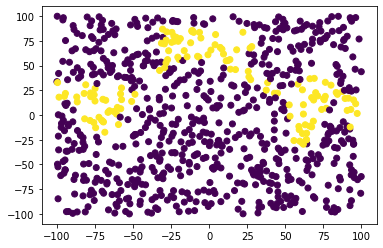

In [420]:
trainlossesBoth = nn.losses
vallossesBoth = nn.vallosses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

In [421]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.6635562762731879

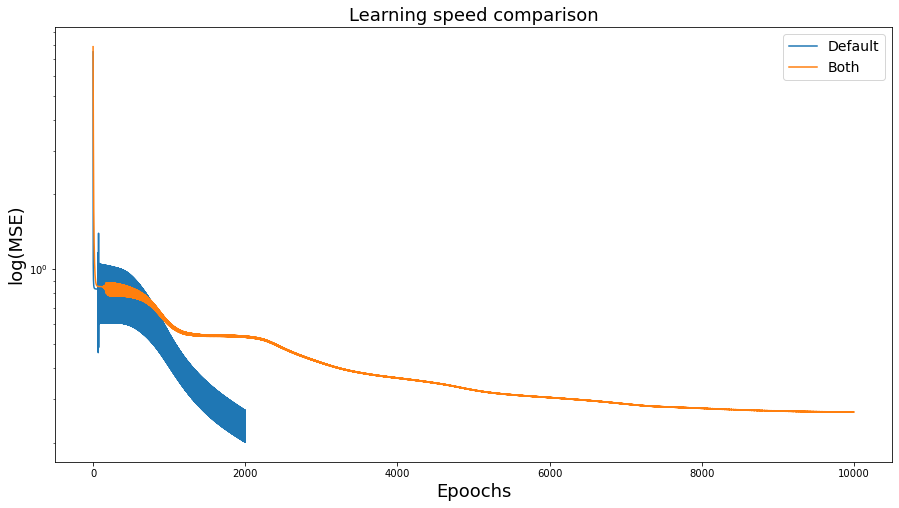

In [422]:
plt.figure(figsize=(15,8))
plt.plot(trainlossesDefault,label="Default")
plt.plot(trainlossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epoochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

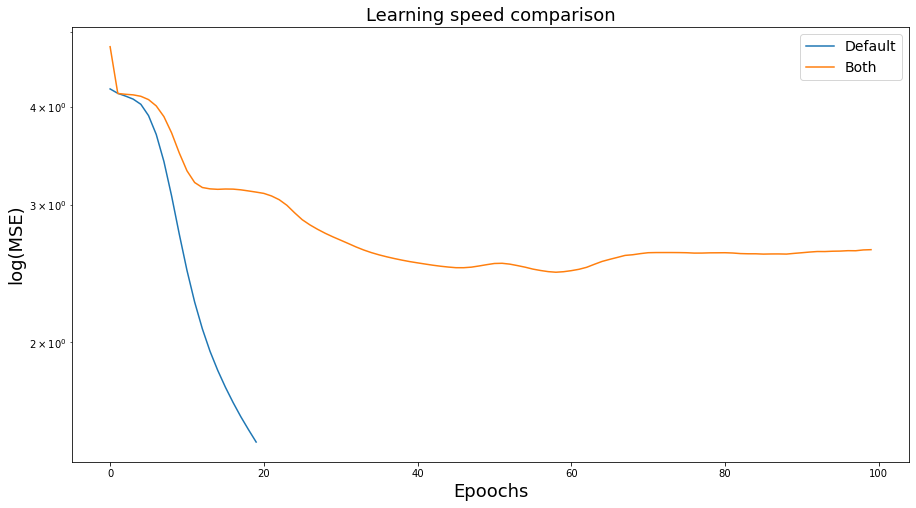

In [423]:
plt.figure(figsize=(15,8))
plt.plot(vallossesDefault,label="Default")
plt.plot(vallossesBoth,label="Both")
plt.title('Learning speed comparison',fontsize=18)
plt.xlabel('Epoochs',fontsize=18)
plt.ylabel('log(MSE)',fontsize=18)
plt.yscale("log")
plt.legend(fontsize=14)
plt.show()